In [44]:
# Author: Stefania Di Tommaso (sditom@stanford.edu)
# Guide: see HowToDownloadMosaics.docx

import requests
import os
import numpy as np
import pandas as pd
from osgeo import gdal # to crop tile
import shutil
import imageio

In [32]:
################################################################################
##  Objective: Download MOSAICS RGB given a AOI defined in the bbox variable  ##
################################################################################


####----------------------------Settings------------------------------------####
# Set API key
os.environ['PL_API_KEY'] = ''
my_auth_key = os.getenv('PL_API_KEY')

# Set AOI file
# FRANCE
base_dir = os.path.join('..', 'data', 'planet', 'france', 'sherrie10k')
bbox_df = pd.read_csv(os.path.join(base_dir, 'bbox10k_2500px.csv'), dtype=str)
bbox_df['image_id'] = bbox_df['image_id'].str.replace('_', '')
geojsonFolder = os.path.join(base_dir, 'input_locations', 'geojson_2500px')

# Set years and months of interest
year = '_2019_'
months = ['_10_']

# Set output Folder
outFolder = os.path.join(base_dir, 'temp_monthly_mosaics')
outFolder_renamed = os.path.join(base_dir, 'monthly_mosaics_renamed') # FINAL FOLDER IF RENAMING FILES

# Set folders used in clipping/merging client side
outFolder_clipped = os.path.join(base_dir, 'temp_monthly_mosaics_renamed_clipped') # TEMPORARY
outFolder_final = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged') # FINAL FOLDER IF CLIP-MERGE FILES
################################################################################

In [4]:
##########------- List All mosaics available with your account------############
headers = {
    'Authorization': 'api-key' + ' ' + my_auth_key,
}
response = requests.get('https://api.planet.com/basemaps/v1/mosaics', headers=headers)
print(response.status_code)

if response.status_code == 200: # ok, proceed
    # print(response.json())
    mosaic_names = []
    for thisMosaic in response.json()['mosaics']:
        mosaic_names.append(thisMosaic['name'])
    # print('All Available mosaics: \n {}'.format(mosaic_names))
else:
    error_msg = 'Error code {}: {}'.format(response.status_code, response.text)
    print(error_msg)
    os.sys.exit(1)
################################################################################

200


In [5]:
########---------- Subset Mosaics to Month-year of interest ----------##########

my_mosaics_year = [m for m in mosaic_names if year in m]
# subset to  January, April, July, October
my_mosaics = []
for mos in my_mosaics_year:
    for mon in months:
        if mon in mos:
            my_mosaics.append(mos)
# print('mosaics: 2018 Jan,Apr,Jul,Oct:  {} \n'.format(my_mosaics))
################################################################################

In [8]:
############## ---------- Retrive List of AOI ----------########################
# print(bbox_df.head(3))
bbox_df["bbox"] = bbox_df["min_lon"] + ',' +\
                  bbox_df["min_lat"] + ',' +\
                  bbox_df["max_lon"] + ',' +\
                  bbox_df["max_lat"]

bbox_list = bbox_df["bbox"].tolist()
bbox_names_list = bbox_df["image_id"].tolist()
# print('AOIs: {} \n'.format(len(bbox_list)))
################################################################################

In [30]:
def tileSearch(mosaic, bbox):
    # Do Tile Search and print on screen
    search_cmd = 'planet mosaics search' + ' ' + mosaic + ' ' + '--bbox' + ' ' + bbox + ' ' + '| jq ."items[].id"'
    output = os.popen(search_cmd).read()
    tile_list = output.split('\n')[:-1]
    print('        {0}: tiles to download:{1}'.format(mosaic,tile_list))


def tileDownload(mosaic, bbox, outdir):
    # save each mosaic-tiles in a separate folder named as year_month
    year_month = '_'.join(mosaic.split('_')[2:4])
    outputFolder = os.path.join(outFolder, outdir, year_month)
    if not os.path.exists(outputFolder):
        # print('Create dir {}..'.format(outputFolder))
        os.makedirs(outputFolder)
    download_cmd = 'planet mosaics download' + ' ' + mosaic + ' ' + '--bbox' + ' ' + bbox + ' ' + '--dest'+ ' ' + outputFolder
    print(download_cmd)
    output = os.popen(download_cmd).read()


def rename_files(outTempFolder, outFinalFolder):
    ######## Script for renaming all the files and save them in a unique folder #########
    ## rename: Aoi_year_month_tileId.tif
    for direc, subdir, listfilename in os.walk(outTempFolder):
        for filename in listfilename:
            dir_yearmonth = os.path.split(direc)[1] #'2018_10'
            dir_aoi = os.path.split(os.path.split(direc)[0])[1] #'7068978'
            new_filename = '_'.join([dir_aoi, dir_yearmonth, filename])
            # print(new_filename)
            src = os.path.join(direc, filename)
            if not os.path.exists(outFinalFolder):
                os.makedirs(outFinalFolder)
            dst = os.path.join(outFinalFolder, new_filename)
            os.rename(src, dst)


def delete_empty_folders(outTempFolder):
    ## Starting from outTempFolder deletes all empty folders
    # Note: after the renaming the files have been moved.
    # so folders should be all empty. if one is not, means something went wrong with renaming.
    # so checking if they are empty before deletinf is a sanity check
    # that all data have been saved in the final folder
    for root, dirs, files in os.walk(outTempFolder, topdown=False):
        for name in dirs:
            thisDir = os.path.join(root, name)
            if not os.listdir(thisDir):
#                 print(thisDir + ' is empty. It will be removed')
                os.rmdir(thisDir)
    # if all folders are empty -> remove Parent folder
    if not os.listdir(outTempFolder):
#         print(outTempFolder + ' is empty. It will be removed')
        os.rmdir(outTempFolder)


def clipQuads(inFolder, geoFolder, outFolder):
    # Clip downloaded quads using AOI geojson files
    bbox_names_list = list(set([f.split('_')[0] for f in os.listdir(inFolder)]))
    print('start clipping')
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for thisBbox in bbox_names_list:
        thisGeojson = [os.path.join(geoFolder, f) for f in os.listdir(geoFolder) if f.startswith(thisBbox)][0]
        # Find files for this AOI
        thisFiles = [f for f in os.listdir(inFolder) if f.startswith(thisBbox+'_')]
        for thisFile in thisFiles:
            source = os.path.join(inFolder, thisFile)
            output = os.path.join(outFolder, thisFile)
            gdal.Warp(srcDSOrSrcDSTab=source, destNameOrDestDS=output, cutlineDSName=thisGeojson,
                      cropToCutline=True)
    print('done clipping')


def mergeQuads(inFolder, outFolder):
    # merge tiles that belong to same AOI and same Date (year-month)
    bbox_names_list = list(set([f.split('_')[0] for f in os.listdir(inFolder)]))
    date_list = list(set(['_'.join(f.split('_')[1:3]) for f in os.listdir(inFolder)]))
    bbox_date_list = [b+'_'+d for b in bbox_names_list for d in date_list]
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for thisBboxDate in bbox_date_list:
        thisFiles = [f for f in os.listdir(inFolder) if f.startswith(thisBboxDate+'_')] # list all the files of a same bbox and same date
        input = [os.path.join(inFolder, f) for f in thisFiles]
        output = os.path.join(outFolder, thisBboxDate + '.tif')
        gdal.Warp(srcDSOrSrcDSTab = input, destNameOrDestDS = output)

In [51]:
#############################-----------MAIN-------#############################
start = 0
end = 10000

img_shapes = []
for i in range(start, end):
    thisbbox = bbox_list[i]
    print('{0}/{1} AOI:{2}, bbox:{3}'.format(i+1, len(bbox_list), bbox_names_list[i], thisbbox))
    outdir = bbox_names_list[i] # name of the AOI
    for thisMosaic in my_mosaics[:]:
#         tileSearch(thisMosaic,thisbbox) # not need to run-just sanity check
        tileDownload(thisMosaic, thisbbox, outdir) # uncomment when ready to start download!
        rename_files(outFolder, outFolder_renamed)
        clipQuads(outFolder_renamed, geojsonFolder, outFolder_clipped)
        mergeQuads(outFolder_clipped, outFolder_final)
        
        img_name = '{}_{}.tif'.format(outdir, '_'.join(thisMosaic.split('_')[2:4]))
        img = imageio.imread(os.path.join(outFolder_final, img_name))
        img_shapes.append(img.shape)
        
        delete_empty_folders(outFolder)
        shutil.rmtree(os.path.join(base_dir, 'temp_monthly_mosaics_renamed_clipped'))
        shutil.rmtree(os.path.join(base_dir, 'monthly_mosaics_renamed'))
        os.remove(os.path.join(outFolder_final, img_name))

1/10000 AOI:00000, bbox:3.5311868000290234,45.17036008907887,3.6269314154800836,45.23786015657894
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.5311868000290234,45.17036008907887,3.6269314154800836,45.23786015657894 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00000/2019_10
start clipping
done clipping
2/10000 AOI:00001, bbox:0.5913378340082591,49.5571806594158,0.6953939894716906,49.62468072691587
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5913378340082591,49.5571806594158,0.6953939894716906,49.62468072691587 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00001/2019_10
start clipping
done clipping
3/10000 AOI:00002, bbox:4.184957726518808,46.21563831090806,4.282508767763401,46.28313837840813
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.184957726518808,46.21563831090806,4.282508767763401,46.28313837840813 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00002/2019_10
start clipping
done clip

start clipping
done clipping
26/10000 AOI:00025, bbox:2.176824597893102,50.14783017334004,2.2821603051986874,50.21533024084011
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.176824597893102,50.14783017334004,2.2821603051986874,50.21533024084011 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00025/2019_10
start clipping
done clipping
27/10000 AOI:00026, bbox:7.6892628093581274,48.854449273978446,7.791850532147394,48.921949341478516
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.6892628093581274,48.854449273978446,7.791850532147394,48.921949341478516 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00026/2019_10
start clipping
done clipping
28/10000 AOI:00027, bbox:1.0621075686930368,47.84084910342704,1.1626749789880868,47.90834917092711
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0621075686930368,47.84084910342704,1.1626749789880868,47.90834917092711 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
51/10000 AOI:00050, bbox:-1.7318286332478725,47.36777840267404,-1.6321666198298086,47.43527847017411
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.7318286332478725,47.36777840267404,-1.6321666198298086,47.43527847017411 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00050/2019_10
start clipping
done clipping
52/10000 AOI:00051, bbox:5.518643499639958,43.26903321749586,5.61134512294381,43.33653328499593
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.518643499639958,43.26903321749586,5.61134512294381,43.33653328499593 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00051/2019_10
start clipping
done clipping
53/10000 AOI:00052, bbox:6.546810101136889,47.60958989451018,6.646932011826251,47.67708996201025
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.546810101136889,47.60958989451018,6.646932011826251,47.67708996201025 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00052/

start clipping
done clipping
76/10000 AOI:00075, bbox:3.825828778526062,45.697713974965325,3.922472293192023,45.765214042465395
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.825828778526062,45.697713974965325,3.922472293192023,45.765214042465395 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00075/2019_10
start clipping
done clipping
77/10000 AOI:00076, bbox:5.7806612315366275,47.531939121814716,5.880634803334663,47.599439189314786
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.7806612315366275,47.531939121814716,5.880634803334663,47.599439189314786 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00076/2019_10
start clipping
done clipping
78/10000 AOI:00077, bbox:2.374860996082935,46.440076221779236,2.4728131211260007,46.50757628927931
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.374860996082935,46.440076221779236,2.4728131211260007,46.50757628927931 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
101/10000 AOI:00100, bbox:0.3166013509299521,43.50015415710771,0.4096570784850056,43.56765422460778
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3166013509299521,43.50015415710771,0.4096570784850056,43.56765422460778 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00100/2019_10
start clipping
done clipping
102/10000 AOI:00101, bbox:4.156946245824716,45.29643585074039,4.252903500700577,45.36393591824046
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.156946245824716,45.29643585074039,4.252903500700577,45.36393591824046 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00101/2019_10
start clipping
done clipping
103/10000 AOI:00102, bbox:-0.1734527222888831,45.54379428692398,-0.07707415523443986,45.611294354424054
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.1734527222888831,45.54379428692398,-0.07707415523443986,45.611294354424054 --dest ../data/planet/france/sherrie10k/temp_monthly_m

start clipping
done clipping
126/10000 AOI:00125, bbox:-0.13404486961381856,44.20321552498358,-0.03988563838556897,44.27071559248365
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.13404486961381856,44.20321552498358,-0.03988563838556897,44.27071559248365 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00125/2019_10
start clipping
done clipping
127/10000 AOI:00126, bbox:2.9858796917985506,48.9750192397474,3.088715309929365,49.04251930724747
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.9858796917985506,48.9750192397474,3.088715309929365,49.04251930724747 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00126/2019_10
start clipping
done clipping
128/10000 AOI:00127, bbox:4.692218984406321,49.61801048442669,4.796404970901327,49.68551055192676
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.692218984406321,49.61801048442669,4.796404970901327,49.68551055192676 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
151/10000 AOI:00150, bbox:4.607481146064051,47.313900452741606,4.707041505910822,47.38140052024168
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.607481146064051,47.313900452741606,4.707041505910822,47.38140052024168 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00150/2019_10
start clipping
done clipping
152/10000 AOI:00151, bbox:3.7883330818456953,43.80517804611961,3.8818626441327817,43.87267811361968
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.7883330818456953,43.80517804611961,3.8818626441327817,43.87267811361968 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00151/2019_10
start clipping
done clipping
153/10000 AOI:00152, bbox:1.276201474787138,46.553360691768304,1.3743578745159823,46.620860759268375
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.276201474787138,46.553360691768304,1.3743578745159823,46.620860759268375 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
176/10000 AOI:00175, bbox:0.5413036054372933,49.45101528546577,0.6451342221115133,49.51851535296584
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5413036054372933,49.45101528546577,0.6451342221115133,49.51851535296584 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00175/2019_10
start clipping
done clipping
177/10000 AOI:00176, bbox:3.903090677536908,46.901306615899806,4.001882282181084,46.968806683399876
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.903090677536908,46.901306615899806,4.001882282181084,46.968806683399876 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00176/2019_10
start clipping
done clipping
178/10000 AOI:00177, bbox:1.037908429743239,42.94526150239696,1.1301210161032265,43.01276156989703
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.037908429743239,42.94526150239696,1.1301210161032265,43.01276156989703 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics

start clipping
done clipping
201/10000 AOI:00200, bbox:-3.200190591336865,48.54659377100465,-3.0982284015550037,48.61409383850472
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.200190591336865,48.54659377100465,-3.0982284015550037,48.61409383850472 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00200/2019_10
start clipping
done clipping
202/10000 AOI:00201, bbox:1.4107640222157807,46.165960389380786,1.5082269314042853,46.233460456880856
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4107640222157807,46.165960389380786,1.5082269314042853,46.233460456880856 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00201/2019_10
start clipping
done clipping
203/10000 AOI:00202, bbox:3.1488383515722402,47.315940324228464,3.2484025547417357,47.383440391728534
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.1488383515722402,47.315940324228464,3.2484025547417357,47.383440391728534 --dest ../data/planet/france/sherrie10k/temp_mon

start clipping
done clipping
226/10000 AOI:00225, bbox:5.7836679417134595,48.071034524059826,5.8846843790819054,48.138534591559896
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.7836679417134595,48.071034524059826,5.8846843790819054,48.138534591559896 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00225/2019_10
start clipping
done clipping
227/10000 AOI:00226, bbox:1.8874246756460282,43.78044772085591,1.9809155424566773,43.84794778835598
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8874246756460282,43.78044772085591,1.9809155424566773,43.84794778835598 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00226/2019_10
start clipping
done clipping
228/10000 AOI:00227, bbox:4.175833671969666,44.45775334523124,4.270402433577464,44.52525341273131
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.175833671969666,44.45775334523124,4.270402433577464,44.52525341273131 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
251/10000 AOI:00250, bbox:3.4593567948407644,50.37141157657975,3.5651880616606415,50.43891164407982
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.4593567948407644,50.37141157657975,3.5651880616606415,50.43891164407982 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00250/2019_10
start clipping
done clipping
252/10000 AOI:00251, bbox:4.746780080582998,47.79966214525059,4.8472677381229365,47.867162212750664
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.746780080582998,47.79966214525059,4.8472677381229365,47.867162212750664 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00251/2019_10
start clipping
done clipping
253/10000 AOI:00252, bbox:5.548368834774636,47.35230577492924,5.648001625139945,47.41980584242931
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.548368834774636,47.35230577492924,5.648001625139945,47.41980584242931 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0

start clipping
done clipping
276/10000 AOI:00275, bbox:3.6798868269814653,48.02908461736394,3.7808210118152914,48.09658468486401
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6798868269814653,48.02908461736394,3.7808210118152914,48.09658468486401 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00275/2019_10
start clipping
done clipping
277/10000 AOI:00276, bbox:-0.6756758084864876,46.32325267101237,-0.5779330518685908,46.39075273851244
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6756758084864876,46.32325267101237,-0.5779330518685908,46.39075273851244 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00276/2019_10
start clipping
done clipping
278/10000 AOI:00277, bbox:5.22961245424396,49.30215032484687,5.33312905926241,49.36965039234694
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.22961245424396,49.30215032484687,5.33312905926241,49.36965039234694 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0

start clipping
done clipping
301/10000 AOI:00300, bbox:2.3133277734978925,42.94643277258029,2.4055421143913365,43.01393284008036
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3133277734978925,42.94643277258029,2.4055421143913365,43.01393284008036 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00300/2019_10
start clipping
done clipping
302/10000 AOI:00301, bbox:-1.8766250773249125,47.881275095635225,-1.7759792139612705,47.948775163135295
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.8766250773249125,47.881275095635225,-1.7759792139612705,47.948775163135295 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00301/2019_10
start clipping
done clipping
303/10000 AOI:00302, bbox:0.31664853086582134,43.45324945219991,0.4096320538493178,43.52074951969998
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.31664853086582134,43.45324945219991,0.4096320538493178,43.52074951969998 --dest ../data/planet/france/sherrie10k/temp_mon

start clipping
done clipping
326/10000 AOI:00325, bbox:2.711652063568267,43.370283407569225,2.8045082957824254,43.437783475069295
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.711652063568267,43.370283407569225,2.8045082957824254,43.437783475069295 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00325/2019_10
start clipping
done clipping
327/10000 AOI:00326, bbox:-0.9709997830977448,48.01481156868792,-0.8700935410311926,48.08231163618799
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9709997830977448,48.01481156868792,-0.8700935410311926,48.08231163618799 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00326/2019_10
start clipping
done clipping
328/10000 AOI:00327, bbox:-0.7107732402635323,43.259895709368955,-0.6180855303676673,43.327395776869025
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7107732402635323,43.259895709368955,-0.6180855303676673,43.327395776869025 --dest ../data/planet/france/sherrie10k/temp

start clipping
done clipping
351/10000 AOI:00350, bbox:5.647159638895762,48.058647621296366,5.748151769286592,48.126147688796436
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.647159638895762,48.058647621296366,5.748151769286592,48.126147688796436 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00350/2019_10
start clipping
done clipping
352/10000 AOI:00351, bbox:-0.20212057042184917,45.014936510402244,-0.10663616430532424,45.082436577902314
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.20212057042184917,45.014936510402244,-0.10663616430532424,45.082436577902314 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00351/2019_10
start clipping
done clipping
353/10000 AOI:00352, bbox:2.4726341366175735,45.864122460518814,2.569566529258041,45.931622528018885
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.4726341366175735,45.864122460518814,2.569566529258041,45.931622528018885 --dest ../data/planet/france/sherrie10k/temp

done clipping
375/10000 AOI:00374, bbox:1.0083366559464402,46.04922115564686,1.1055933744408004,46.11672122314693
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0083366559464402,46.04922115564686,1.1055933744408004,46.11672122314693 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00374/2019_10
start clipping
done clipping
376/10000 AOI:00375, bbox:1.673478026696828,49.85832175696708,1.778181259345862,49.92582182446715
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.673478026696828,49.85832175696708,1.778181259345862,49.92582182446715 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00375/2019_10
start clipping
done clipping
377/10000 AOI:00376, bbox:6.7624131711281015,45.30399554795052,6.858383220989887,45.37149561545059
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.7624131711281015,45.30399554795052,6.858383220989887,45.37149561545059 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00376/2019_10
star

start clipping
done clipping
400/10000 AOI:00399, bbox:-0.06214415031995468,48.92338440452659,0.04058510287441741,48.99088447202666
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.06214415031995468,48.92338440452659,0.04058510287441741,48.99088447202666 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00399/2019_10
start clipping
done clipping
401/10000 AOI:00400, bbox:7.258001144808088,48.705299071277004,7.360284484192636,48.772799138777074
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.258001144808088,48.705299071277004,7.360284484192636,48.772799138777074 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00400/2019_10
start clipping
done clipping
402/10000 AOI:00401, bbox:8.951231761241509,42.57914039717007,9.04290103035196,42.64664046467014
planet mosaics download global_monthly_2019_10_mosaic --bbox 8.951231761241509,42.57914039717007,9.04290103035196,42.64664046467014 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
425/10000 AOI:00424, bbox:4.59361964527197,49.83135088217147,4.698264478245297,49.89885094967154
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.59361964527197,49.83135088217147,4.698264478245297,49.89885094967154 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00424/2019_10
start clipping
done clipping
426/10000 AOI:00425, bbox:-1.6315837011563903,48.62306062201581,-1.5294671260970116,48.69056068951588
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.6315837011563903,48.62306062201581,-1.5294671260970116,48.69056068951588 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00425/2019_10
start clipping
done clipping
427/10000 AOI:00426, bbox:-1.9987412463950283,47.41398261118124,-1.8989918219415367,47.48148267868131
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.9987412463950283,47.41398261118124,-1.8989918219415367,47.48148267868131 --dest ../data/planet/france/sherrie10k/temp_monthly_mos

start clipping
done clipping
450/10000 AOI:00449, bbox:1.458921059262348,49.85845335412475,1.563624577073639,49.92595342162482
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.458921059262348,49.85845335412475,1.563624577073639,49.92595342162482 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00449/2019_10
start clipping
done clipping
451/10000 AOI:00450, bbox:2.3063918852485106,43.32987353682811,2.399186315091548,43.39737360432818
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3063918852485106,43.32987353682811,2.399186315091548,43.39737360432818 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00450/2019_10
start clipping
done clipping
452/10000 AOI:00451, bbox:2.5999487718994256,49.881487212981526,2.7047022350027046,49.948987280481596
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.5999487718994256,49.881487212981526,2.7047022350027046,49.948987280481596 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics

start clipping
done clipping
475/10000 AOI:00474, bbox:4.076578637943364,48.3755481455148,4.178197827226077,48.44304821301487
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.076578637943364,48.3755481455148,4.178197827226077,48.44304821301487 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00474/2019_10
start clipping
done clipping
476/10000 AOI:00475, bbox:6.251258554084251,48.307513442674946,6.352742203861553,48.375013510175016
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.251258554084251,48.307513442674946,6.352742203861553,48.375013510175016 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00475/2019_10
start clipping
done clipping
477/10000 AOI:00476, bbox:2.527591530313698,48.08317664322149,2.628631810260959,48.15067671072156
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.527591530313698,48.08317664322149,2.628631810260959,48.15067671072156 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00476/2

start clipping
done clipping
500/10000 AOI:00499, bbox:4.188434937209261,49.30063012384186,4.29194834895471,49.36813019134193
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.188434937209261,49.30063012384186,4.29194834895471,49.36813019134193 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00499/2019_10
start clipping
done clipping
501/10000 AOI:00500, bbox:-1.4959576133217358,47.66426471794007,-1.3957308805233486,47.73176478544014
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.4959576133217358,47.66426471794007,-1.3957308805233486,47.73176478544014 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00500/2019_10
start clipping
done clipping
502/10000 AOI:00501, bbox:4.32497566124746,48.772351171542375,4.427395529865743,48.839851239042446
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.32497566124746,48.772351171542375,4.427395529865743,48.839851239042446 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0

start clipping
done clipping
525/10000 AOI:00524, bbox:-1.681266831235606,48.469421025162255,-1.579459795769071,48.536921092662325
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.681266831235606,48.469421025162255,-1.579459795769071,48.536921092662325 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00524/2019_10
start clipping
done clipping
526/10000 AOI:00525, bbox:4.780149615394772,50.11482381386124,4.885412693751023,50.18232388136131
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.780149615394772,50.11482381386124,4.885412693751023,50.18232388136131 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00525/2019_10
start clipping
done clipping
527/10000 AOI:00526, bbox:-3.545624430859979,47.830770565109816,-3.44507655273616,47.898270632609886
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.545624430859979,47.830770565109816,-3.44507655273616,47.898270632609886 --dest ../data/planet/france/sherrie10k/temp_monthly_mos

start clipping
done clipping
550/10000 AOI:00549, bbox:0.10562844323956977,43.36690175163307,0.1984794986624924,43.43440181913314
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.10562844323956977,43.36690175163307,0.1984794986624924,43.43440181913314 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00549/2019_10
start clipping
done clipping
551/10000 AOI:00550, bbox:2.492324542530791,45.72421817175956,2.5890138974374857,45.79171823925963
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.492324542530791,45.72421817175956,2.5890138974374857,45.79171823925963 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00550/2019_10
start clipping
done clipping
552/10000 AOI:00551, bbox:1.942655834923487,44.847867809547424,2.0378628872599527,44.915367877047494
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.942655834923487,44.847867809547424,2.0378628872599527,44.915367877047494 --dest ../data/planet/france/sherrie10k/temp_monthly_mos

574/10000 AOI:00573, bbox:-0.0971137398121753,47.86965838450649,0.0035095618157244407,47.93715845200656
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.0971137398121753,47.86965838450649,0.0035095618157244407,47.93715845200656 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00573/2019_10
start clipping
done clipping
575/10000 AOI:00574, bbox:0.3710677560420308,48.06639870020231,0.4720750945513271,48.133898767702384
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3710677560420308,48.06639870020231,0.4720750945513271,48.133898767702384 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00574/2019_10
start clipping
done clipping
576/10000 AOI:00575, bbox:-4.04655506157571,48.08598054841492,-3.9455092735630557,48.153480615914994
planet mosaics download global_monthly_2019_10_mosaic --bbox -4.04655506157571,48.08598054841492,-3.9455092735630557,48.153480615914994 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00575/2019_10


start clipping
done clipping
599/10000 AOI:00598, bbox:-0.6299751641064528,43.34350654264186,-0.5371598984657552,43.41100661014193
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6299751641064528,43.34350654264186,-0.5371598984657552,43.41100661014193 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00598/2019_10
start clipping
done clipping
600/10000 AOI:00599, bbox:1.909079197981841,48.77943377846314,2.0115135174488694,48.84693384596321
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.909079197981841,48.77943377846314,2.0115135174488694,48.84693384596321 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00599/2019_10
start clipping
done clipping
601/10000 AOI:00600, bbox:1.4608666303896856,44.95892025764367,1.5562577726013433,45.02642032514374
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4608666303896856,44.95892025764367,1.5562577726013433,45.02642032514374 --dest ../data/planet/france/sherrie10k/temp_monthly_mos

start clipping
done clipping
624/10000 AOI:00623, bbox:-1.1298953294017018,47.108404209969905,-1.0307199879108797,47.175904277469975
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.1298953294017018,47.108404209969905,-1.0307199879108797,47.175904277469975 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00623/2019_10
start clipping
done clipping
625/10000 AOI:00624, bbox:0.4690753218229178,43.18039813232638,0.5616422584103766,43.24789819982645
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.4690753218229178,43.18039813232638,0.5616422584103766,43.24789819982645 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00624/2019_10
start clipping
done clipping
626/10000 AOI:00625, bbox:1.5797941360798893,45.65968002721917,1.6763719812384799,45.72718009471924
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5797941360798893,45.65968002721917,1.6763719812384799,45.72718009471924 --dest ../data/planet/france/sherrie10k/temp_month

start clipping
done clipping
649/10000 AOI:00648, bbox:2.1497956990438674,43.39139794882864,2.2426842747272326,43.45889801632871
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.1497956990438674,43.39139794882864,2.2426842747272326,43.45889801632871 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00648/2019_10
start clipping
done clipping
650/10000 AOI:00649, bbox:3.8989814726766054,48.99268105489332,4.00185354294129,49.06018112239339
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8989814726766054,48.99268105489332,4.00185354294129,49.06018112239339 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00649/2019_10
start clipping
done clipping
651/10000 AOI:00650, bbox:0.24676210591711367,47.46513976489039,0.34660856645047866,47.53263983239046
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.24676210591711367,47.46513976489039,0.34660856645047866,47.53263983239046 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
674/10000 AOI:00673, bbox:1.4217274734656797,46.78520594472747,1.5203058100373723,46.85270601222754
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4217274734656797,46.78520594472747,1.5203058100373723,46.85270601222754 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00673/2019_10
start clipping
done clipping
675/10000 AOI:00674, bbox:-1.0257354511876313,46.68321169257882,-0.9273433792449575,46.75071176007889
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0257354511876313,46.68321169257882,-0.9273433792449575,46.75071176007889 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00674/2019_10
start clipping
done clipping
676/10000 AOI:00675, bbox:6.95753016017843,48.87100527428847,7.060151824871666,48.93850534178854
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.95753016017843,48.87100527428847,7.060151824871666,48.93850534178854 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics

start clipping
done clipping
699/10000 AOI:00698, bbox:-0.7733223412858248,44.33000780035216,-0.6789597888428044,44.397507867852234
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7733223412858248,44.33000780035216,-0.6789597888428044,44.397507867852234 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00698/2019_10
start clipping
done clipping
700/10000 AOI:00699, bbox:2.418012087942225,42.64809983555724,2.50978291562991,42.71559990305731
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.418012087942225,42.64809983555724,2.50978291562991,42.71559990305731 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00699/2019_10
start clipping
done clipping
701/10000 AOI:00700, bbox:4.209990482416155,47.675722115235956,4.3102392206371505,47.74322218273603
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.209990482416155,47.675722115235956,4.3102392206371505,47.74322218273603 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
724/10000 AOI:00723, bbox:1.5407482054939825,48.13636302840884,1.6418931099322607,48.20386309590891
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5407482054939825,48.13636302840884,1.6418931099322607,48.20386309590891 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00723/2019_10
start clipping
done clipping
725/10000 AOI:00724, bbox:7.001474599736372,49.01283274790778,7.104388304507132,49.08033281540785
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.001474599736372,49.01283274790778,7.104388304507132,49.08033281540785 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00724/2019_10
start clipping
done clipping
726/10000 AOI:00725, bbox:3.7159467233825305,44.072583883176776,3.80989787117183,44.140083950676846
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.7159467233825305,44.072583883176776,3.80989787117183,44.140083950676846 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0

start clipping
done clipping
749/10000 AOI:00748, bbox:3.086437200634127,49.07224377815802,3.189473922483994,49.13974384565809
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.086437200634127,49.07224377815802,3.189473922483994,49.13974384565809 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00748/2019_10
start clipping
done clipping
750/10000 AOI:00749, bbox:2.8887871384160535,47.531390131000514,2.988759663676568,47.598890198500584
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.8887871384160535,47.531390131000514,2.988759663676568,47.598890198500584 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00749/2019_10
start clipping
done clipping
751/10000 AOI:00750, bbox:2.7795452257242586,47.65214240046461,2.879748690911314,47.71964246796468
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7795452257242586,47.65214240046461,2.879748690911314,47.71964246796468 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0

start clipping
done clipping
774/10000 AOI:00773, bbox:0.9230900850048833,48.306717890463915,1.0245721528586835,48.374217957963985
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9230900850048833,48.306717890463915,1.0245721528586835,48.374217957963985 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00773/2019_10
start clipping
done clipping
775/10000 AOI:00774, bbox:5.450417255593254,49.48319488974023,5.554316093948267,49.5506949572403
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.450417255593254,49.48319488974023,5.554316093948267,49.5506949572403 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00774/2019_10
start clipping
done clipping
776/10000 AOI:00775, bbox:0.6259439766330619,43.358969596421,0.7187828926889402,43.42646966392107
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6259439766330619,43.358969596421,0.7187828926889402,43.42646966392107 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/007

start clipping
done clipping
799/10000 AOI:00798, bbox:4.307610801049274,43.58930509723585,4.400804248515443,43.65680516473592
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.307610801049274,43.58930509723585,4.400804248515443,43.65680516473592 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00798/2019_10
start clipping
done clipping
800/10000 AOI:00799, bbox:2.287669440792091,42.55011539140857,2.3792960707765305,42.61761545890864
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.287669440792091,42.55011539140857,2.3792960707765305,42.61761545890864 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00799/2019_10
start clipping
done clipping
801/10000 AOI:00800, bbox:0.15173826606101137,48.469430601281616,0.25354532073940483,48.536930668781686
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.15173826606101137,48.469430601281616,0.25354532073940483,48.536930668781686 --dest ../data/planet/france/sherrie10k/temp_monthly_mos

823/10000 AOI:00822, bbox:4.271845351664099,44.775569624444664,4.36693312952947,44.843069691944734
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.271845351664099,44.775569624444664,4.36693312952947,44.843069691944734 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00822/2019_10
start clipping
done clipping
824/10000 AOI:00823, bbox:1.4422815282025923,45.110461092131,1.5379256099126382,45.17796115963107
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4422815282025923,45.110461092131,1.5379256099126382,45.17796115963107 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00823/2019_10
start clipping
done clipping
825/10000 AOI:00824, bbox:0.2291790863507197,48.14129324062526,0.33033370454398125,48.20879330812533
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.2291790863507197,48.14129324062526,0.33033370454398125,48.20879330812533 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00824/2019_10
start clipping
d

start clipping
done clipping
848/10000 AOI:00847, bbox:4.809298327334662,43.65278320797006,4.9025902220136475,43.72028327547013
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.809298327334662,43.65278320797006,4.9025902220136475,43.72028327547013 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00847/2019_10
start clipping
done clipping
849/10000 AOI:00848, bbox:1.3192250167171116,46.373084638900465,1.4170569217149551,46.440584706400536
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3192250167171116,46.373084638900465,1.4170569217149551,46.440584706400536 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00848/2019_10
start clipping
done clipping
850/10000 AOI:00849, bbox:1.4263102182554697,43.339527653225126,1.519119401311017,43.407027720725196
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4263102182554697,43.339527653225126,1.519119401311017,43.407027720725196 --dest ../data/planet/france/sherrie10k/temp_monthly_m

start clipping
done clipping
873/10000 AOI:00872, bbox:4.074237952140943,48.644892253782224,4.1763987241452325,48.712392321282294
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.074237952140943,48.644892253782224,4.1763987241452325,48.712392321282294 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00872/2019_10
start clipping
done clipping
874/10000 AOI:00873, bbox:-0.18310510468498364,44.932364379200806,-0.08775808106138744,44.999864446700876
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.18310510468498364,44.932364379200806,-0.08775808106138744,44.999864446700876 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00873/2019_10
start clipping
done clipping
875/10000 AOI:00874, bbox:3.2250304786599484,50.21309574534973,3.3305101983903524,50.2805958128498
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.2250304786599484,50.21309574534973,3.3305101983903524,50.2805958128498 --dest ../data/planet/france/sherrie10k/temp_m

start clipping
done clipping
898/10000 AOI:00897, bbox:4.853814252281373,48.73327678478699,4.956154497629154,48.80077685228706
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.853814252281373,48.73327678478699,4.956154497629154,48.80077685228706 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00897/2019_10
start clipping
done clipping
899/10000 AOI:00898, bbox:0.10194183862054285,45.51520277927097,0.19827142643447948,45.58270284677104
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.10194183862054285,45.51520277927097,0.19827142643447948,45.58270284677104 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00898/2019_10
start clipping
done clipping
900/10000 AOI:00899, bbox:6.729068601839244,48.609110535827796,6.831156963489827,48.676610603327866
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.729068601839244,48.609110535827796,6.831156963489827,48.676610603327866 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
923/10000 AOI:00922, bbox:-2.9052920784139706,47.81431283838941,-2.804776072316509,47.88181290588948
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.9052920784139706,47.81431283838941,-2.804776072316509,47.88181290588948 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00922/2019_10
start clipping
done clipping
924/10000 AOI:00923, bbox:-2.7541752763936223,47.782016472839935,-2.6537217326500286,47.849516540340005
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.7541752763936223,47.782016472839935,-2.6537217326500286,47.849516540340005 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00923/2019_10
start clipping
done clipping
925/10000 AOI:00924, bbox:3.574928021545909,43.81058262461261,3.6684660469492743,43.87808269211268
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.574928021545909,43.81058262461261,3.6684660469492743,43.87808269211268 --dest ../data/planet/france/sherrie10k/temp_month

start clipping
done clipping
948/10000 AOI:00947, bbox:4.598011955216111,49.193913299500984,4.701301874630551,49.261413367001055
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.598011955216111,49.193913299500984,4.701301874630551,49.261413367001055 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00947/2019_10
start clipping
done clipping
949/10000 AOI:00948, bbox:0.6195273549558067,49.20569589057552,0.7228418851329593,49.27319595807559
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6195273549558067,49.20569589057552,0.7228418851329593,49.27319595807559 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00948/2019_10
start clipping
done clipping
950/10000 AOI:00949, bbox:-0.22694628719970744,43.55625076445756,-0.13380397572942443,43.62375083195763
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.22694628719970744,43.55625076445756,-0.13380397572942443,43.62375083195763 --dest ../data/planet/france/sherrie10k/temp_month

start clipping
done clipping
973/10000 AOI:00972, bbox:3.4816483904227438,48.54023615347441,3.5835977734709026,48.60773622097448
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.4816483904227438,48.54023615347441,3.5835977734709026,48.60773622097448 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00972/2019_10
start clipping
done clipping
974/10000 AOI:00973, bbox:-1.5969422080346014,46.800969744954976,-1.4983349923469416,46.86846981245505
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.5969422080346014,46.800969744954976,-1.4983349923469416,46.86846981245505 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00973/2019_10
start clipping
done clipping
975/10000 AOI:00974, bbox:-1.4159256200606993,47.291396393210945,-1.3164076320678466,47.358896460711016
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.4159256200606993,47.291396393210945,-1.3164076320678466,47.358896460711016 --dest ../data/planet/france/sherrie10k/temp

start clipping
done clipping
998/10000 AOI:00997, bbox:-3.5479636015094416,48.09295251352711,-3.4469041139318026,48.16045258102718
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.5479636015094416,48.09295251352711,-3.4469041139318026,48.16045258102718 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00997/2019_10
start clipping
done clipping
999/10000 AOI:00998, bbox:5.847603400029791,45.047575088736075,5.943142273809689,45.115075156236145
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.847603400029791,45.047575088736075,5.943142273809689,45.115075156236145 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/00998/2019_10
start clipping
done clipping
1000/10000 AOI:00999, bbox:3.341967472754633,46.447998025354245,3.439933842303186,46.515498092854315
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.341967472754633,46.447998025354245,3.439933842303186,46.515498092854315 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
1023/10000 AOI:01022, bbox:-2.429178442872939,47.62191162741996,-2.329032936162795,47.68941169492003
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.429178442872939,47.62191162741996,-2.329032936162795,47.68941169492003 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01022/2019_10
start clipping
done clipping
1024/10000 AOI:01023, bbox:-1.858403207302827,48.32985134570445,-1.7568751113699128,48.39735141320452
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.858403207302827,48.32985134570445,-1.7568751113699128,48.39735141320452 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01023/2019_10
start clipping
done clipping
1025/10000 AOI:01024, bbox:4.667798898764052,47.36817286572766,4.767461657521065,47.43567293322773
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.667798898764052,47.36817286572766,4.767461657521065,47.43567293322773 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
1048/10000 AOI:01047, bbox:2.1634999113164968,48.297173499119424,2.264963005902115,48.364673566619494
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.1634999113164968,48.297173499119424,2.264963005902115,48.364673566619494 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01047/2019_10
start clipping
done clipping
1049/10000 AOI:01048, bbox:0.8444010421441099,47.04353785389265,0.9434557314687342,47.11103792139272
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8444010421441099,47.04353785389265,0.9434557314687342,47.11103792139272 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01048/2019_10
start clipping
done clipping
1050/10000 AOI:01049, bbox:3.6699359217221703,48.771759272219015,3.7723545829265253,48.839259339719085
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6699359217221703,48.771759272219015,3.7723545829265253,48.839259339719085 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
1073/10000 AOI:01072, bbox:4.932364295572655,45.962846921841845,5.029469275249835,46.030346989341915
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.932364295572655,45.962846921841845,5.029469275249835,46.030346989341915 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01072/2019_10
start clipping
done clipping
1074/10000 AOI:01073, bbox:-3.4842909213426734,47.917466182817435,-3.3835746769374517,47.984966250317505
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.4842909213426734,47.917466182817435,-3.3835746769374517,47.984966250317505 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01073/2019_10
start clipping
done clipping
1075/10000 AOI:01074, bbox:2.7432187945247284,49.02253229660853,2.8461525556538327,49.0900323641086
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7432187945247284,49.02253229660853,2.8461525556538327,49.0900323641086 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
1098/10000 AOI:01097, bbox:6.9316924296592815,48.253151634737634,7.03306814143888,48.320651702237704
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.9316924296592815,48.253151634737634,7.03306814143888,48.320651702237704 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01097/2019_10
start clipping
done clipping
1099/10000 AOI:01098, bbox:2.109890585108599,46.276378480403196,2.2075497002820255,46.343878547903266
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.109890585108599,46.276378480403196,2.2075497002820255,46.343878547903266 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01098/2019_10
start clipping
done clipping
1100/10000 AOI:01099, bbox:4.113777126049658,44.82182105988835,4.2089411556363485,44.88932112738842
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.113777126049658,44.82182105988835,4.2089411556363485,44.88932112738842 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
1123/10000 AOI:01122, bbox:2.126795777090777,47.02393964554382,2.2258140961961876,47.09143971304389
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.126795777090777,47.02393964554382,2.2258140961961876,47.09143971304389 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01122/2019_10
start clipping
done clipping
1124/10000 AOI:01123, bbox:1.818190650438937,43.730648097006714,1.9116037457511068,43.798148164506784
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.818190650438937,43.730648097006714,1.9116037457511068,43.798148164506784 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01123/2019_10
start clipping
done clipping
1125/10000 AOI:01124, bbox:4.19419741010877,45.421276068736525,4.290366613091802,45.488776136236595
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.19419741010877,45.421276068736525,4.290366613091802,45.488776136236595 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
1148/10000 AOI:01147, bbox:7.02928169975467,48.72120449084973,7.131597379604325,48.7887045583498
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.02928169975467,48.72120449084973,7.131597379604325,48.7887045583498 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01147/2019_10
start clipping
done clipping
1149/10000 AOI:01148, bbox:6.327227088710191,48.01883142230833,6.428141198363755,48.0863314898084
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.327227088710191,48.01883142230833,6.428141198363755,48.0863314898084 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01148/2019_10
start clipping
done clipping
1150/10000 AOI:01149, bbox:4.293378243056666,46.579250181986524,4.391581500355321,46.646750249486594
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.293378243056666,46.579250181986524,4.391581500355321,46.646750249486594 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01149/20

start clipping
done clipping
1173/10000 AOI:01172, bbox:-0.29448009054281243,47.419853412898135,-0.1947195438361783,47.487353480398205
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.29448009054281243,47.419853412898135,-0.1947195438361783,47.487353480398205 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01172/2019_10
start clipping
done clipping
1174/10000 AOI:01173, bbox:4.959059980074888,47.8899410815373,5.059722683622388,47.95744114903737
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.959059980074888,47.8899410815373,5.059722683622388,47.95744114903737 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01173/2019_10
start clipping
done clipping
1175/10000 AOI:01174, bbox:0.9860650955358947,48.42449846763043,1.0877821171878181,48.4919985351305
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9860650955358947,48.42449846763043,1.0877821171878181,48.4919985351305 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
1198/10000 AOI:01197, bbox:6.548545796818364,45.46839153346386,6.644795352805747,45.53589160096393
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.548545796818364,45.46839153346386,6.644795352805747,45.53589160096393 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01197/2019_10
start clipping
done clipping
1199/10000 AOI:01198, bbox:4.688040772798426,43.44194228677991,4.7810069157345225,43.50944235427998
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.688040772798426,43.44194228677991,4.7810069157345225,43.50944235427998 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01198/2019_10
start clipping
done clipping
1200/10000 AOI:01199, bbox:-2.0600538554031926,47.806211240755516,-1.9595535283907743,47.87371130825559
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.0600538554031926,47.806211240755516,-1.9595535283907743,47.87371130825559 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

1222/10000 AOI:01221, bbox:6.137654949556436,44.16118755164222,6.231747080452091,44.22868761914229
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.137654949556436,44.16118755164222,6.231747080452091,44.22868761914229 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01221/2019_10
start clipping
done clipping
1223/10000 AOI:01222, bbox:-0.20903576991444162,44.502653367080825,-0.11439420378184825,44.570153434580895
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.20903576991444162,44.502653367080825,-0.11439420378184825,44.570153434580895 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01222/2019_10
start clipping
done clipping
1224/10000 AOI:01223, bbox:1.4353325680887572,48.409774404413085,1.5370201345415861,48.477274471913155
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4353325680887572,48.409774404413085,1.5370201345415861,48.477274471913155 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01223/2019_

start clipping
done clipping
1247/10000 AOI:01246, bbox:3.723865014994648,46.422635088066436,3.8217857996423286,46.490135155566506
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.723865014994648,46.422635088066436,3.8217857996423286,46.490135155566506 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01246/2019_10
start clipping
done clipping
1248/10000 AOI:01247, bbox:9.327974728270831,42.89529880178834,9.42011256970448,42.96279886928841
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.327974728270831,42.89529880178834,9.42011256970448,42.96279886928841 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01247/2019_10
start clipping
done clipping
1249/10000 AOI:01248, bbox:4.841259587296732,49.1349460918303,4.94442658104043,49.20244615933037
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.841259587296732,49.1349460918303,4.94442658104043,49.20244615933037 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01248/

start clipping
done clipping
1272/10000 AOI:01271, bbox:3.9291538151511913,48.74340271488387,4.031514678011513,48.81090278238394
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9291538151511913,48.74340271488387,4.031514678011513,48.81090278238394 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01271/2019_10
start clipping
done clipping
1273/10000 AOI:01272, bbox:1.5752805375956935,48.88312480392025,1.677927068541115,48.950624871420324
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5752805375956935,48.88312480392025,1.677927068541115,48.950624871420324 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01272/2019_10
start clipping
done clipping
1274/10000 AOI:01273, bbox:1.510184326068802,46.88051248976888,1.608937635857606,46.94801255726895
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.510184326068802,46.88051248976888,1.608937635857606,46.94801255726895 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

1296/10000 AOI:01295, bbox:-0.9592676181908137,44.88169926342006,-0.8640045971901886,44.94919933092013
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9592676181908137,44.88169926342006,-0.8640045971901886,44.94919933092013 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01295/2019_10
start clipping
done clipping
1297/10000 AOI:01296, bbox:6.019178599063344,45.67614327773116,6.1157848535277815,45.74364334523123
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.019178599063344,45.67614327773116,6.1157848535277815,45.74364334523123 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01296/2019_10
start clipping
done clipping
1298/10000 AOI:01297, bbox:1.0600663286509402,44.83887878011037,1.1552585267288789,44.90637884761044
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0600663286509402,44.83887878011037,1.1552585267288789,44.90637884761044 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01297/2019_10
start c

start clipping
done clipping
1321/10000 AOI:01320, bbox:6.156224494102395,47.40101041380177,6.255949355189314,47.46851048130184
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.156224494102395,47.40101041380177,6.255949355189314,47.46851048130184 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01320/2019_10
start clipping
done clipping
1322/10000 AOI:01321, bbox:2.133307868501509,44.6763094943736,2.228232623014783,44.74380956187367
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.133307868501509,44.6763094943736,2.228232623014783,44.74380956187367 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01321/2019_10
start clipping
done clipping
1323/10000 AOI:01322, bbox:-0.9190910614595706,48.937964370379476,-0.8163318050869373,49.005464437879546
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9190910614595706,48.937964370379476,-0.8163318050869373,49.005464437879546 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
1346/10000 AOI:01345, bbox:2.8014972414657837,42.63404621450951,2.8932473429374874,42.70154628200958
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.8014972414657837,42.63404621450951,2.8932473429374874,42.70154628200958 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01345/2019_10
start clipping
done clipping
1347/10000 AOI:01346, bbox:7.526535707591047,49.052396640684655,7.629531288738097,49.119896708184726
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.526535707591047,49.052396640684655,7.629531288738097,49.119896708184726 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01346/2019_10
start clipping
done clipping
1348/10000 AOI:01347, bbox:3.8291995204608638,47.76037879064058,3.9296112773833975,47.82787885814065
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8291995204608638,47.76037879064058,3.9296112773833975,47.82787885814065 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
1370/10000 AOI:01369, bbox:-0.9176534322149612,43.78311992754272,-0.8241583865916609,43.85061999504279
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9176534322149612,43.78311992754272,-0.8241583865916609,43.85061999504279 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01369/2019_10
start clipping
done clipping
1371/10000 AOI:01370, bbox:-0.7615858720535256,47.81600202410574,-0.6610665959921901,47.88350209160581
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7615858720535256,47.81600202410574,-0.6610665959921901,47.88350209160581 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01370/2019_10
start clipping
done clipping
1372/10000 AOI:01371, bbox:-0.3721886659677791,47.071235849398256,-0.27308250952428,47.13873591689833
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.3721886659677791,47.071235849398256,-0.27308250952428,47.13873591689833 --dest ../data/planet/france/sherrie10k/temp_

done clipping
1394/10000 AOI:01393, bbox:5.360527231528338,45.54047301258093,5.4569001052201065,45.607973080081
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.360527231528338,45.54047301258093,5.4569001052201065,45.607973080081 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01393/2019_10
start clipping
done clipping
1395/10000 AOI:01394, bbox:-0.2375354808456409,44.94164615689453,-0.14217304391646435,45.0091462243946
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.2375354808456409,44.94164615689453,-0.14217304391646435,45.0091462243946 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01394/2019_10
start clipping
done clipping
1396/10000 AOI:01395, bbox:-0.739419644763534,47.28908052825224,-0.6399060142881133,47.35658059575231
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.739419644763534,47.28908052825224,-0.6399060142881133,47.35658059575231 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01395/201

start clipping
done clipping
1419/10000 AOI:01418, bbox:5.2611274923799725,44.41221061398948,5.355622580897931,44.47971068148955
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.2611274923799725,44.41221061398948,5.355622580897931,44.47971068148955 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01418/2019_10
start clipping
done clipping
1420/10000 AOI:01419, bbox:3.014582027542338,48.00583682842624,3.1154707106225223,48.07333689592631
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.014582027542338,48.00583682842624,3.1154707106225223,48.07333689592631 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01419/2019_10
start clipping
done clipping
1421/10000 AOI:01420, bbox:0.4105713982903447,44.877090343340356,0.5058267887530878,44.944590410840426
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.4105713982903447,44.877090343340356,0.5058267887530878,44.944590410840426 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
1444/10000 AOI:01443, bbox:0.485809480537978,44.3087645306389,0.5801378743147755,44.376264598138974
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.485809480537978,44.3087645306389,0.5801378743147755,44.376264598138974 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01443/2019_10
start clipping
done clipping
1445/10000 AOI:01444, bbox:0.13265057756926968,46.99937342266408,0.23162336090123473,47.06687349016415
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.13265057756926968,46.99937342266408,0.23162336090123473,47.06687349016415 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01444/2019_10
start clipping
done clipping
1446/10000 AOI:01445, bbox:0.06270223255148544,44.7983026702967,0.15782746588284116,44.86580273779677
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.06270223255148544,44.7983026702967,0.15782746588284116,44.86580273779677 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
1469/10000 AOI:01468, bbox:1.2028508345626392,44.507732441949685,1.2975006470364772,44.575232509449755
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2028508345626392,44.507732441949685,1.2975006470364772,44.575232509449755 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01468/2019_10
start clipping
done clipping
1470/10000 AOI:01469, bbox:6.052147788158675,49.36108928196584,6.155788406346534,49.42858934946591
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.052147788158675,49.36108928196584,6.155788406346534,49.42858934946591 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01469/2019_10
start clipping
done clipping
1471/10000 AOI:01470, bbox:3.854011544119799,46.70061671743823,3.9524353296963572,46.7681167849383
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.854011544119799,46.70061671743823,3.9524353296963572,46.7681167849383 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
1494/10000 AOI:01493, bbox:3.9450591943068103,49.01525769057717,4.047977912272609,49.08275775807724
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9450591943068103,49.01525769057717,4.047977912272609,49.08275775807724 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01493/2019_10
start clipping
done clipping
1495/10000 AOI:01494, bbox:3.6697351115446937,46.207610412979705,3.767271894981153,46.275110480479775
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6697351115446937,46.207610412979705,3.767271894981153,46.275110480479775 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01494/2019_10
start clipping
done clipping
1496/10000 AOI:01495, bbox:-0.49607895985885886,48.06330116793475,-0.3950776996795217,48.130801235434824
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.49607895985885886,48.06330116793475,-0.3950776996795217,48.130801235434824 --dest ../data/planet/france/sherrie10k/temp_mo

done clipping
1518/10000 AOI:01517, bbox:3.5197808493487424,43.72881609084586,3.613191087450806,43.79631615834593
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.5197808493487424,43.72881609084586,3.613191087450806,43.79631615834593 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01517/2019_10
start clipping
done clipping
1519/10000 AOI:01518, bbox:3.103001676812238,49.0573360030045,3.206007492430635,49.12483607050457
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.103001676812238,49.0573360030045,3.206007492430635,49.12483607050457 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01518/2019_10
start clipping
done clipping
1520/10000 AOI:01519, bbox:6.158511769026801,44.68825946642849,6.253456105310354,44.75575953392856
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.158511769026801,44.68825946642849,6.253456105310354,44.75575953392856 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01519/2019_10
start c

start clipping
done clipping
1543/10000 AOI:01542, bbox:-3.939469264112086,48.600035733083544,-3.837399244217835,48.667535800583615
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.939469264112086,48.600035733083544,-3.837399244217835,48.667535800583615 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01542/2019_10
start clipping
done clipping
1544/10000 AOI:01543, bbox:-0.6201132296596095,46.35739671007826,-0.5223094155624467,46.42489677757833
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6201132296596095,46.35739671007826,-0.5223094155624467,46.42489677757833 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01543/2019_10
start clipping
done clipping
1545/10000 AOI:01544, bbox:-0.5286148851377321,47.552738177025695,-0.4286016413279078,47.620238244525765
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5286148851377321,47.552738177025695,-0.4286016413279078,47.620238244525765 --dest ../data/planet/france/sherrie10k

start clipping
done clipping
1568/10000 AOI:01567, bbox:6.8323026763625085,48.65238853727257,6.934478636429944,48.71988860477264
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.8323026763625085,48.65238853727257,6.934478636429944,48.71988860477264 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01567/2019_10
start clipping
done clipping
1569/10000 AOI:01568, bbox:2.4455458989823287,47.60184197880356,2.545652980538339,47.66934204630363
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.4455458989823287,47.60184197880356,2.545652980538339,47.66934204630363 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01568/2019_10
start clipping
done clipping
1570/10000 AOI:01569, bbox:0.5134564102961514,48.53173338252659,0.6153886724198285,48.59923345002666
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5134564102961514,48.53173338252659,0.6153886724198285,48.59923345002666 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
1593/10000 AOI:01592, bbox:0.1358017547251258,49.26454202428298,0.23923944044194095,49.33204209178305
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.1358017547251258,49.26454202428298,0.23923944044194095,49.33204209178305 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01592/2019_10
start clipping
done clipping
1594/10000 AOI:01593, bbox:-1.2228680454994039,45.734409439072806,-1.1261610472346963,45.801909506572876
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2228680454994039,45.734409439072806,-1.1261610472346963,45.801909506572876 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01593/2019_10
start clipping
done clipping
1595/10000 AOI:01594, bbox:7.892337748658101,48.688108392669996,7.994586166101403,48.755608460170066
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.892337748658101,48.688108392669996,7.994586166101403,48.755608460170066 --dest ../data/planet/france/sherrie10k/temp_

1617/10000 AOI:01616, bbox:0.3187459022452721,45.73090158443742,0.41544682655880927,45.79840165193749
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3187459022452721,45.73090158443742,0.41544682655880927,45.79840165193749 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01616/2019_10
start clipping
done clipping
1618/10000 AOI:01617, bbox:4.792874935824146,45.8882016830938,4.889849339881543,45.95570175059387
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.792874935824146,45.8882016830938,4.889849339881543,45.95570175059387 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01617/2019_10
start clipping
done clipping
1619/10000 AOI:01618, bbox:0.5316989704167376,46.65321872102508,0.6300364614818955,46.72071878852515
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5316989704167376,46.65321872102508,0.6300364614818955,46.72071878852515 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01618/2019_10
start clippin

start clipping
done clipping
1642/10000 AOI:01641, bbox:1.732661371164741,47.38794888130834,1.8323615171075516,47.45544894880841
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.732661371164741,47.38794888130834,1.8323615171075516,47.45544894880841 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01641/2019_10
start clipping
done clipping
1643/10000 AOI:01642, bbox:2.881216498235923,48.22366245547988,2.9825337919568327,48.29116252297995
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.881216498235923,48.22366245547988,2.9825337919568327,48.29116252297995 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01642/2019_10
start clipping
done clipping
1644/10000 AOI:01643, bbox:-4.211434028711814,48.040432626188355,-4.110477612029649,48.107932693688426
planet mosaics download global_monthly_2019_10_mosaic --bbox -4.211434028711814,48.040432626188355,-4.110477612029649,48.107932693688426 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
1667/10000 AOI:01666, bbox:1.2481134420428903,45.07780178626905,1.3437028416415253,45.14530185376912
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2481134420428903,45.07780178626905,1.3437028416415253,45.14530185376912 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01666/2019_10
start clipping
done clipping
1668/10000 AOI:01667, bbox:6.436896681923632,49.143891704997664,6.5400822982308,49.211391772497734
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.436896681923632,49.143891704997664,6.5400822982308,49.211391772497734 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01667/2019_10
start clipping
done clipping
1669/10000 AOI:01668, bbox:2.520948597910704,44.519776960337865,2.615617974478643,44.587277027837935
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.520948597910704,44.519776960337865,2.615617974478643,44.587277027837935 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
1692/10000 AOI:01691, bbox:1.641616131342201,43.284300311885616,1.7343410159756338,43.351800379385686
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.641616131342201,43.284300311885616,1.7343410159756338,43.351800379385686 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01691/2019_10
start clipping
done clipping
1693/10000 AOI:01692, bbox:-0.18692843210004284,46.405281681497996,-0.08903880131149183,46.47278174899807
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.18692843210004284,46.405281681497996,-0.08903880131149183,46.47278174899807 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01692/2019_10
start clipping
done clipping
1694/10000 AOI:01693, bbox:1.70711191727304,50.591539957640954,1.81343725578657,50.659040025141024
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.70711191727304,50.591539957640954,1.81343725578657,50.659040025141024 --dest ../data/planet/france/sherrie10k/temp_mo

start clipping
done clipping
1717/10000 AOI:01716, bbox:-1.3833923784192597,48.08199102818594,-1.282354427272053,48.14949109568601
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.3833923784192597,48.08199102818594,-1.282354427272053,48.14949109568601 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01716/2019_10
start clipping
done clipping
1718/10000 AOI:01717, bbox:5.710322837572483,43.90697386047102,5.80401220139902,43.97447392797109
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.710322837572483,43.90697386047102,5.80401220139902,43.97447392797109 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01717/2019_10
start clipping
done clipping
1719/10000 AOI:01718, bbox:2.75745156797229,44.16561175608059,2.8515507555036796,44.23311182358066
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.75745156797229,44.16561175608059,2.8515507555036796,44.23311182358066 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01

1741/10000 AOI:01740, bbox:2.6493315451628803,45.19206520581337,2.745112668257627,45.25956527331344
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.6493315451628803,45.19206520581337,2.745112668257627,45.25956527331344 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01740/2019_10
start clipping
done clipping
1742/10000 AOI:01741, bbox:2.438904567907249,46.59859063414387,2.537142871923715,46.66609070164394
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.438904567907249,46.59859063414387,2.537142871923715,46.66609070164394 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01741/2019_10
start clipping
done clipping
1743/10000 AOI:01742, bbox:5.124243592683658,43.83742262737528,5.217823682317629,43.90492269487535
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.124243592683658,43.83742262737528,5.217823682317629,43.90492269487535 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01742/2019_10
start clipping
done

start clipping
done clipping
1766/10000 AOI:01765, bbox:5.988894912346271,44.42533280159623,6.083411210329119,44.4928328690963
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.988894912346271,44.42533280159623,6.083411210329119,44.4928328690963 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01765/2019_10
start clipping
done clipping
1767/10000 AOI:01766, bbox:0.6484752843267989,46.375426675371386,0.7463113850030595,46.44292674287146
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6484752843267989,46.375426675371386,0.7463113850030595,46.44292674287146 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01766/2019_10
start clipping
done clipping
1768/10000 AOI:01767, bbox:-1.5255923290712676,48.31517481510736,-1.42409344143719,48.38267488260743
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.5255923290712676,48.31517481510736,-1.42409344143719,48.38267488260743 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

done clipping
1790/10000 AOI:01789, bbox:-0.8439088567740649,47.90347410099049,-0.7432198392930665,47.970974168490564
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.8439088567740649,47.90347410099049,-0.7432198392930665,47.970974168490564 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01789/2019_10
start clipping
done clipping
1791/10000 AOI:01790, bbox:3.914117165268018,47.89987594391273,4.014799184513797,47.9673760114128
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.914117165268018,47.89987594391273,4.014799184513797,47.9673760114128 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01790/2019_10
start clipping
done clipping
1792/10000 AOI:01791, bbox:4.008578854671263,48.75908344281013,4.110971667936891,48.8265835103102
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.008578854671263,48.75908344281013,4.110971667936891,48.8265835103102 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01791/2019_10
s

start clipping
done clipping
1815/10000 AOI:01814, bbox:-0.49493558919519565,46.660758717583484,-0.3965843851624147,46.728258785083554
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.49493558919519565,46.660758717583484,-0.3965843851624147,46.728258785083554 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01814/2019_10
start clipping
done clipping
1816/10000 AOI:01815, bbox:0.24182375019648283,46.39160460379826,0.3396888473780664,46.45910467129833
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.24182375019648283,46.39160460379826,0.3396888473780664,46.45910467129833 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01815/2019_10
start clipping
done clipping
1817/10000 AOI:01816, bbox:1.9123866766457125,44.74854321651343,2.0074299830263826,44.8160432840135
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.9123866766457125,44.74854321651343,2.0074299830263826,44.8160432840135 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
1840/10000 AOI:01839, bbox:2.8661318797421886,46.58062689983291,2.9643376305864777,46.64812696733298
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.8661318797421886,46.58062689983291,2.9643376305864777,46.64812696733298 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01839/2019_10
start clipping
done clipping
1841/10000 AOI:01840, bbox:2.7914091779287995,46.71330782927661,2.889856106554994,46.78080789677668
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7914091779287995,46.71330782927661,2.889856106554994,46.78080789677668 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01840/2019_10
start clipping
done clipping
1842/10000 AOI:01841, bbox:-0.5588796600393575,48.704302340674346,-0.45659834636246804,48.771802408174416
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5588796600393575,48.704302340674346,-0.45659834636246804,48.771802408174416 --dest ../data/planet/france/sherrie10k/temp_mo

start clipping
done clipping
1865/10000 AOI:01864, bbox:6.613101246300196,43.41706049136362,6.706029179471578,43.48456055886369
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.613101246300196,43.41706049136362,6.706029179471578,43.48456055886369 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01864/2019_10
start clipping
done clipping
1866/10000 AOI:01865, bbox:2.644170445255355,49.64602853804847,2.7484163801715167,49.71352860554854
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.644170445255355,49.64602853804847,2.7484163801715167,49.71352860554854 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01865/2019_10
start clipping
done clipping
1867/10000 AOI:01866, bbox:-0.4092888118757072,44.350002901217664,-0.3148940733234607,44.417502968717734
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.4092888118757072,44.350002901217664,-0.3148940733234607,44.417502968717734 --dest ../data/planet/france/sherrie10k/temp_monthly_

1889/10000 AOI:01888, bbox:3.9974527090210588,46.99459703705118,4.09641664585383,47.06209710455125
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9974527090210588,46.99459703705118,4.09641664585383,47.06209710455125 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01888/2019_10
start clipping
done clipping
1890/10000 AOI:01889, bbox:5.002337862023844,47.79469846981353,5.102815920148508,47.8621985373136
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.002337862023844,47.79469846981353,5.102815920148508,47.8621985373136 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01889/2019_10
start clipping
done clipping
1891/10000 AOI:01890, bbox:5.349942071814703,48.74002739648145,5.452296060875618,48.80752746398152
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.349942071814703,48.74002739648145,5.452296060875618,48.80752746398152 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01890/2019_10
start clipping
done cli

start clipping
done clipping
1914/10000 AOI:01913, bbox:2.7695844102862237,47.00081066809671,2.8685598560314154,47.06831073559678
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7695844102862237,47.00081066809671,2.8685598560314154,47.06831073559678 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01913/2019_10
start clipping
done clipping
1915/10000 AOI:01914, bbox:2.687701158819232,45.1987412278705,2.783493519235734,45.26624129537057
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.687701158819232,45.1987412278705,2.783493519235734,45.26624129537057 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01914/2019_10
start clipping
done clipping
1916/10000 AOI:01915, bbox:0.7071159785230838,45.840205922696946,0.8040066965348373,45.907705990197016
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7071159785230838,45.840205922696946,0.8040066965348373,45.907705990197016 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
1939/10000 AOI:01938, bbox:3.544534325048109,49.45250367756452,3.648368094457695,49.52000374506459
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.544534325048109,49.45250367756452,3.648368094457695,49.52000374506459 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01938/2019_10
start clipping
done clipping
1940/10000 AOI:01939, bbox:-1.0215768661126683,43.440635128645894,-0.9286127317342047,43.508135196145965
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0215768661126683,43.440635128645894,-0.9286127317342047,43.508135196145965 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01939/2019_10
start clipping
done clipping
1941/10000 AOI:01940, bbox:-1.5104197695493249,48.318463752760394,-1.408914338520618,48.385963820260464
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.5104197695493249,48.318463752760394,-1.408914338520618,48.385963820260464 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
1964/10000 AOI:01963, bbox:4.801987302755864,44.114894977100114,4.896005693711781,44.182395044600185
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.801987302755864,44.114894977100114,4.896005693711781,44.182395044600185 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01963/2019_10
start clipping
done clipping
1965/10000 AOI:01964, bbox:4.429691477193397,45.92912526009923,4.526737404235346,45.9966253275993
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.429691477193397,45.92912526009923,4.526737404235346,45.9966253275993 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01964/2019_10
start clipping
done clipping
1966/10000 AOI:01965, bbox:1.6754781503882281,50.14058380294725,1.780797900815006,50.20808387044732
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6754781503882281,50.14058380294725,1.780797900815006,50.20808387044732 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01

start clipping
done clipping
1989/10000 AOI:01988, bbox:9.284824459194539,42.62248825721061,9.376557526193274,42.68998832471068
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.284824459194539,42.62248825721061,9.376557526193274,42.68998832471068 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01988/2019_10
start clipping
done clipping
1990/10000 AOI:01989, bbox:1.5846140734054712,43.7471320178452,1.6780528893218514,43.81463208534527
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5846140734054712,43.7471320178452,1.6780528893218514,43.81463208534527 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01989/2019_10
start clipping
done clipping
1991/10000 AOI:01990, bbox:5.843534353719817,45.4818556913468,5.939806908776616,45.54935575884687
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.843534353719817,45.4818556913468,5.939806908776616,45.54935575884687 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/01990/

start clipping
done clipping
2014/10000 AOI:02013, bbox:-1.1490971716953586,47.5220320092987,-1.0491424809790513,47.58953207679877
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.1490971716953586,47.5220320092987,-1.0491424809790513,47.58953207679877 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02013/2019_10
start clipping
done clipping
2015/10000 AOI:02014, bbox:5.571916197357209,49.08308103293834,5.6749754026156305,49.15058110043841
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.571916197357209,49.08308103293834,5.6749754026156305,49.15058110043841 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02014/2019_10
start clipping
done clipping
2016/10000 AOI:02015, bbox:-1.1309766419173615,49.050398603296514,-1.0279851999542065,49.117898670796585
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.1309766419173615,49.050398603296514,-1.0279851999542065,49.117898670796585 --dest ../data/planet/france/sherrie10k/temp_mo

done clipping
2038/10000 AOI:02037, bbox:0.9030844309186783,47.82629986148504,1.003623648259771,47.89379992898511
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9030844309186783,47.82629986148504,1.003623648259771,47.89379992898511 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02037/2019_10
start clipping
done clipping
2039/10000 AOI:02038, bbox:0.4786858258716782,49.39031134511769,0.5823880810291334,49.45781141261776
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.4786858258716782,49.39031134511769,0.5823880810291334,49.45781141261776 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02038/2019_10
start clipping
done clipping
2040/10000 AOI:02039, bbox:9.08536335274474,42.40890870341182,9.176783442106636,42.47640877091189
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.08536335274474,42.40890870341182,9.176783442106636,42.47640877091189 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02039/2019_10
sta

start clipping
done clipping
2063/10000 AOI:02062, bbox:1.7373010779642675,48.51008898555483,1.8391897936413584,48.5775890530549
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7373010779642675,48.51008898555483,1.8391897936413584,48.5775890530549 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02062/2019_10
start clipping
done clipping
2064/10000 AOI:02063, bbox:0.04100980346023775,49.2685833947822,0.14445596190040108,49.33608346228227
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.04100980346023775,49.2685833947822,0.14445596190040108,49.33608346228227 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02063/2019_10
start clipping
done clipping
2065/10000 AOI:02064, bbox:7.064174549004876,48.24507687398006,7.165534255318615,48.31257694148013
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.064174549004876,48.24507687398006,7.165534255318615,48.31257694148013 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
2088/10000 AOI:02087, bbox:4.433463225210519,46.91625769793275,4.532282390455398,46.98375776543282
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.433463225210519,46.91625769793275,4.532282390455398,46.98375776543282 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02087/2019_10
start clipping
done clipping
2089/10000 AOI:02088, bbox:3.431203685479752,45.40525155201152,3.527345604848193,45.47275161951159
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.431203685479752,45.40525155201152,3.527345604848193,45.47275161951159 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02088/2019_10
start clipping
done clipping
2090/10000 AOI:02089, bbox:0.2778342158724678,48.04849508105519,0.37880643604348596,48.11599514855526
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.2778342158724678,48.04849508105519,0.37880643604348596,48.11599514855526 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

2112/10000 AOI:02111, bbox:0.15073439923009868,43.03133433725989,0.24307620149337017,43.09883440475996
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.15073439923009868,43.03133433725989,0.24307620149337017,43.09883440475996 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02111/2019_10
start clipping
done clipping
2113/10000 AOI:02112, bbox:3.645958850816622,48.20236933019777,3.74723402137319,48.26986939769784
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.645958850816622,48.20236933019777,3.74723402137319,48.26986939769784 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02112/2019_10
start clipping
done clipping
2114/10000 AOI:02113, bbox:0.7183903984090403,46.13425769614323,0.8157971862761977,46.2017577636433
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7183903984090403,46.13425769614323,0.8157971862761977,46.2017577636433 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02113/2019_10
start clippin

start clipping
done clipping
2137/10000 AOI:02136, bbox:3.554784631083849,46.25306031198229,3.6524022153629407,46.32056037948236
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.554784631083849,46.25306031198229,3.6524022153629407,46.32056037948236 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02136/2019_10
start clipping
done clipping
2138/10000 AOI:02137, bbox:-0.6197755163059897,42.83861123755663,-0.5277222490034708,42.9061113050567
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6197755163059897,42.83861123755663,-0.5277222490034708,42.9061113050567 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02137/2019_10
start clipping
done clipping
2139/10000 AOI:02138, bbox:7.854587979780606,48.7775367287301,7.9570184280886265,48.84503679623017
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.854587979780606,48.7775367287301,7.9570184280886265,48.84503679623017 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

2161/10000 AOI:02160, bbox:7.550965714303769,48.042719398075114,7.651926612658709,48.110219465575184
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.550965714303769,48.042719398075114,7.651926612658709,48.110219465575184 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02160/2019_10
start clipping
done clipping
2162/10000 AOI:02161, bbox:-0.6758455575311055,45.96502437041451,-0.5787367611270746,46.03252443791458
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6758455575311055,45.96502437041451,-0.5787367611270746,46.03252443791458 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02161/2019_10
start clipping
done clipping
2163/10000 AOI:02162, bbox:5.872813485054125,47.48285269461426,5.9726936064687965,47.55035276211433
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.872813485054125,47.48285269461426,5.9726936064687965,47.55035276211433 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02162/2019_10
start c

start clipping
done clipping
2186/10000 AOI:02185, bbox:0.7405677352509272,45.53260240563355,0.836927121045215,45.60010247313362
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7405677352509272,45.53260240563355,0.836927121045215,45.60010247313362 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02185/2019_10
start clipping
done clipping
2187/10000 AOI:02186, bbox:2.781240922586087,49.84833807833253,2.885922527407822,49.9158381458326
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.781240922586087,49.84833807833253,2.885922527407822,49.9158381458326 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02186/2019_10
start clipping
done clipping
2188/10000 AOI:02187, bbox:1.6676763908398815,45.66902552082993,1.7642703597349811,45.736525588330004
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6676763908398815,45.66902552082993,1.7642703597349811,45.736525588330004 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

2210/10000 AOI:02209, bbox:-3.272022012918131,48.7200650937751,-3.1697086507450214,48.78756516127517
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.272022012918131,48.7200650937751,-3.1697086507450214,48.78756516127517 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02209/2019_10
start clipping
done clipping
2211/10000 AOI:02210, bbox:-0.09207364369452975,46.96034859018055,0.006826926893950938,47.02784865768062
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.09207364369452975,46.96034859018055,0.006826926893950938,47.02784865768062 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02210/2019_10
start clipping
done clipping
2212/10000 AOI:02211, bbox:-2.2477239804894986,47.993759880210185,-2.146858912286179,48.061259947710255
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.2477239804894986,47.993759880210185,-2.146858912286179,48.061259947710255 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02211/201

start clipping
done clipping
2235/10000 AOI:02234, bbox:4.26084138328017,43.495992091567196,4.353890696743451,43.563492159067266
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.26084138328017,43.495992091567196,4.353890696743451,43.563492159067266 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02234/2019_10
start clipping
done clipping
2236/10000 AOI:02235, bbox:3.6819473289394837,43.885872521186464,3.775603498225141,43.953372588686534
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6819473289394837,43.885872521186464,3.775603498225141,43.953372588686534 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02235/2019_10
start clipping
done clipping
2237/10000 AOI:02236, bbox:7.571852402145107,48.73023096334515,7.674186448113887,48.79773103084522
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.571852402145107,48.73023096334515,7.674186448113887,48.79773103084522 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
2260/10000 AOI:02259, bbox:6.366047984942239,47.54410903857702,6.466044764156924,47.61160910607709
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.366047984942239,47.54410903857702,6.466044764156924,47.61160910607709 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02259/2019_10
start clipping
done clipping
2261/10000 AOI:02260, bbox:1.3886960719975185,45.15162896340716,1.484409215410218,45.21912903090723
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3886960719975185,45.15162896340716,1.484409215410218,45.21912903090723 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02260/2019_10
start clipping
done clipping
2262/10000 AOI:02261, bbox:-0.7432827142979068,44.17243655899254,-0.6491726379835818,44.23993662649261
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7432827142979068,44.17243655899254,-0.6491726379835818,44.23993662649261 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

done clipping
2284/10000 AOI:02283, bbox:1.2165323798976901,45.242820205461086,1.312399034558343,45.31032027296116
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2165323798976901,45.242820205461086,1.312399034558343,45.31032027296116 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02283/2019_10
start clipping
done clipping
2285/10000 AOI:02284, bbox:6.1075409347286085,47.43485869081089,6.207329925020153,47.50235875831096
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.1075409347286085,47.43485869081089,6.207329925020153,47.50235875831096 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02284/2019_10
start clipping
done clipping
2286/10000 AOI:02285, bbox:-0.7345361782791606,46.35698708310147,-0.6367330973482307,46.42448715060154
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7345361782791606,46.35698708310147,-0.6367330973482307,46.42448715060154 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02285/2

start clipping
done clipping
2309/10000 AOI:02308, bbox:3.3002867079220346,45.21546779676232,3.3961072404010677,45.28296786426239
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.3002867079220346,45.21546779676232,3.3961072404010677,45.28296786426239 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02308/2019_10
start clipping
done clipping
2310/10000 AOI:02309, bbox:-0.02557390570907181,43.133784387438205,0.066922443937768,43.201284454938275
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.02557390570907181,43.133784387438205,0.066922443937768,43.201284454938275 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02309/2019_10
start clipping
done clipping
2311/10000 AOI:02310, bbox:0.23355233915572526,46.61433792467968,0.33181920549654087,46.68183799217975
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.23355233915572526,46.61433792467968,0.33181920549654087,46.68183799217975 --dest ../data/planet/france/sherrie10k/temp_

done clipping
2333/10000 AOI:02332, bbox:3.098933240014019,45.35993267047995,3.1949981230675846,45.42743273798002
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.098933240014019,45.35993267047995,3.1949981230675846,45.42743273798002 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02332/2019_10
start clipping
done clipping
2334/10000 AOI:02333, bbox:-1.686075108253474,49.642347912289694,-1.5818370538928794,49.709847979789764
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.686075108253474,49.642347912289694,-1.5818370538928794,49.709847979789764 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02333/2019_10
start clipping
done clipping
2335/10000 AOI:02334, bbox:-0.6969900086500829,48.46940051853404,-0.5951830143244415,48.53690058603411
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6969900086500829,48.46940051853404,-0.5951830143244415,48.53690058603411 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0

start clipping
done clipping
2358/10000 AOI:02357, bbox:-0.7596130697872496,46.13467950469939,-0.6622055358384046,46.20217957219946
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7596130697872496,46.13467950469939,-0.6622055358384046,46.20217957219946 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02357/2019_10
start clipping
done clipping
2359/10000 AOI:02358, bbox:1.7296143506715742,45.26113271662277,1.8255119212977637,45.32863278412284
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7296143506715742,45.26113271662277,1.8255119212977637,45.32863278412284 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02358/2019_10
start clipping
done clipping
2360/10000 AOI:02359, bbox:1.4145323554486984,43.95476529545487,1.5082970341535413,44.02226536295494
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4145323554486984,43.95476529545487,1.5082970341535413,44.02226536295494 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
2383/10000 AOI:02382, bbox:0.21909743208109766,47.551675126123094,0.31910864714994613,47.619175193623164
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.21909743208109766,47.551675126123094,0.31910864714994613,47.619175193623164 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02382/2019_10
start clipping
done clipping
2384/10000 AOI:02383, bbox:-2.170959262225694,47.45603711003759,-2.0711300874470644,47.52353717753766
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.170959262225694,47.45603711003759,-2.0711300874470644,47.52353717753766 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02383/2019_10
start clipping
done clipping
2385/10000 AOI:02384, bbox:4.870111228401625,49.139709500328415,4.973288137238844,49.207209567828485
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.870111228401625,49.139709500328415,4.973288137238844,49.207209567828485 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
2444/10000 AOI:02443, bbox:1.259908289199446,43.877377879350234,1.3535511057788627,43.944877946850305
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.259908289199446,43.877377879350234,1.3535511057788627,43.944877946850305 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02443/2019_10
start clipping
done clipping
2445/10000 AOI:02444, bbox:7.1026023979566455,48.06410377076051,7.203605232995937,48.13160383826058
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.1026023979566455,48.06410377076051,7.203605232995937,48.13160383826058 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02444/2019_10
start clipping
done clipping
2446/10000 AOI:02445, bbox:2.928815708641685,43.290490883074746,3.021550030588597,43.357990950574816
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.928815708641685,43.290490883074746,3.021550030588597,43.357990950574816 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
2469/10000 AOI:02468, bbox:-0.9702569441566089,48.81759229121191,-0.8677446715762451,48.88509235871198
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9702569441566089,48.81759229121191,-0.8677446715762451,48.88509235871198 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02468/2019_10
start clipping
done clipping
2470/10000 AOI:02469, bbox:4.357605085343709,46.75541064178008,4.4561289037710345,46.82291070928015
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.357605085343709,46.75541064178008,4.4561289037710345,46.82291070928015 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02469/2019_10
start clipping
done clipping
2471/10000 AOI:02470, bbox:5.711332666977952,48.87443706421839,5.813961371159393,48.94193713171846
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.711332666977952,48.87443706421839,5.813961371159393,48.94193713171846 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
2494/10000 AOI:02493, bbox:7.249841345163234,47.84314242945709,7.350413201410457,47.91064249695716
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.249841345163234,47.84314242945709,7.350413201410457,47.91064249695716 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02493/2019_10
start clipping
done clipping
2495/10000 AOI:02494, bbox:-0.3192049955637257,48.193626152598895,-0.21794710702330372,48.261126220098966
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.3192049955637257,48.193626152598895,-0.21794710702330372,48.261126220098966 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02494/2019_10
start clipping
done clipping
2496/10000 AOI:02495, bbox:4.5542166521893135,45.17300608517865,4.649965715936606,45.24050615267872
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.5542166521893135,45.17300608517865,4.649965715936606,45.24050615267872 --dest ../data/planet/france/sherrie10k/temp_monthl

2518/10000 AOI:02517, bbox:0.7728575810407285,48.48311446948928,0.8746920989662262,48.55061453698935
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7728575810407285,48.48311446948928,0.8746920989662262,48.55061453698935 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02517/2019_10
start clipping
done clipping
2519/10000 AOI:02518, bbox:-0.4048730547321622,45.74237463399576,-0.30815226032323695,45.80987470149583
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.4048730547321622,45.74237463399576,-0.30815226032323695,45.80987470149583 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02518/2019_10
start clipping
done clipping
2520/10000 AOI:02519, bbox:6.678009784292617,47.173967922112915,6.777307503572731,47.241467989612985
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.678009784292617,47.173967922112915,6.777307503572731,47.241467989612985 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02519/2019_10
sta

start clipping
done clipping
2543/10000 AOI:02542, bbox:-2.1286683122541734,48.208961277980734,-2.0273801064034043,48.276461345480804
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.1286683122541734,48.208961277980734,-2.0273801064034043,48.276461345480804 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02542/2019_10
start clipping
done clipping
2544/10000 AOI:02543, bbox:3.3851212163464206,45.0671176721707,3.480692747634219,45.13461773967077
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.3851212163464206,45.0671176721707,3.480692747634219,45.13461773967077 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02543/2019_10
start clipping
done clipping
2545/10000 AOI:02544, bbox:4.25242412998412,47.72583441651956,4.352769276257196,47.79333448401963
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.25242412998412,47.72583441651956,4.352769276257196,47.79333448401963 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
2568/10000 AOI:02567, bbox:3.280841492146391,45.20101925172719,3.3766376879160616,45.26851931922726
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.280841492146391,45.20101925172719,3.3766376879160616,45.26851931922726 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02567/2019_10
start clipping
done clipping
2569/10000 AOI:02568, bbox:3.7188599251204524,46.13728288516127,3.816272064216476,46.20478295266134
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.7188599251204524,46.13728288516127,3.816272064216476,46.20478295266134 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02568/2019_10
start clipping
done clipping
2570/10000 AOI:02569, bbox:5.90168235346147,49.43938034216515,6.005488333827354,49.50688040966522
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.90168235346147,49.43938034216515,6.005488333827354,49.50688040966522 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0256

start clipping
done clipping
2593/10000 AOI:02592, bbox:-0.6229380056756391,43.749563180476706,-0.5294953944535433,43.817063247976776
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6229380056756391,43.749563180476706,-0.5294953944535433,43.817063247976776 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02592/2019_10
start clipping
done clipping
2594/10000 AOI:02593, bbox:3.4749807641829067,45.490597960516425,3.571268261254652,45.558098028016495
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.4749807641829067,45.490597960516425,3.571268261254652,45.558098028016495 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02593/2019_10
start clipping
done clipping
2595/10000 AOI:02594, bbox:3.5891122789720074,49.76853021918499,3.693621429152379,49.83603028668506
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.5891122789720074,49.76853021918499,3.693621429152379,49.83603028668506 --dest ../data/planet/france/sherrie10k/temp_mo

done clipping
2617/10000 AOI:02616, bbox:-0.5149650392495575,46.79836861642566,-0.4163625904817808,46.86586868392573
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5149650392495575,46.79836861642566,-0.4163625904817808,46.86586868392573 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02616/2019_10
start clipping
done clipping
2618/10000 AOI:02617, bbox:-3.653057376826068,48.59387607185903,-3.5509998014665496,48.6613761393591
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.653057376826068,48.59387607185903,-3.5509998014665496,48.6613761393591 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02617/2019_10
start clipping
done clipping
2619/10000 AOI:02618, bbox:3.743035510365611,47.83718661306181,3.843595821529807,47.90468668056188
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.743035510365611,47.83718661306181,3.843595821529807,47.90468668056188 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02618/201

start clipping
done clipping
2642/10000 AOI:02641, bbox:1.1448173490598963,47.082415185711994,1.2439443001395951,47.149915253212065
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1448173490598963,47.082415185711994,1.2439443001395951,47.149915253212065 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02641/2019_10
start clipping
done clipping
2643/10000 AOI:02642, bbox:5.393722833252197,46.07735509147294,5.49102912655267,46.14485515897301
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.393722833252197,46.07735509147294,5.49102912655267,46.14485515897301 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02642/2019_10
start clipping
done clipping
2644/10000 AOI:02643, bbox:-0.10174413098941049,49.260625519194534,0.0016853455991716476,49.328125586694604
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.10174413098941049,49.260625519194534,0.0016853455991716476,49.328125586694604 --dest ../data/planet/france/sherrie10k/tem

start clipping
done clipping
2667/10000 AOI:02666, bbox:-2.0197801084891105,47.35060297641263,-1.9201505326979251,47.4181030439127
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.0197801084891105,47.35060297641263,-1.9201505326979251,47.4181030439127 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02666/2019_10
start clipping
done clipping
2668/10000 AOI:02667, bbox:1.1570296170015615,49.24086570786243,1.2604177035793944,49.3083657753625
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1570296170015615,49.24086570786243,1.2604177035793944,49.3083657753625 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02667/2019_10
start clipping
done clipping
2669/10000 AOI:02668, bbox:1.4120529488842006,43.46536832961562,1.505055110822056,43.53286839711569
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4120529488842006,43.46536832961562,1.505055110822056,43.53286839711569 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
2692/10000 AOI:02691, bbox:-0.38273378810647696,48.889635467264426,-0.28007389203042266,48.9571355347645
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.38273378810647696,48.889635467264426,-0.28007389203042266,48.9571355347645 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02691/2019_10
start clipping
done clipping
2693/10000 AOI:02692, bbox:1.5328188724683516,45.551101319435354,1.629209968821733,45.618601386935424
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5328188724683516,45.551101319435354,1.629209968821733,45.618601386935424 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02692/2019_10
start clipping
done clipping
2694/10000 AOI:02693, bbox:5.425872025420037,46.468671872497936,5.523875597772283,46.536171939998006
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.425872025420037,46.468671872497936,5.523875597772283,46.536171939998006 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
2717/10000 AOI:02716, bbox:0.9593779630586097,49.82907239292741,1.0640178664955653,49.89657246042748
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9593779630586097,49.82907239292741,1.0640178664955653,49.89657246042748 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02716/2019_10
start clipping
done clipping
2718/10000 AOI:02717, bbox:2.358940665057345,47.55836381455318,2.458964646854984,47.62586388205325
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.358940665057345,47.55836381455318,2.458964646854984,47.62586388205325 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02717/2019_10
start clipping
done clipping
2719/10000 AOI:02718, bbox:0.7742301865606818,44.0998464925874,0.8682246447196877,44.16734656008747
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7742301865606818,44.0998464925874,0.8682246447196877,44.16734656008747 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
2742/10000 AOI:02741, bbox:4.705046414156475,49.44178943882563,4.808857494331687,49.5092895063257
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.705046414156475,49.44178943882563,4.808857494331687,49.5092895063257 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02741/2019_10
start clipping
done clipping
2743/10000 AOI:02742, bbox:2.2755007440386725,49.7261769178879,2.3799186868931046,49.79367698538797
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.2755007440386725,49.7261769178879,2.3799186868931046,49.79367698538797 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02742/2019_10
start clipping
done clipping
2744/10000 AOI:02743, bbox:2.76138776892242,43.879838969551656,2.8550344534798033,43.94733903705173
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.76138776892242,43.879838969551656,2.8550344534798033,43.94733903705173 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0274

start clipping
done clipping
2767/10000 AOI:02766, bbox:6.032898302380427,45.87264827336775,6.129845564026152,45.94014834086782
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.032898302380427,45.87264827336775,6.129845564026152,45.94014834086782 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02766/2019_10
start clipping
done clipping
2768/10000 AOI:02767, bbox:0.942848887310209,46.63377516765781,1.0411510419385122,46.70127523515788
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.942848887310209,46.63377516765781,1.0411510419385122,46.70127523515788 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02767/2019_10
start clipping
done clipping
2769/10000 AOI:02768, bbox:2.897720679007784,49.61968221215983,3.0019102397576325,49.6871822796599
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.897720679007784,49.61968221215983,3.0019102397576325,49.6871822796599 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0276

start clipping
done clipping
2792/10000 AOI:02791, bbox:-0.03649516297838762,43.65126057214899,0.05679436649292374,43.71876063964906
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.03649516297838762,43.65126057214899,0.05679436649292374,43.71876063964906 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02791/2019_10
start clipping
done clipping
2793/10000 AOI:02792, bbox:5.350994147120503,47.07126346711729,5.450100354920206,47.13876353461736
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.350994147120503,47.07126346711729,5.450100354920206,47.13876353461736 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02792/2019_10
start clipping
done clipping
2794/10000 AOI:02793, bbox:3.252291641559869,44.88687909789394,3.3475632405004427,44.95437916539401
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.252291641559869,44.88687909789394,3.3475632405004427,44.95437916539401 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
2817/10000 AOI:02816, bbox:5.641505705955388,47.581775890246774,5.741574410911279,47.649275957746845
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.641505705955388,47.581775890246774,5.741574410911279,47.649275957746845 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02816/2019_10
start clipping
done clipping
2818/10000 AOI:02817, bbox:1.8830236229389161,44.40805385355658,1.9775119958804683,44.47555392105665
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8830236229389161,44.40805385355658,1.9775119958804683,44.47555392105665 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02817/2019_10
start clipping
done clipping
2819/10000 AOI:02818, bbox:6.024245175226038,43.41715125371139,6.1171732476878296,43.48465132121146
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.024245175226038,43.41715125371139,6.1171732476878296,43.48465132121146 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

2841/10000 AOI:02840, bbox:0.458487637656277,42.8314732300875,0.550530272908609,42.89897329758757
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.458487637656277,42.8314732300875,0.550530272908609,42.89897329758757 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02840/2019_10
start clipping
done clipping
2842/10000 AOI:02841, bbox:3.30692903795408,46.198989291528505,3.404450516770124,46.266489359028576
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.30692903795408,46.198989291528505,3.404450516770124,46.266489359028576 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02841/2019_10
start clipping
done clipping
2843/10000 AOI:02842, bbox:7.865678585998022,48.74454118796738,7.968041767634808,48.81204125546745
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.865678585998022,48.74454118796738,7.968041767634808,48.81204125546745 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02842/2019_10
start clipping
done c

start clipping
done clipping
2866/10000 AOI:02865, bbox:0.2974001277231073,43.89728840868197,0.39107425085583525,43.964788476182044
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.2974001277231073,43.89728840868197,0.39107425085583525,43.964788476182044 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02865/2019_10
start clipping
done clipping
2867/10000 AOI:02866, bbox:5.081599222004843,44.09181663628587,5.175580917284249,44.15931670378594
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.081599222004843,44.09181663628587,5.175580917284249,44.15931670378594 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02866/2019_10
start clipping
done clipping
2868/10000 AOI:02867, bbox:1.0193020578814407,45.11833515873929,1.1149593373071371,45.18583522623936
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0193020578814407,45.11833515873929,1.1149593373071371,45.18583522623936 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
2891/10000 AOI:02890, bbox:2.0097760570830276,48.80397146661306,2.1122604851760047,48.871471534113134
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.0097760570830276,48.80397146661306,2.1122604851760047,48.871471534113134 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02890/2019_10
start clipping
done clipping
2892/10000 AOI:02891, bbox:3.6684445296106416,49.124896398108916,3.7715906133813557,49.19239646560899
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6684445296106416,49.124896398108916,3.7715906133813557,49.19239646560899 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02891/2019_10
start clipping
done clipping
2893/10000 AOI:02892, bbox:8.838217843869547,42.23218731983306,8.929381532141967,42.29968738733313
planet mosaics download global_monthly_2019_10_mosaic --bbox 8.838217843869547,42.23218731983306,8.929381532141967,42.29968738733313 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

2915/10000 AOI:02914, bbox:5.843709082479509,48.56006456078774,5.945698422496292,48.62756462828781
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.843709082479509,48.56006456078774,5.945698422496292,48.62756462828781 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02914/2019_10
start clipping
done clipping
2916/10000 AOI:02915, bbox:9.343691630888468,42.3303937731402,9.434997519635216,42.39789384064027
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.343691630888468,42.3303937731402,9.434997519635216,42.39789384064027 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02915/2019_10
start clipping
done clipping
2917/10000 AOI:02916, bbox:4.943214802786152,48.847986855655215,5.045789285212061,48.915486923155285
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.943214802786152,48.847986855655215,5.045789285212061,48.915486923155285 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02916/2019_10
start clipping
done

start clipping
done clipping
2940/10000 AOI:02939, bbox:2.301107268463074,46.09787868540799,2.398449773092571,46.16537875290806
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.301107268463074,46.09787868540799,2.398449773092571,46.16537875290806 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02939/2019_10
start clipping
done clipping
2941/10000 AOI:02940, bbox:0.6584038927449125,47.6899005456137,0.75867988142069,47.757400613113774
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6584038927449125,47.6899005456137,0.75867988142069,47.757400613113774 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02940/2019_10
start clipping
done clipping
2942/10000 AOI:02941, bbox:4.585072773782918,47.302755321750425,4.684612142549376,47.370255389250495
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.585072773782918,47.302755321750425,4.684612142549376,47.370255389250495 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02

start clipping
done clipping
2965/10000 AOI:02964, bbox:3.2105803928213748,45.570066389543726,3.307004030923935,45.637566457043796
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.2105803928213748,45.570066389543726,3.307004030923935,45.637566457043796 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02964/2019_10
start clipping
done clipping
2966/10000 AOI:02965, bbox:0.8824861838992151,45.52042011661297,0.9788247038719515,45.58792018411304
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8824861838992151,45.52042011661297,0.9788247038719515,45.58792018411304 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02965/2019_10
start clipping
done clipping
2967/10000 AOI:02966, bbox:4.312399085508232,48.117556337925805,4.413506960045784,48.185056405425875
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.312399085508232,48.117556337925805,4.413506960045784,48.185056405425875 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
2990/10000 AOI:02989, bbox:6.373120762745667,46.10305114904507,6.470472399767599,46.17055121654514
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.373120762745667,46.10305114904507,6.470472399767599,46.17055121654514 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02989/2019_10
start clipping
done clipping
2991/10000 AOI:02990, bbox:-0.6138098869535753,49.15854558032885,-0.510593744917756,49.22604564782892
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6138098869535753,49.15854558032885,-0.510593744917756,49.22604564782892 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/02990/2019_10
start clipping
done clipping
2992/10000 AOI:02991, bbox:3.7066600390192788,45.982852793092505,3.803800102427621,46.050352860592575
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.7066600390192788,45.982852793092505,3.803800102427621,46.050352860592575 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

done clipping
3014/10000 AOI:03013, bbox:0.1332260978402111,43.04627930947492,0.22559039423853242,43.11377937697499
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.1332260978402111,43.04627930947492,0.22559039423853242,43.11377937697499 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03013/2019_10
start clipping
done clipping
3015/10000 AOI:03014, bbox:0.1543919513766312,43.47801009246169,0.2474135688723693,43.54551015996176
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.1543919513766312,43.47801009246169,0.2474135688723693,43.54551015996176 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03014/2019_10
start clipping
done clipping
3016/10000 AOI:03015, bbox:2.974059362301591,46.984739579882486,3.073005048989685,47.05223964738256
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.974059362301591,46.984739579882486,3.073005048989685,47.05223964738256 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03015/201

start clipping
done clipping
3039/10000 AOI:03038, bbox:6.710416558741758,43.46863986545961,6.803423754328669,43.53613993295968
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.710416558741758,43.46863986545961,6.803423754328669,43.53613993295968 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03038/2019_10
start clipping
done clipping
3040/10000 AOI:03039, bbox:0.41509260613795007,49.26843874642589,0.518538461290357,49.335938813925964
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.41509260613795007,49.26843874642589,0.518538461290357,49.335938813925964 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03039/2019_10
start clipping
done clipping
3041/10000 AOI:03040, bbox:2.3454037135264167,45.056599685394644,2.4409576641066897,45.124099752894715
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3454037135264167,45.056599685394644,2.4409576641066897,45.124099752894715 --dest ../data/planet/france/sherrie10k/temp_monthly_

3063/10000 AOI:03062, bbox:2.6754003421770074,45.19082829960851,2.7711793836987555,45.25832836710858
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.6754003421770074,45.19082829960851,2.7711793836987555,45.25832836710858 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03062/2019_10
start clipping
done clipping
3064/10000 AOI:03063, bbox:6.5697852832513055,47.735511097364245,6.670149076122692,47.803011164864316
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.5697852832513055,47.735511097364245,6.670149076122692,47.803011164864316 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03063/2019_10
start clipping
done clipping
3065/10000 AOI:03064, bbox:2.9125962863620396,43.35014578981543,3.0054217042869347,43.4176458573155
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.9125962863620396,43.35014578981543,3.0054217042869347,43.4176458573155 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03064/2019_10
start cli

start clipping
done clipping
3088/10000 AOI:03087, bbox:2.799622707795513,50.049305127142006,2.9047420149058127,50.116805194642076
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.799622707795513,50.049305127142006,2.9047420149058127,50.116805194642076 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03087/2019_10
start clipping
done clipping
3089/10000 AOI:03088, bbox:5.957403422615573,43.86063652658133,6.051019940670078,43.9281365940814
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.957403422615573,43.86063652658133,6.051019940670078,43.9281365940814 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03088/2019_10
start clipping
done clipping
3090/10000 AOI:03089, bbox:5.879933793105335,44.52568624649082,5.974612772704346,44.59318631399089
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.879933793105335,44.52568624649082,5.974612772704346,44.59318631399089 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03

3112/10000 AOI:03111, bbox:5.7068320774279995,43.33953745041667,5.799641275459125,43.40703751791674
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.7068320774279995,43.33953745041667,5.799641275459125,43.40703751791674 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03111/2019_10
start clipping
done clipping
3113/10000 AOI:03112, bbox:6.495249170120391,47.49390052929556,6.595150302690506,47.56140059679563
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.495249170120391,47.49390052929556,6.595150302690506,47.56140059679563 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03112/2019_10
start clipping
done clipping
3114/10000 AOI:03113, bbox:2.6532744244340467,48.351141922319385,2.7548449332644496,48.418641989819456
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.6532744244340467,48.351141922319385,2.7548449332644496,48.418641989819456 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03113/2019_10
start clipp

start clipping
done clipping
3137/10000 AOI:03136, bbox:1.5159211380474567,46.83684185773351,1.6145941620254498,46.90434192523358
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5159211380474567,46.83684185773351,1.6145941620254498,46.90434192523358 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03136/2019_10
start clipping
done clipping
3138/10000 AOI:03137, bbox:2.978313819385254,47.967483434610806,3.0791275611119793,48.034983502110876
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.978313819385254,47.967483434610806,3.0791275611119793,48.034983502110876 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03137/2019_10
start clipping
done clipping
3139/10000 AOI:03138, bbox:0.41071102367725665,43.58746604550998,0.5039016237879708,43.65496611301005
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.41071102367725665,43.58746604550998,0.5039016237879708,43.65496611301005 --dest ../data/planet/france/sherrie10k/temp_monthl

3161/10000 AOI:03160, bbox:4.946708524682822,46.93769341686098,5.045567242798401,47.00519348436105
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.946708524682822,46.93769341686098,5.045567242798401,47.00519348436105 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03160/2019_10
start clipping
done clipping
3162/10000 AOI:03161, bbox:3.3623173011039116,43.35672677995047,3.4551527856526647,43.42422684745054
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.3623173011039116,43.35672677995047,3.4551527856526647,43.42422684745054 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03161/2019_10
start clipping
done clipping
3163/10000 AOI:03162, bbox:4.590767030716488,47.31676657522136,4.690332790746176,47.38426664272143
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.590767030716488,47.31676657522136,4.690332790746176,47.38426664272143 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03162/2019_10
start clipping
do

start clipping
done clipping
3186/10000 AOI:03185, bbox:2.196382231117827,44.291848321354436,2.2906834509882747,44.35934838885451
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.196382231117827,44.291848321354436,2.2906834509882747,44.35934838885451 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03185/2019_10
start clipping
done clipping
3187/10000 AOI:03186, bbox:2.244688091805961,48.669421588144566,2.346898585481441,48.736921655644636
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.244688091805961,48.669421588144566,2.346898585481441,48.736921655644636 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03186/2019_10
start clipping
done clipping
3188/10000 AOI:03187, bbox:2.9036327804966655,44.171352544627325,2.997741127038724,44.238852612127396
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.9036327804966655,44.171352544627325,2.997741127038724,44.238852612127396 --dest ../data/planet/france/sherrie10k/temp_monthly_

done clipping
3210/10000 AOI:03209, bbox:5.515597650054825,45.16095112113238,5.611326452691921,45.22845118863245
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.515597650054825,45.16095112113238,5.611326452691921,45.22845118863245 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03209/2019_10
start clipping
done clipping
3211/10000 AOI:03210, bbox:4.631179730884857,46.999015106281036,4.730151850488653,47.066515173781106
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.631179730884857,46.999015106281036,4.730151850488653,47.066515173781106 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03210/2019_10
start clipping
done clipping
3212/10000 AOI:03211, bbox:9.23717261451836,41.46723116924894,9.327252627520112,41.53473123674901
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.23717261451836,41.46723116924894,9.327252627520112,41.53473123674901 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03211/2019_10
start

start clipping
done clipping
3235/10000 AOI:03234, bbox:-0.5967226402176928,42.965106561079025,-0.504480312227752,43.032606628579096
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5967226402176928,42.965106561079025,-0.504480312227752,43.032606628579096 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03234/2019_10
start clipping
done clipping
3236/10000 AOI:03235, bbox:1.900211320277955,50.66629629775955,2.0067058567040865,50.73379636525962
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.900211320277955,50.66629629775955,2.0067058567040865,50.73379636525962 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03235/2019_10
start clipping
done clipping
3237/10000 AOI:03236, bbox:4.833197891896046,46.05312685402449,4.9304614881998,46.12062692152456
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.833197891896046,46.05312685402449,4.9304614881998,46.12062692152456 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
3260/10000 AOI:03259, bbox:-1.130700101151617,43.33663255457175,-1.0378953430924442,43.40413262207182
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.130700101151617,43.33663255457175,-1.0378953430924442,43.40413262207182 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03259/2019_10
start clipping
done clipping
3261/10000 AOI:03260, bbox:6.431336397012585,46.79726700471407,6.529936827128068,46.86476707221414
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.431336397012585,46.79726700471407,6.529936827128068,46.86476707221414 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03260/2019_10
start clipping
done clipping
3262/10000 AOI:03261, bbox:5.669946415411579,46.91252894366751,5.768758705057665,46.98002901116758
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.669946415411579,46.91252894366751,5.768758705057665,46.98002901116758 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
3285/10000 AOI:03284, bbox:3.0950240393026567,50.764229992682395,3.201741323465355,50.831730060182466
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.0950240393026567,50.764229992682395,3.201741323465355,50.831730060182466 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03284/2019_10
start clipping
done clipping
3286/10000 AOI:03285, bbox:0.20250292033531636,45.062830562392975,0.2980672845930932,45.130330629893045
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.20250292033531636,45.062830562392975,0.2980672845930932,45.130330629893045 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03285/2019_10
start clipping
done clipping
3287/10000 AOI:03286, bbox:1.9474868003143273,45.590586520262086,2.0439456851261277,45.658086587762156
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.9474868003143273,45.590586520262086,2.0439456851261277,45.658086587762156 --dest ../data/planet/france/sherrie10k/tem

start clipping
done clipping
3310/10000 AOI:03309, bbox:-1.5445027350330602,48.50989830542765,-1.4426144027561243,48.57739837292772
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.5445027350330602,48.50989830542765,-1.4426144027561243,48.57739837292772 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03309/2019_10
start clipping
done clipping
3311/10000 AOI:03310, bbox:5.890783130235369,49.44107397872345,5.994592695783818,49.50857404622352
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.890783130235369,49.44107397872345,5.994592695783818,49.50857404622352 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03310/2019_10
start clipping
done clipping
3312/10000 AOI:03311, bbox:6.173789158286264,43.14308291683759,6.266299575160762,43.21058298433766
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.173789158286264,43.14308291683759,6.266299575160762,43.21058298433766 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

3334/10000 AOI:03333, bbox:-3.101703372284166,48.61707111561722,-2.99959891337811,48.68457118311729
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.101703372284166,48.61707111561722,-2.99959891337811,48.68457118311729 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03333/2019_10
start clipping
done clipping
3335/10000 AOI:03334, bbox:5.346999048733358,47.655515447850135,5.447208986622081,47.723015515350205
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.346999048733358,47.655515447850135,5.447208986622081,47.723015515350205 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03334/2019_10
start clipping
done clipping
3336/10000 AOI:03335, bbox:-0.87758477988642,43.83516274179711,-0.7840082342441855,43.90266280929718
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.87758477988642,43.83516274179711,-0.7840082342441855,43.90266280929718 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03335/2019_10
start clipp

start clipping
done clipping
3359/10000 AOI:03358, bbox:5.034377465278083,48.974574218308454,5.1372121653911735,49.042074285808525
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.034377465278083,48.974574218308454,5.1372121653911735,49.042074285808525 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03358/2019_10
start clipping
done clipping
3360/10000 AOI:03359, bbox:2.7702581421366066,43.52284741564569,2.863348866108707,43.59034748314576
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7702581421366066,43.52284741564569,2.863348866108707,43.59034748314576 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03359/2019_10
start clipping
done clipping
3361/10000 AOI:03360, bbox:1.7037563431097613,47.77779616198064,1.8042017327091602,47.84529622948071
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7037563431097613,47.77779616198064,1.8042017327091602,47.84529622948071 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
3384/10000 AOI:03383, bbox:2.5364252027039162,47.65370943553552,2.636631674802192,47.72120950303559
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.5364252027039162,47.65370943553552,2.636631674802192,47.72120950303559 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03383/2019_10
start clipping
done clipping
3385/10000 AOI:03384, bbox:3.6837523342945753,47.07731259982165,3.782869792525332,47.14481266732172
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6837523342945753,47.07731259982165,3.782869792525332,47.14481266732172 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03384/2019_10
start clipping
done clipping
3386/10000 AOI:03385, bbox:0.7892865985221107,48.18367910028811,0.8905248354700405,48.25117916778818
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7892865985221107,48.18367910028811,0.8905248354700405,48.25117916778818 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
3409/10000 AOI:03408, bbox:4.160783069257637,49.03460874673838,4.26374181666463,49.10210881423845
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.160783069257637,49.03460874673838,4.26374181666463,49.10210881423845 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03408/2019_10
start clipping
done clipping
3410/10000 AOI:03409, bbox:9.02692771234167,42.53381875906603,9.118530429476206,42.6013188265661
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.02692771234167,42.53381875906603,9.118530429476206,42.6013188265661 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03409/2019_10
start clipping
done clipping
3411/10000 AOI:03410, bbox:4.613631095244625,45.59625148112117,4.710099717280349,45.66375154862124
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.613631095244625,45.59625148112117,4.710099717280349,45.66375154862124 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03410/2019_1

start clipping
done clipping
3434/10000 AOI:03433, bbox:3.9738987037202227,46.738664665905674,4.072391919241029,46.806164733405744
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9738987037202227,46.738664665905674,4.072391919241029,46.806164733405744 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03433/2019_10
start clipping
done clipping
3435/10000 AOI:03434, bbox:-1.6302880093513088,48.23075902736436,-1.5289566659275835,48.29825909486443
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.6302880093513088,48.23075902736436,-1.5289566659275835,48.29825909486443 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03434/2019_10
start clipping
done clipping
3436/10000 AOI:03435, bbox:4.486118353725526,46.727785539220704,4.584591702570822,46.795285606720775
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.486118353725526,46.727785539220704,4.584591702570822,46.795285606720775 --dest ../data/planet/france/sherrie10k/temp_mont

3458/10000 AOI:03457, bbox:1.3371954412033418,49.72647141211053,1.4416140175009915,49.7939714796106
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3371954412033418,49.72647141211053,1.4416140175009915,49.7939714796106 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03457/2019_10
start clipping
done clipping
3459/10000 AOI:03458, bbox:0.3535532715243388,45.393511963267926,0.44967521746312084,45.461012030767996
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3535532715243388,45.393511963267926,0.44967521746312084,45.461012030767996 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03458/2019_10
start clipping
done clipping
3460/10000 AOI:03459, bbox:4.1491180323625345,45.50122417586532,4.2454237006972875,45.56872424336539
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.1491180323625345,45.50122417586532,4.2454237006972875,45.56872424336539 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03459/2019_10
start

start clipping
done clipping
3483/10000 AOI:03482, bbox:3.535050933317076,48.50432309673335,3.636928057307075,48.57182316423342
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.535050933317076,48.50432309673335,3.636928057307075,48.57182316423342 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03482/2019_10
start clipping
done clipping
3484/10000 AOI:03483, bbox:4.558214547549638,46.95508262687184,4.657105385418667,47.02258269437191
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.558214547549638,46.95508262687184,4.657105385418667,47.02258269437191 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03483/2019_10
start clipping
done clipping
3485/10000 AOI:03484, bbox:5.265711758546709,45.115140381322995,5.361363682552111,45.182640448823065
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.265711758546709,45.115140381322995,5.361363682552111,45.182640448823065 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3513/10000 AOI:03512, bbox:3.9891613365613603,44.11752855391295,4.08318391782316,44.18502862141302
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9891613365613603,44.11752855391295,4.08318391782316,44.18502862141302 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03512/2019_10
start clipping
done clipping
3514/10000 AOI:03513, bbox:-3.505478256962184,48.208906260534484,-3.4041901599254913,48.276406328034554
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.505478256962184,48.208906260534484,-3.4041901599254913,48.276406328034554 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03513/2019_10
start clipping
done clipping
3515/10000 AOI:03514, bbox:-1.2281447312795586,49.37899195546927,-1.1244663635708834,49.44649202296934
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2281447312795586,49.37899195546927,-1.1244663635708834,49.44649202296934 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03514/2019_10
sta

start clipping
done clipping
3575/10000 AOI:03574, bbox:0.35531818554888517,48.1024150741862,0.456396274925865,48.16991514168627
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.35531818554888517,48.1024150741862,0.456396274925865,48.16991514168627 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03574/2019_10
start clipping
done clipping
3576/10000 AOI:03575, bbox:-0.4043131961420654,45.3371807497918,-0.30828691928174756,45.40468081729187
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.4043131961420654,45.3371807497918,-0.30828691928174756,45.40468081729187 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03575/2019_10
start clipping
done clipping
3577/10000 AOI:03576, bbox:1.1996612541841687,44.01052074092806,1.2935140340918587,44.07802080842813
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1996612541841687,44.01052074092806,1.2935140340918587,44.07802080842813 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
3600/10000 AOI:03599, bbox:0.7279019959624558,44.91165080550686,0.8232146496346396,44.97915087300693
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7279019959624558,44.91165080550686,0.8232146496346396,44.97915087300693 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03599/2019_10
start clipping
done clipping
3601/10000 AOI:03600, bbox:2.2607508246160872,47.67450225394476,2.360997219284407,47.74200232144483
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.2607508246160872,47.67450225394476,2.360997219284407,47.74200232144483 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03600/2019_10
start clipping
done clipping
3602/10000 AOI:03601, bbox:6.861849739147051,48.880589012751074,6.964491065904616,48.948089080251144
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.861849739147051,48.880589012751074,6.964491065904616,48.948089080251144 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
3625/10000 AOI:03624, bbox:4.360198332180556,47.54607110761616,4.460198854392793,47.61357117511623
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.360198332180556,47.54607110761616,4.460198854392793,47.61357117511623 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03624/2019_10
start clipping
done clipping
3626/10000 AOI:03625, bbox:9.26912270465705,41.46616360010142,9.3592012344647,41.53366366760149
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.26912270465705,41.46616360010142,9.3592012344647,41.53366366760149 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03625/2019_10
start clipping
done clipping
3627/10000 AOI:03626, bbox:3.9303477040570742,50.10599766717637,4.03559138377584,50.17349773467644
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9303477040570742,50.10599766717637,4.03559138377584,50.17349773467644 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03626/2019_1

start clipping
done clipping
3650/10000 AOI:03649, bbox:1.5003832213161372,49.57236272058131,1.6044717390402625,49.63986278808138
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5003832213161372,49.57236272058131,1.6044717390402625,49.63986278808138 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03649/2019_10
start clipping
done clipping
3651/10000 AOI:03650, bbox:-0.8795117549629818,44.237381456356005,-0.7852978677092796,44.304881523856075
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.8795117549629818,44.237381456356005,-0.7852978677092796,44.304881523856075 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03650/2019_10
start clipping
done clipping
3652/10000 AOI:03651, bbox:1.5507462199755437,45.43128656966141,1.6469324786863826,45.49878663716148
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5507462199755437,45.43128656966141,1.6469324786863826,45.49878663716148 --dest ../data/planet/france/sherrie10k/temp_mo

start clipping
done clipping
3675/10000 AOI:03674, bbox:1.183465251899345,47.44649750769686,1.2832763202937971,47.51399757519693
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.183465251899345,47.44649750769686,1.2832763202937971,47.51399757519693 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03674/2019_10
start clipping
done clipping
3676/10000 AOI:03675, bbox:2.77161607426647,43.4045572081185,2.864524825220613,43.47205727561857
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.77161607426647,43.4045572081185,2.864524825220613,43.47205727561857 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03675/2019_10
start clipping
done clipping
3677/10000 AOI:03676, bbox:3.331276419825678,48.235372270570245,3.4326168994135715,48.302872338070316
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.331276419825678,48.235372270570245,3.4326168994135715,48.302872338070316 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03

start clipping
done clipping
3700/10000 AOI:03699, bbox:7.02746302714321,48.01574153608907,7.128371089172413,48.08324160358914
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.02746302714321,48.01574153608907,7.128371089172413,48.08324160358914 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03699/2019_10
start clipping
done clipping
3701/10000 AOI:03700, bbox:6.775455431315186,45.58684143256809,6.871907880475979,45.65434150006816
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.775455431315186,45.58684143256809,6.871907880475979,45.65434150006816 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03700/2019_10
start clipping
done clipping
3702/10000 AOI:03701, bbox:-0.3000667125287544,47.107305754525456,-0.20089341768254057,47.174805822025526
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.3000667125287544,47.107305754525456,-0.20089341768254057,47.174805822025526 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
3725/10000 AOI:03724, bbox:4.1356381029461025,47.40967247511665,4.2353793640778274,47.47717254261672
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.1356381029461025,47.40967247511665,4.2353793640778274,47.47717254261672 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03724/2019_10
start clipping
done clipping
3726/10000 AOI:03725, bbox:5.520415674141566,48.49115656419702,5.622266342013592,48.55865663169709
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.520415674141566,48.49115656419702,5.622266342013592,48.55865663169709 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03725/2019_10
start clipping
done clipping
3727/10000 AOI:03726, bbox:7.589065791121922,48.591495200293295,7.691118557469601,48.658995267793365
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.589065791121922,48.591495200293295,7.691118557469601,48.658995267793365 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
3750/10000 AOI:03749, bbox:0.3420089535447737,47.576463282074656,0.44206750506318426,47.643963349574726
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3420089535447737,47.576463282074656,0.44206750506318426,47.643963349574726 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03749/2019_10
start clipping
done clipping
3751/10000 AOI:03750, bbox:5.0220327004344965,45.02954747256572,5.1175414779938695,45.09704754006579
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.0220327004344965,45.02954747256572,5.1175414779938695,45.09704754006579 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03750/2019_10
start clipping
done clipping
3752/10000 AOI:03751, bbox:2.060732689518426,46.127143484273915,2.158126896508658,46.194643551773986
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.060732689518426,46.127143484273915,2.158126896508658,46.194643551773986 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
3775/10000 AOI:03774, bbox:0.02909561711068065,48.24570257544296,0.13045656341208928,48.31320264294303
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.02909561711068065,48.24570257544296,0.13045656341208928,48.31320264294303 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03774/2019_10
start clipping
done clipping
3776/10000 AOI:03775, bbox:3.8103877823672407,44.62323585199835,3.905225715311009,44.69073591949842
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8103877823672407,44.62323585199835,3.905225715311009,44.69073591949842 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03775/2019_10
start clipping
done clipping
3777/10000 AOI:03776, bbox:-1.669414898196207,47.59999956938246,-1.5693113420062752,47.66749963688253
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.669414898196207,47.59999956938246,-1.5693113420062752,47.66749963688253 --dest ../data/planet/france/sherrie10k/temp_monthl

3799/10000 AOI:03798, bbox:-0.7664074805460448,43.10317998211862,-0.6739573832143326,43.17068004961869
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7664074805460448,43.10317998211862,-0.6739573832143326,43.17068004961869 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03798/2019_10
start clipping
done clipping
3800/10000 AOI:03799, bbox:1.1884031027508035,44.88987338470728,1.283679661367676,44.95737345220735
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1884031027508035,44.88987338470728,1.283679661367676,44.95737345220735 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03799/2019_10
start clipping
done clipping
3801/10000 AOI:03800, bbox:-1.074541310362485,49.25261359859743,-0.9711286214691154,49.3201136660975
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.074541310362485,49.25261359859743,-0.9711286214691154,49.3201136660975 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03800/2019_10
start c

start clipping
done clipping
3824/10000 AOI:03823, bbox:1.6239528529254423,42.819925712894,1.7159782963934511,42.88742578039407
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6239528529254423,42.819925712894,1.7159782963934511,42.88742578039407 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03823/2019_10
start clipping
done clipping
3825/10000 AOI:03824, bbox:1.1198602722562487,47.116089167284194,1.2190499357595166,47.183589234784264
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1198602722562487,47.116089167284194,1.2190499357595166,47.183589234784264 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03824/2019_10
start clipping
done clipping
3826/10000 AOI:03825, bbox:5.526978820910419,45.98318599474233,5.624119468959994,46.0506860622424
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.526978820910419,45.98318599474233,5.624119468959994,46.0506860622424 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
3849/10000 AOI:03848, bbox:3.4143913469226215,46.345439603574775,3.512173766304999,46.412939671074845
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.4143913469226215,46.345439603574775,3.512173766304999,46.412939671074845 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03848/2019_10
start clipping
done clipping
3850/10000 AOI:03849, bbox:-0.16440395717038125,42.82475465313332,-0.07237132567885647,42.89225472063339
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.16440395717038125,42.82475465313332,-0.07237132567885647,42.89225472063339 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03849/2019_10
start clipping
done clipping
3851/10000 AOI:03850, bbox:0.4799333673259065,43.35074560636501,0.572759702620163,43.41824567386508
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.4799333673259065,43.35074560636501,0.572759702620163,43.41824567386508 --dest ../data/planet/france/sherrie10k/temp_mo

done clipping
3873/10000 AOI:03872, bbox:2.924731225528924,45.952538859429986,3.0218181427587596,46.020038926930056
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.924731225528924,45.952538859429986,3.0218181427587596,46.020038926930056 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03872/2019_10
start clipping
done clipping
3874/10000 AOI:03873, bbox:3.8243106994623117,46.24374224791342,3.9219117021710383,46.31124231541349
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8243106994623117,46.24374224791342,3.9219117021710383,46.31124231541349 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03873/2019_10
start clipping
done clipping
3875/10000 AOI:03874, bbox:0.3392583575971697,46.08041250026459,0.43657004281592676,46.14791256776466
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3392583575971697,46.08041250026459,0.43657004281592676,46.14791256776466 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03874

start clipping
done clipping
3898/10000 AOI:03897, bbox:1.8063236537160376,47.02191580984638,1.9053382191824046,47.08941587734645
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8063236537160376,47.02191580984638,1.9053382191824046,47.08941587734645 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03897/2019_10
start clipping
done clipping
3899/10000 AOI:03898, bbox:2.998177045132075,47.601216043933334,3.098282928950909,47.668716111433405
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.998177045132075,47.601216043933334,3.098282928950909,47.668716111433405 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03898/2019_10
start clipping
done clipping
3900/10000 AOI:03899, bbox:3.81001350451396,44.40018418416033,3.9044891673555586,44.4676842516604
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.81001350451396,44.40018418416033,3.9044891673555586,44.4676842516604 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
3923/10000 AOI:03922, bbox:2.7032462999319975,47.251414345899335,2.8026891342833578,47.318914413399405
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7032462999319975,47.251414345899335,2.8026891342833578,47.318914413399405 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03922/2019_10
start clipping
done clipping
3924/10000 AOI:03923, bbox:-0.2526417964594252,43.0466829508525,-0.16027689228895936,43.11418301835257
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.2526417964594252,43.0466829508525,-0.16027689228895936,43.11418301835257 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03923/2019_10
start clipping
done clipping
3925/10000 AOI:03924, bbox:4.3304487226368975,47.11327196686467,4.429633135198566,47.18077203436474
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.3304487226368975,47.11327196686467,4.429633135198566,47.18077203436474 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
3948/10000 AOI:03947, bbox:6.165965366999697,47.4659565825386,6.265813379068926,47.53345665003867
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.165965366999697,47.4659565825386,6.265813379068926,47.53345665003867 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03947/2019_10
start clipping
done clipping
3949/10000 AOI:03948, bbox:0.008064879676891401,44.001216405558345,0.10190293978116846,44.068716473058416
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.008064879676891401,44.001216405558345,0.10190293978116846,44.068716473058416 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03948/2019_10
start clipping
done clipping
3950/10000 AOI:03949, bbox:5.811158259999588,47.399852355502055,5.910880929094208,47.467352423002126
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.811158259999588,47.399852355502055,5.910880929094208,47.467352423002126 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
3973/10000 AOI:03972, bbox:1.8442866221273393,46.67799145168442,1.9426691880408407,46.74549151918449
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8442866221273393,46.67799145168442,1.9426691880408407,46.74549151918449 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03972/2019_10
start clipping
done clipping
3974/10000 AOI:03973, bbox:0.3724984831226337,44.22723915221284,0.46669613538228194,44.29473921971291
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3724984831226337,44.22723915221284,0.46669613538228194,44.29473921971291 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03973/2019_10
start clipping
done clipping
3975/10000 AOI:03974, bbox:-1.5857319861841503,49.01126303483447,-1.4828215261944502,49.07876310233454
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.5857319861841503,49.01126303483447,-1.4828215261944502,49.07876310233454 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
3998/10000 AOI:03997, bbox:4.78201847543824,44.63083649389904,4.87686882730575,44.69833656139911
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.78201847543824,44.63083649389904,4.87686882730575,44.69833656139911 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03997/2019_10
start clipping
done clipping
3999/10000 AOI:03998, bbox:-1.8657608086535116,46.89578869275686,-1.7669793700837242,46.96328876025693
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.8657608086535116,46.89578869275686,-1.7669793700837242,46.96328876025693 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03998/2019_10
start clipping
done clipping
4000/10000 AOI:03999, bbox:3.3821830806154365,49.40425324874663,3.485914778243717,49.4717533162467
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.3821830806154365,49.40425324874663,3.485914778243717,49.4717533162467 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/03

4022/10000 AOI:04021, bbox:4.891619202694581,44.61262352459531,4.986439804058756,44.68012359209538
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.891619202694581,44.61262352459531,4.986439804058756,44.68012359209538 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04021/2019_10
start clipping
done clipping
4023/10000 AOI:04022, bbox:1.8265157545800212,44.001910376953596,1.9203549123280172,44.069410444453666
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8265157545800212,44.001910376953596,1.9203549123280172,44.069410444453666 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04022/2019_10
start clipping
done clipping
4024/10000 AOI:04023, bbox:-0.6319952281705179,49.02109028620531,-0.5290644494571233,49.08859035370538
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6319952281705179,49.02109028620531,-0.5290644494571233,49.08859035370538 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04023/2019_10
start

start clipping
done clipping
4047/10000 AOI:04046, bbox:4.454553051406825,49.33402453265139,4.558136672304037,49.40152460015146
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.454553051406825,49.33402453265139,4.558136672304037,49.40152460015146 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04046/2019_10
start clipping
done clipping
4048/10000 AOI:04047, bbox:1.284012719528345,49.29830616487294,1.3875212501807999,49.36580623237301
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.284012719528345,49.29830616487294,1.3875212501807999,49.36580623237301 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04047/2019_10
start clipping
done clipping
4049/10000 AOI:04048, bbox:-4.232982107011329,47.863766173881984,-4.132370243666092,47.931266241382055
planet mosaics download global_monthly_2019_10_mosaic --bbox -4.232982107011329,47.863766173881984,-4.132370243666092,47.931266241382055 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

done clipping
4071/10000 AOI:04070, bbox:1.6561197734111195,43.662426273776376,1.749426651597138,43.729926341276446
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6561197734111195,43.662426273776376,1.749426651597138,43.729926341276446 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04070/2019_10
start clipping
done clipping
4072/10000 AOI:04071, bbox:4.293648611978015,45.0165936679779,4.38913578133643,45.08409373547797
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.293648611978015,45.0165936679779,4.38913578133643,45.08409373547797 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04071/2019_10
start clipping
done clipping
4073/10000 AOI:04072, bbox:6.423630626578109,47.19191506710515,6.522961920417632,47.25941513460522
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.423630626578109,47.19191506710515,6.522961920417632,47.25941513460522 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04072/2019_10
start

start clipping
done clipping
4096/10000 AOI:04095, bbox:3.225712104825358,50.475723348734206,3.3317767275519925,50.54322341623428
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.225712104825358,50.475723348734206,3.3317767275519925,50.54322341623428 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04095/2019_10
start clipping
done clipping
4097/10000 AOI:04096, bbox:3.126775059877292,48.0492493569393,3.2277487588852054,48.11674942443937
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.126775059877292,48.0492493569393,3.2277487588852054,48.11674942443937 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04096/2019_10
start clipping
done clipping
4098/10000 AOI:04097, bbox:4.868158667221166,45.044132102461425,4.963691790908499,45.111632169961496
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.868158667221166,45.044132102461425,4.963691790908499,45.111632169961496 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

4120/10000 AOI:04119, bbox:5.325723374051477,44.265158689750265,5.419981768683755,44.332658757250336
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.325723374051477,44.265158689750265,5.419981768683755,44.332658757250336 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04119/2019_10
start clipping
done clipping
4121/10000 AOI:04120, bbox:4.9216388863095775,45.29677018740275,5.017596706951601,45.36427025490282
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.9216388863095775,45.29677018740275,5.017596706951601,45.36427025490282 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04120/2019_10
start clipping
done clipping
4122/10000 AOI:04121, bbox:-1.472631595452492,47.48061568368619,-1.3727557269348925,47.54811575118626
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.472631595452492,47.48061568368619,-1.3727557269348925,47.54811575118626 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04121/2019_10
start cli

start clipping
done clipping
4145/10000 AOI:04144, bbox:4.758176029753284,47.59220350762473,4.858264672429157,47.6597035751248
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.758176029753284,47.59220350762473,4.858264672429157,47.6597035751248 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04144/2019_10
start clipping
done clipping
4146/10000 AOI:04145, bbox:0.6870581451783542,43.281756208760406,0.7797791522844985,43.349256276260476
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6870581451783542,43.281756208760406,0.7797791522844985,43.349256276260476 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04145/2019_10
start clipping
done clipping
4147/10000 AOI:04146, bbox:-0.5008560031059144,48.61797923647227,-0.39874970742176913,48.68547930397234
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5008560031059144,48.61797923647227,-0.39874970742176913,48.68547930397234 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
4170/10000 AOI:04169, bbox:2.316060219363136,42.9687790263956,2.408308054564809,43.03627909389567
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.316060219363136,42.9687790263956,2.408308054564809,43.03627909389567 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04169/2019_10
start clipping
done clipping
4171/10000 AOI:04170, bbox:0.44641254672772934,46.05099322111963,0.5436723855959106,46.1184932886197
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.44641254672772934,46.05099322111963,0.5436723855959106,46.1184932886197 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04170/2019_10
start clipping
done clipping
4172/10000 AOI:04171, bbox:4.97012381315685,47.99551570716676,5.070992313682629,48.06301577466683
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.97012381315685,47.99551570716676,5.070992313682629,48.06301577466683 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04171/

4194/10000 AOI:04193, bbox:3.6998623798650536,48.856124253362545,3.802453535164524,48.923624320862615
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6998623798650536,48.856124253362545,3.802453535164524,48.923624320862615 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04193/2019_10
start clipping
done clipping
4195/10000 AOI:04194, bbox:6.858427313134585,46.105917902378046,6.955784012715421,46.173417969878116
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.858427313134585,46.105917902378046,6.955784012715421,46.173417969878116 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04194/2019_10
start clipping
done clipping
4196/10000 AOI:04195, bbox:5.56825776572298,49.09782728229624,5.6713475858378155,49.16532734979631
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.56825776572298,49.09782728229624,5.6713475858378155,49.16532734979631 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04195/2019_10
start clipp

start clipping
done clipping
4219/10000 AOI:04218, bbox:4.3351945858182726,43.759019603826985,4.428651964064592,43.826519671327056
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.3351945858182726,43.759019603826985,4.428651964064592,43.826519671327056 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04218/2019_10
start clipping
done clipping
4220/10000 AOI:04219, bbox:3.003807770797729,45.03960982824286,3.099333343461446,45.10710989574293
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.003807770797729,45.03960982824286,3.099333343461446,45.10710989574293 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04219/2019_10
start clipping
done clipping
4221/10000 AOI:04220, bbox:5.32219743357425,44.56502745761715,5.416940420972719,44.63252752511722
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.32219743357425,44.56502745761715,5.416940420972719,44.63252752511722 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04

start clipping
done clipping
4244/10000 AOI:04243, bbox:-3.820673703616749,48.41366590695805,-3.7189783546011275,48.48116597445812
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.820673703616749,48.41366590695805,-3.7189783546011275,48.48116597445812 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04243/2019_10
start clipping
done clipping
4245/10000 AOI:04244, bbox:-2.02363441490147,47.7037576278029,-1.923331773135671,47.77125769530297
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.02363441490147,47.7037576278029,-1.923331773135671,47.77125769530297 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04244/2019_10
start clipping
done clipping
4246/10000 AOI:04245, bbox:5.1762023990291235,47.56563494858962,5.276240264516844,47.63313501608969
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.1762023990291235,47.56563494858962,5.276240264516844,47.63313501608969 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

4268/10000 AOI:04267, bbox:4.005723691328503,43.631822891406244,4.098983043326287,43.699322958906315
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.005723691328503,43.631822891406244,4.098983043326287,43.699322958906315 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04267/2019_10
start clipping
done clipping
4269/10000 AOI:04268, bbox:2.3460592217989804,50.64275520915298,2.4525003994763295,50.71025527665305
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3460592217989804,50.64275520915298,2.4525003994763295,50.71025527665305 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04268/2019_10
start clipping
done clipping
4270/10000 AOI:04269, bbox:3.069916529081932,47.4569497225825,3.1697474365094576,47.52444979008257
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.069916529081932,47.4569497225825,3.1697474365094576,47.52444979008257 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04269/2019_10
start clippin

start clipping
done clipping
4293/10000 AOI:04292, bbox:5.634857559358077,44.06520212782439,5.728796990747055,44.13270219532446
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.634857559358077,44.06520212782439,5.728796990747055,44.13270219532446 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04292/2019_10
start clipping
done clipping
4294/10000 AOI:04293, bbox:4.810378026398657,46.88393927538756,4.90913764408216,46.95143934288763
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.810378026398657,46.88393927538756,4.90913764408216,46.95143934288763 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04293/2019_10
start clipping
done clipping
4295/10000 AOI:04294, bbox:6.560635780784286,44.44875593655466,6.655189973717429,44.51625600405473
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.560635780784286,44.44875593655466,6.655189973717429,44.51625600405473 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04294/20

start clipping
done clipping
4318/10000 AOI:04317, bbox:1.7275669370215478,49.91092920440019,1.832384334541512,49.97842927190026
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7275669370215478,49.91092920440019,1.832384334541512,49.97842927190026 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04317/2019_10
start clipping
done clipping
4319/10000 AOI:04318, bbox:3.1594220162104643,50.51229437140444,3.265568779217506,50.57979443890451
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.1594220162104643,50.51229437140444,3.265568779217506,50.57979443890451 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04318/2019_10
start clipping
done clipping
4320/10000 AOI:04319, bbox:0.911192211831894,44.12428178478498,1.0052255408303814,44.191781852285054
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.911192211831894,44.12428178478498,1.0052255408303814,44.191781852285054 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

4342/10000 AOI:04341, bbox:5.8543431785358395,49.25044151307324,5.957751317459517,49.31794158057331
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.8543431785358395,49.25044151307324,5.957751317459517,49.31794158057331 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04341/2019_10
start clipping
done clipping
4343/10000 AOI:04342, bbox:2.776064636703796,46.05669064207871,2.8733345099670604,46.124190709578784
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.776064636703796,46.05669064207871,2.8733345099670604,46.124190709578784 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04342/2019_10
start clipping
done clipping
4344/10000 AOI:04343, bbox:6.853841408893877,44.221960562848054,6.948030614988623,44.289460630348124
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.853841408893877,44.221960562848054,6.948030614988623,44.289460630348124 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04343/2019_10
start clipp

start clipping
done clipping
4367/10000 AOI:04366, bbox:2.113706274834927,43.79656433495914,2.207222353657979,43.86406440245921
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.113706274834927,43.79656433495914,2.207222353657979,43.86406440245921 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04366/2019_10
start clipping
done clipping
4368/10000 AOI:04367, bbox:6.088860245705928,45.194003699948794,6.184644631338491,45.261503767448865
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.088860245705928,45.194003699948794,6.184644631338491,45.261503767448865 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04367/2019_10
start clipping
done clipping
4369/10000 AOI:04368, bbox:0.02055116679174862,47.00646905096441,0.11953709635831045,47.07396911846448
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.02055116679174862,47.00646905096441,0.11953709635831045,47.07396911846448 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

4391/10000 AOI:04390, bbox:3.6884898908095414,43.92073646139254,3.782200924130616,43.988236528892614
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6884898908095414,43.92073646139254,3.782200924130616,43.988236528892614 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04390/2019_10
start clipping
done clipping
4392/10000 AOI:04391, bbox:2.524613531494741,44.175374511087114,2.6187282964169185,44.242874578587184
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.524613531494741,44.175374511087114,2.6187282964169185,44.242874578587184 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04391/2019_10
start clipping
done clipping
4393/10000 AOI:04392, bbox:1.3196401506544353,45.89162778923854,1.4166205366475182,45.95912785673861
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3196401506544353,45.89162778923854,1.4166205366475182,45.95912785673861 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04392/2019_10
start c

start clipping
done clipping
4416/10000 AOI:04415, bbox:0.28380512925502366,43.81631467759996,0.37735213315562066,43.88381474510003
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.28380512925502366,43.81631467759996,0.37735213315562066,43.88381474510003 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04415/2019_10
start clipping
done clipping
4417/10000 AOI:04416, bbox:2.75124067976669,48.67360080470573,2.853459651529421,48.7411008722058
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.75124067976669,48.67360080470573,2.853459651529421,48.7411008722058 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04416/2019_10
start clipping
done clipping
4418/10000 AOI:04417, bbox:2.6443691118089134,46.8457743860482,2.7430585424136753,46.91327445354827
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.6443691118089134,46.8457743860482,2.7430585424136753,46.91327445354827 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
4441/10000 AOI:04440, bbox:2.3260273719221196,46.78315099000583,2.4246019456343317,46.8506510575059
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3260273719221196,46.78315099000583,2.4246019456343317,46.8506510575059 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04440/2019_10
start clipping
done clipping
4442/10000 AOI:04441, bbox:0.2741776688652351,43.81627854915681,0.36772461616711005,43.88377861665688
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.2741776688652351,43.81627854915681,0.36772461616711005,43.88377861665688 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04441/2019_10
start clipping
done clipping
4443/10000 AOI:04442, bbox:2.313710581971077,50.94831910215513,2.420849954193014,51.0158191696552
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.313710581971077,50.94831910215513,2.420849954193014,51.0158191696552 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

4465/10000 AOI:04464, bbox:-0.49821719979706547,45.192951102025035,-0.4024345857563253,45.260451169525105
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.49821719979706547,45.192951102025035,-0.4024345857563253,45.260451169525105 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04464/2019_10
start clipping
done clipping
4466/10000 AOI:04465, bbox:2.719819204075554,46.99307148769052,2.818780315866828,47.06057155519059
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.719819204075554,46.99307148769052,2.818780315866828,47.06057155519059 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04465/2019_10
start clipping
done clipping
4467/10000 AOI:04466, bbox:5.647412259166267,43.862246122715725,5.741031304701417,43.929746190215795
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.647412259166267,43.862246122715725,5.741031304701417,43.929746190215795 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04466/2019_10
sta

start clipping
done clipping
4490/10000 AOI:04489, bbox:-0.2245122873656138,47.355157460170666,-0.12487411287512132,47.42265752767074
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.2245122873656138,47.355157460170666,-0.12487411287512132,47.42265752767074 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04489/2019_10
start clipping
done clipping
4491/10000 AOI:04490, bbox:3.9831837156334506,48.64431822126256,4.085343324860657,48.71181828876263
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9831837156334506,48.64431822126256,4.085343324860657,48.71181828876263 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04490/2019_10
start clipping
done clipping
4492/10000 AOI:04491, bbox:1.3946756387566728,48.60097620466088,1.496747559082667,48.66847627216095
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3946756387566728,48.60097620466088,1.496747559082667,48.66847627216095 --dest ../data/planet/france/sherrie10k/temp_monthl

4514/10000 AOI:04513, bbox:-4.242766002635721,48.6166301626945,-4.1406624355742,48.68413023019457
planet mosaics download global_monthly_2019_10_mosaic --bbox -4.242766002635721,48.6166301626945,-4.1406624355742,48.68413023019457 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04513/2019_10
start clipping
done clipping
4515/10000 AOI:04514, bbox:6.581612162911465,49.27612433856965,6.685074136010229,49.34362440606972
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.581612162911465,49.27612433856965,6.685074136010229,49.34362440606972 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04514/2019_10
start clipping
done clipping
4516/10000 AOI:04515, bbox:3.656555819658853,49.79195183208942,3.761115501004051,49.85945189958949
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.656555819658853,49.79195183208942,3.761115501004051,49.85945189958949 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04515/2019_10
start clipping
done cli

start clipping
done clipping
4539/10000 AOI:04538, bbox:3.9007190065624853,43.7726148581859,3.994197627619482,43.84011492568597
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9007190065624853,43.7726148581859,3.994197627619482,43.84011492568597 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04538/2019_10
start clipping
done clipping
4540/10000 AOI:04539, bbox:5.516511280951023,46.8668039994496,5.615239368268722,46.93430406694967
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.516511280951023,46.8668039994496,5.615239368268722,46.93430406694967 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04539/2019_10
start clipping
done clipping
4541/10000 AOI:04540, bbox:1.1408310053927098,43.23842088590527,1.233486041933336,43.30592095340534
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1408310053927098,43.23842088590527,1.233486041933336,43.30592095340534 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04540/

start clipping
done clipping
4564/10000 AOI:04563, bbox:4.7401887992935725,45.60667513083548,4.836675345632968,45.67417519833555
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.7401887992935725,45.60667513083548,4.836675345632968,45.67417519833555 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04563/2019_10
start clipping
done clipping
4565/10000 AOI:04564, bbox:-0.10704871986513176,46.2929249313493,-0.009360103326325392,46.36042499884937
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.10704871986513176,46.2929249313493,-0.009360103326325392,46.36042499884937 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04564/2019_10
start clipping
done clipping
4566/10000 AOI:04565, bbox:1.8349208542838626,50.77110533722187,1.9416538229791507,50.83860540472194
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8349208542838626,50.77110533722187,1.9416538229791507,50.83860540472194 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
4589/10000 AOI:04588, bbox:1.509678044050914,43.504734552422974,1.6027408319687506,43.572234619923044
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.509678044050914,43.504734552422974,1.6027408319687506,43.572234619923044 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04588/2019_10
start clipping
done clipping
4590/10000 AOI:04589, bbox:0.5523468827168108,47.05562052057636,0.6514240140653708,47.12312058807643
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5523468827168108,47.05562052057636,0.6514240140653708,47.12312058807643 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04589/2019_10
start clipping
done clipping
4591/10000 AOI:04590, bbox:0.3831156249964911,49.747010719116986,0.48757840615560927,49.814510786617056
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3831156249964911,49.747010719116986,0.48757840615560927,49.814510786617056 --dest ../data/planet/france/sherrie10k/temp_mo

4613/10000 AOI:04612, bbox:4.72056856383768,48.508668496186615,4.822454423436029,48.576168563686686
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.72056856383768,48.508668496186615,4.822454423436029,48.576168563686686 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04612/2019_10
start clipping
done clipping
4614/10000 AOI:04613, bbox:2.421962083138541,42.779628841359646,2.5139276127053476,42.847128908859716
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.421962083138541,42.779628841359646,2.5139276127053476,42.847128908859716 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04613/2019_10
start clipping
done clipping
4615/10000 AOI:04614, bbox:7.585107182345575,48.3529214896169,7.686681238486985,48.42042155711697
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.585107182345575,48.3529214896169,7.686681238486985,48.42042155711697 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/04614/2019_10
start clipping


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



start clipping
done clipping
5689/10000 AOI:05688, bbox:3.5649703615275152,43.58007042667238,3.658149513921636,43.64757049417245
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.5649703615275152,43.58007042667238,3.658149513921636,43.64757049417245 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05688/2019_10
start clipping
done clipping
5690/10000 AOI:05689, bbox:-0.2585932169449201,47.68031719952023,-0.15833564942497888,47.7478172670203
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.2585932169449201,47.68031719952023,-0.15833564942497888,47.7478172670203 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05689/2019_10
start clipping
done clipping
5691/10000 AOI:05690, bbox:6.7112643630152595,46.01669850887861,6.808463865455814,46.08419857637868
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.7112643630152595,46.01669850887861,6.808463865455814,46.08419857637868 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

done clipping
5739/10000 AOI:05738, bbox:-0.3805837343648202,47.93517205056981,-0.2798330067224626,48.00267211806988
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.3805837343648202,47.93517205056981,-0.2798330067224626,48.00267211806988 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05738/2019_10
start clipping
done clipping
5740/10000 AOI:05739, bbox:5.544536196006793,48.44924457560001,5.6463027753651795,48.51674464310008
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.544536196006793,48.44924457560001,5.6463027753651795,48.51674464310008 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05739/2019_10
start clipping
done clipping
5741/10000 AOI:05740, bbox:-2.0153878291557383,47.128059337603304,-1.9161758457380849,47.195559405103374
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.0153878291557383,47.128059337603304,-1.9161758457380849,47.195559405103374 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics

start clipping
done clipping
5764/10000 AOI:05763, bbox:-1.2198771832157744,48.80621120885372,-1.1173881779476114,48.87371127635379
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2198771832157744,48.80621120885372,-1.1173881779476114,48.87371127635379 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05763/2019_10
start clipping
done clipping
5765/10000 AOI:05764, bbox:1.2364893371419043,49.70344375561159,1.340858413536881,49.77094382311166
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2364893371419043,49.70344375561159,1.340858413536881,49.77094382311166 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05764/2019_10
start clipping
done clipping
5766/10000 AOI:05765, bbox:1.39682549821333,45.79227256964507,1.493632850765445,45.85977263714514
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.39682549821333,45.79227256964507,1.493632850765445,45.85977263714514 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
5789/10000 AOI:05788, bbox:6.0978234582665705,46.92155075555432,6.196652385953827,46.98905082305439
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.0978234582665705,46.92155075555432,6.196652385953827,46.98905082305439 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05788/2019_10
start clipping
done clipping
5790/10000 AOI:05789, bbox:4.209633056825955,44.18055105282659,4.303756084607007,44.24805112032666
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.209633056825955,44.18055105282659,4.303756084607007,44.24805112032666 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05789/2019_10
start clipping
done clipping
5791/10000 AOI:05790, bbox:0.8067232580316634,49.26965738376947,0.9101716684071226,49.33715745126954
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8067232580316634,49.26965738376947,0.9101716684071226,49.33715745126954 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
5814/10000 AOI:05813, bbox:-1.5348194735688931,48.81026277291212,-1.4323221870190133,48.87776284041219
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.5348194735688931,48.81026277291212,-1.4323221870190133,48.87776284041219 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05813/2019_10
start clipping
done clipping
5815/10000 AOI:05814, bbox:5.8152909780172495,49.39988303527178,5.919013444182053,49.46738310277185
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.8152909780172495,49.39988303527178,5.919013444182053,49.46738310277185 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05814/2019_10
start clipping
done clipping
5816/10000 AOI:05815, bbox:0.881191661479944,47.55685611683257,0.9812127651248239,47.62435618433264
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.881191661479944,47.55685611683257,0.9812127651248239,47.62435618433264 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
5839/10000 AOI:05838, bbox:2.8685229887618897,49.02164075948065,2.971454905955032,49.08914082698072
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.8685229887618897,49.02164075948065,2.971454905955032,49.08914082698072 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05838/2019_10
start clipping
done clipping
5840/10000 AOI:05839, bbox:0.8179220228999204,43.661933203481865,0.9112281347667452,43.729433270981936
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8179220228999204,43.661933203481865,0.9112281347667452,43.729433270981936 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05839/2019_10
start clipping
done clipping
5841/10000 AOI:05840, bbox:-3.5378062267725285,48.54551170236852,-3.4358462170168953,48.61301176986859
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.5378062267725285,48.54551170236852,-3.4358462170168953,48.61301176986859 --dest ../data/planet/france/sherrie10k/temp_mont

done clipping
5863/10000 AOI:05862, bbox:-0.7202947813722966,48.37659366442434,-0.6186735052519003,48.44409373192441
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7202947813722966,48.37659366442434,-0.6186735052519003,48.44409373192441 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05862/2019_10
start clipping
done clipping
5864/10000 AOI:05863, bbox:2.1716649556272385,45.038991151999554,2.2671894954013796,45.106491219499624
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.1716649556272385,45.038991151999554,2.2671894954013796,45.106491219499624 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05863/2019_10
start clipping
done clipping
5865/10000 AOI:05864, bbox:0.5393214728844766,44.787825185022555,0.6344294377554797,44.855325252522626
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5393214728844766,44.787825185022555,0.6344294377554797,44.855325252522626 --dest ../data/planet/france/sherrie10k/temp_monthly_mosai

start clipping
done clipping
5888/10000 AOI:05887, bbox:4.503473672703843,48.77965836824021,4.605908450500232,48.84715843574028
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.503473672703843,48.77965836824021,4.605908450500232,48.84715843574028 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05887/2019_10
start clipping
done clipping
5889/10000 AOI:05888, bbox:6.572518989465405,49.04323185929681,6.675495588390121,49.11073192679688
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.572518989465405,49.04323185929681,6.675495588390121,49.11073192679688 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05888/2019_10
start clipping
done clipping
5890/10000 AOI:05889, bbox:-0.9702954078375852,45.07404500237337,-0.8747122922945602,45.14154506987344
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9702954078375852,45.07404500237337,-0.8747122922945602,45.14154506987344 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
5913/10000 AOI:05912, bbox:0.6526504542950944,48.59614333961554,0.7547126097885517,48.66364340711561
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6526504542950944,48.59614333961554,0.7547126097885517,48.66364340711561 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05912/2019_10
start clipping
done clipping
5914/10000 AOI:05913, bbox:1.2741934657868734,48.42155133733269,1.3759045898589812,48.48905140483276
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2741934657868734,48.42155133733269,1.3759045898589812,48.48905140483276 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05913/2019_10
start clipping
done clipping
5915/10000 AOI:05914, bbox:4.7541824617851995,43.46100226412557,4.8471779073302725,43.52850233162564
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.7541824617851995,43.46100226412557,4.8471779073302725,43.52850233162564 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
5938/10000 AOI:05937, bbox:6.414852072220785,49.02090762933827,6.5177824731739245,49.08840769683834
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.414852072220785,49.02090762933827,6.5177824731739245,49.08840769683834 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05937/2019_10
start clipping
done clipping
5939/10000 AOI:05938, bbox:1.8840371824854163,45.75636784244618,1.980782227943816,45.82386790994625
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8840371824854163,45.75636784244618,1.980782227943816,45.82386790994625 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05938/2019_10
start clipping
done clipping
5940/10000 AOI:05939, bbox:-1.0143232229012051,49.08320900422835,-0.9112637520677067,49.15070907172842
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0143232229012051,49.08320900422835,-0.9112637520677067,49.15070907172842 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
5963/10000 AOI:05962, bbox:8.980924731533388,42.564527501040914,9.072572525699378,42.632027568540984
planet mosaics download global_monthly_2019_10_mosaic --bbox 8.980924731533388,42.564527501040914,9.072572525699378,42.632027568540984 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05962/2019_10
start clipping
done clipping
5964/10000 AOI:05963, bbox:3.486654642030305,47.04856545512183,3.5857186677174666,47.1160655226219
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.486654642030305,47.04856545512183,3.5857186677174666,47.1160655226219 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05963/2019_10
start clipping
done clipping
5965/10000 AOI:05964, bbox:2.215060379978156,45.35943909488238,2.3111244250265504,45.42693916238245
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.215060379978156,45.35943909488238,2.3111244250265504,45.42693916238245 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
5988/10000 AOI:05987, bbox:-0.2708172021157198,48.15743754253148,-0.16963075729045357,48.22493761003155
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.2708172021157198,48.15743754253148,-0.16963075729045357,48.22493761003155 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05987/2019_10
start clipping
done clipping
5989/10000 AOI:05988, bbox:6.6005910275595925,45.25937388524621,6.696485627560473,45.32687395274628
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.6005910275595925,45.25937388524621,6.696485627560473,45.32687395274628 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/05988/2019_10
start clipping
done clipping
5990/10000 AOI:05989, bbox:-1.2180997522919945,49.34574434019218,-1.11449146047961,49.41324440769225
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2180997522919945,49.34574434019218,-1.11449146047961,49.41324440769225 --dest ../data/planet/france/sherrie10k/temp_monthl

6012/10000 AOI:06011, bbox:4.3802453614828485,45.64491946287909,4.476797756502101,45.71241953037916
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.3802453614828485,45.64491946287909,4.476797756502101,45.71241953037916 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06011/2019_10
start clipping
done clipping
6013/10000 AOI:06012, bbox:1.5382916464028655,43.229610132917955,1.6309332880520058,43.297110200418025
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5382916464028655,43.229610132917955,1.6309332880520058,43.297110200418025 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06012/2019_10
start clipping
done clipping
6014/10000 AOI:06013, bbox:3.1266239069877253,50.06188824297763,3.231770784776468,50.1293883104777
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.1266239069877253,50.06188824297763,3.231770784776468,50.1293883104777 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06013/2019_10
start clipp

start clipping
done clipping
6037/10000 AOI:06036, bbox:5.615237128141794,48.71486850868008,5.717539921653471,48.78236857618015
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.615237128141794,48.71486850868008,5.717539921653471,48.78236857618015 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06036/2019_10
start clipping
done clipping
6038/10000 AOI:06037, bbox:-0.9352998277840294,43.580991691782366,-0.8421192495968928,43.648491759282436
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9352998277840294,43.580991691782366,-0.8421192495968928,43.648491759282436 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06037/2019_10
start clipping
done clipping
6039/10000 AOI:06038, bbox:6.417743045506723,43.3715746768615,6.510601254691719,43.43907474436157
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.417743045506723,43.3715746768615,6.510601254691719,43.43907474436157 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
6062/10000 AOI:06061, bbox:0.5046967662671351,46.00584931348522,0.6018772039987227,46.07334938098529
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5046967662671351,46.00584931348522,0.6018772039987227,46.07334938098529 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06061/2019_10
start clipping
done clipping
6063/10000 AOI:06062, bbox:4.563698977669945,46.95131714434175,4.662582857742083,47.01881721184182
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.563698977669945,46.95131714434175,4.662582857742083,47.01881721184182 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06062/2019_10
start clipping
done clipping
6064/10000 AOI:06063, bbox:4.5580655983571505,43.93276256722661,4.65179557966264,44.00026263472668
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.5580655983571505,43.93276256722661,4.65179557966264,44.00026263472668 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06

start clipping
done clipping
6087/10000 AOI:06086, bbox:-0.32073182072479334,44.717601069643,-0.22573935212410856,44.78510113714307
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.32073182072479334,44.717601069643,-0.22573935212410856,44.78510113714307 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06086/2019_10
start clipping
done clipping
6088/10000 AOI:06087, bbox:5.761947356839108,43.51821446690708,5.855030932782992,43.58571453440715
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.761947356839108,43.51821446690708,5.855030932782992,43.58571453440715 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06087/2019_10
start clipping
done clipping
6089/10000 AOI:06088, bbox:0.8108676456323529,47.60007581641087,0.9109713477105044,47.66757588391094
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8108676456323529,47.60007581641087,0.9109713477105044,47.66757588391094 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

6111/10000 AOI:06110, bbox:4.704576902261063,47.426028352420246,4.804349151218045,47.49352841992032
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.704576902261063,47.426028352420246,4.804349151218045,47.49352841992032 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06110/2019_10
start clipping
done clipping
6112/10000 AOI:06111, bbox:3.00630890561638,46.7381514271927,3.104801183637735,46.80565149469277
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.00630890561638,46.7381514271927,3.104801183637735,46.80565149469277 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06111/2019_10
start clipping
done clipping
6113/10000 AOI:06112, bbox:0.047974882696011356,43.30600756430091,0.1407328724950048,43.37350763180098
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.047974882696011356,43.30600756430091,0.1407328724950048,43.37350763180098 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06112/2019_10
start clipping


start clipping
done clipping
6136/10000 AOI:06135, bbox:-0.3053943269086572,44.54308575431955,-0.2106870546424265,44.61058582181962
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.3053943269086572,44.54308575431955,-0.2106870546424265,44.61058582181962 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06135/2019_10
start clipping
done clipping
6137/10000 AOI:06136, bbox:-1.2367420691276974,43.54772453475458,-1.143612933847434,43.61522460225465
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2367420691276974,43.54772453475458,-1.143612933847434,43.61522460225465 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06136/2019_10
start clipping
done clipping
6138/10000 AOI:06137, bbox:-4.160733861621486,48.326266580116354,-4.059212902027598,48.393766647616424
planet mosaics download global_monthly_2019_10_mosaic --bbox -4.160733861621486,48.326266580116354,-4.059212902027598,48.393766647616424 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
6161/10000 AOI:06160, bbox:6.618183321529689,43.799371853447056,6.711703794439695,43.866871920947126
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.618183321529689,43.799371853447056,6.711703794439695,43.866871920947126 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06160/2019_10
start clipping
done clipping
6162/10000 AOI:06161, bbox:6.518778538972254,48.85931822848761,6.621376240516866,48.92681829598768
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.518778538972254,48.85931822848761,6.621376240516866,48.92681829598768 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06161/2019_10
start clipping
done clipping
6163/10000 AOI:06162, bbox:1.9092338092866994,44.961646757020326,2.0046294846374684,45.029146824520396
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.9092338092866994,44.961646757020326,2.0046294846374684,45.029146824520396 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
6186/10000 AOI:06185, bbox:-1.429605484206356,47.24176991924735,-1.3301807541013593,47.309269986747424
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.429605484206356,47.24176991924735,-1.3301807541013593,47.309269986747424 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06185/2019_10
start clipping
done clipping
6187/10000 AOI:06186, bbox:6.513716313449648,44.2136995736598,6.607892305945175,44.28119964115987
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.513716313449648,44.2136995736598,6.607892305945175,44.28119964115987 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06186/2019_10
start clipping
done clipping
6188/10000 AOI:06187, bbox:-0.21369592676916316,44.1553576798033,-0.11961309208558302,44.22285774730337
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.21369592676916316,44.1553576798033,-0.11961309208558302,44.22285774730337 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
6211/10000 AOI:06210, bbox:5.792254728310886,45.69798323912743,5.888898708359222,45.7654833066275
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.792254728310886,45.69798323912743,5.888898708359222,45.7654833066275 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06210/2019_10
start clipping
done clipping
6212/10000 AOI:06211, bbox:4.08494748234802,44.27980368013964,4.179229368463333,44.347303747639714
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.08494748234802,44.27980368013964,4.179229368463333,44.347303747639714 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06211/2019_10
start clipping
done clipping
6213/10000 AOI:06212, bbox:4.404001634278672,43.90780802680066,4.4976923110778415,43.97530809430073
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.404001634278672,43.90780802680066,4.4976923110778415,43.97530809430073 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06212/

start clipping
done clipping
6236/10000 AOI:06235, bbox:-2.0524195494885964,48.40754649961161,-1.9507364378448575,48.47504656711168
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.0524195494885964,48.40754649961161,-1.9507364378448575,48.47504656711168 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06235/2019_10
start clipping
done clipping
6237/10000 AOI:06236, bbox:1.0638231058348495,46.53149686105484,1.161939984472219,46.59899692855491
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0638231058348495,46.53149686105484,1.161939984472219,46.59899692855491 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06236/2019_10
start clipping
done clipping
6238/10000 AOI:06237, bbox:-2.3956530799918303,47.37855855448129,-2.2959706917377503,47.44605862198136
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.3956530799918303,47.37855855448129,-2.2959706917377503,47.44605862198136 --dest ../data/planet/france/sherrie10k/temp_mont

6260/10000 AOI:06259, bbox:0.4215994396915548,47.724062733306205,0.52194117305837,47.791562800806275
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.4215994396915548,47.724062733306205,0.52194117305837,47.791562800806275 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06259/2019_10
start clipping
done clipping
6261/10000 AOI:06260, bbox:4.465766873966012,43.577450963992696,4.558941972727068,43.644951031492766
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.465766873966012,43.577450963992696,4.558941972727068,43.644951031492766 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06260/2019_10
start clipping
done clipping
6262/10000 AOI:06261, bbox:4.8578208453286456,49.62644618000405,4.96202487125976,49.69394624750412
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.8578208453286456,49.62644618000405,4.96202487125976,49.69394624750412 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06261/2019_10
start clippin

start clipping
done clipping
6285/10000 AOI:06284, bbox:-0.007959916342366036,45.13721476407543,0.08772902937645108,45.2047148315755
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.007959916342366036,45.13721476407543,0.08772902937645108,45.2047148315755 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06284/2019_10
start clipping
done clipping
6286/10000 AOI:06285, bbox:0.8948174376272853,49.892579221601814,0.9995949750468819,49.960079289101884
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8948174376272853,49.892579221601814,0.9995949750468819,49.960079289101884 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06285/2019_10
start clipping
done clipping
6287/10000 AOI:06286, bbox:4.271777760074651,44.187262239291286,4.365911503637204,44.254762306791356
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.271777760074651,44.187262239291286,4.365911503637204,44.254762306791356 --dest ../data/planet/france/sherrie10k/temp_

6309/10000 AOI:06308, bbox:0.5131120755288263,46.815306849825426,0.6117455778233313,46.882806917325496
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5131120755288263,46.815306849825426,0.6117455778233313,46.882806917325496 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06308/2019_10
start clipping
done clipping
6310/10000 AOI:06309, bbox:1.7410267944291515,45.36300337644489,1.8370968914938015,45.43050344394496
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7410267944291515,45.36300337644489,1.8370968914938015,45.43050344394496 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06309/2019_10
start clipping
done clipping
6311/10000 AOI:06310, bbox:2.9228509997332806,45.15499397166763,3.018569794754568,45.2224940391677
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.9228509997332806,45.15499397166763,3.018569794754568,45.2224940391677 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06310/2019_10
start cli

start clipping
done clipping
6334/10000 AOI:06333, bbox:2.903180780159464,47.01760384646942,3.002187349522333,47.08510391396949
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.903180780159464,47.01760384646942,3.002187349522333,47.08510391396949 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06333/2019_10
start clipping
done clipping
6335/10000 AOI:06334, bbox:-0.28904100784830966,47.24097453436201,-0.18961777039747016,47.30847460186208
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.28904100784830966,47.24097453436201,-0.18961777039747016,47.30847460186208 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06334/2019_10
start clipping
done clipping
6336/10000 AOI:06335, bbox:-1.081240940242445,46.314296559957405,-0.9835141808705006,46.381796627457476
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.081240940242445,46.314296559957405,-0.9835141808705006,46.381796627457476 --dest ../data/planet/france/sherrie10k/temp_

6358/10000 AOI:06357, bbox:-0.023923524287210896,47.155296725689276,0.0753393003302039,47.222796793189346
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.023923524287210896,47.155296725689276,0.0753393003302039,47.222796793189346 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06357/2019_10
start clipping
done clipping
6359/10000 AOI:06358, bbox:3.044467577271967,47.62786378511196,3.1446244879607512,47.69536385261203
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.044467577271967,47.62786378511196,3.1446244879607512,47.69536385261203 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06358/2019_10
start clipping
done clipping
6360/10000 AOI:06359, bbox:0.7995223810867786,46.008201503236464,0.8967069512644045,46.075701570736534
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7995223810867786,46.008201503236464,0.8967069512644045,46.075701570736534 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06359/2019_

start clipping
done clipping
6383/10000 AOI:06382, bbox:2.0033403298874575,46.292259860710864,2.101027760142796,46.359759928210934
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.0033403298874575,46.292259860710864,2.101027760142796,46.359759928210934 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06382/2019_10
start clipping
done clipping
6384/10000 AOI:06383, bbox:3.0379247255296464,44.62473627685768,3.132765109674129,44.69223634435775
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.0379247255296464,44.62473627685768,3.132765109674129,44.69223634435775 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06383/2019_10
start clipping
done clipping
6385/10000 AOI:06384, bbox:1.749113765807488,47.60438187614584,1.8492257079176322,47.67188194364591
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.749113765807488,47.60438187614584,1.8492257079176322,47.67188194364591 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
6408/10000 AOI:06407, bbox:3.0287754295988423,44.429050516341555,3.123297739177086,44.496550583841625
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.0287754295988423,44.429050516341555,3.123297739177086,44.496550583841625 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06407/2019_10
start clipping
done clipping
6409/10000 AOI:06408, bbox:2.3413014007113233,47.520398904324026,2.441252980010148,47.587898971824096
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3413014007113233,47.520398904324026,2.441252980010148,47.587898971824096 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06408/2019_10
start clipping
done clipping
6410/10000 AOI:06409, bbox:5.940029825998811,46.864422237451684,6.038753532964276,46.931922304951755
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.940029825998811,46.864422237451684,6.038753532964276,46.931922304951755 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
6433/10000 AOI:06432, bbox:5.724832977518745,47.44381582598345,5.824638957700541,47.51131589348352
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.724832977518745,47.44381582598345,5.824638957700541,47.51131589348352 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06432/2019_10
start clipping
done clipping
6434/10000 AOI:06433, bbox:-3.313482828056096,48.63641237058996,-3.211339229416484,48.70391243809003
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.313482828056096,48.63641237058996,-3.211339229416484,48.70391243809003 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06433/2019_10
start clipping
done clipping
6435/10000 AOI:06434, bbox:6.06559949958483,47.09015174046794,6.164740848717328,47.15765180796801
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.06559949958483,47.09015174046794,6.164740848717328,47.15765180796801 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0643

start clipping
done clipping
6458/10000 AOI:06457, bbox:9.46410434770015,42.480179382065806,9.555628497474052,42.54767944956588
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.46410434770015,42.480179382065806,9.555628497474052,42.54767944956588 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06457/2019_10
start clipping
done clipping
6459/10000 AOI:06458, bbox:-0.01577578124318535,46.55253278924594,0.08237912112753142,46.62003285674601
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.01577578124318535,46.55253278924594,0.08237912112753142,46.62003285674601 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06458/2019_10
start clipping
done clipping
6460/10000 AOI:06459, bbox:-1.9594580295862203,48.459242391200284,-1.8576714090518225,48.526742458700355
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.9594580295862203,48.459242391200284,-1.8576714090518225,48.526742458700355 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
6483/10000 AOI:06482, bbox:-0.7737056144748777,47.18103230842731,-0.6743946833903945,47.24853237592738
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7737056144748777,47.18103230842731,-0.6743946833903945,47.24853237592738 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06482/2019_10
start clipping
done clipping
6484/10000 AOI:06483, bbox:7.275199577882108,44.052404365608595,7.369118707144193,44.119904433108665
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.275199577882108,44.052404365608595,7.369118707144193,44.119904433108665 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06483/2019_10
start clipping
done clipping
6485/10000 AOI:06484, bbox:3.8286170089918548,45.329884446390125,3.9246309150247285,45.397384513890195
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8286170089918548,45.329884446390125,3.9246309150247285,45.397384513890195 --dest ../data/planet/france/sherrie10k/temp_mo

done clipping
6507/10000 AOI:06506, bbox:9.32249924576573,42.2176131902083,9.413641891601525,42.28511325770837
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.32249924576573,42.2176131902083,9.413641891601525,42.28511325770837 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06506/2019_10
start clipping
done clipping
6508/10000 AOI:06507, bbox:4.073004027267044,49.37223004884126,4.176668132419962,49.43973011634133
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.073004027267044,49.37223004884126,4.176668132419962,49.43973011634133 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06507/2019_10
start clipping
done clipping
6509/10000 AOI:06508, bbox:0.5541003515895282,48.4778892496245,0.6559243801703116,48.545389317124574
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5541003515895282,48.4778892496245,0.6559243801703116,48.545389317124574 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06508/2019_10
start c

start clipping
done clipping
6532/10000 AOI:06531, bbox:4.8038799096922835,44.68943693219897,4.898826176085848,44.75693699969904
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.8038799096922835,44.68943693219897,4.898826176085848,44.75693699969904 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06531/2019_10
start clipping
done clipping
6533/10000 AOI:06532, bbox:1.9604974965370001,46.78458147895241,2.059074689595924,46.85208154645248
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.9604974965370001,46.78458147895241,2.059074689595924,46.85208154645248 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06532/2019_10
start clipping
done clipping
6534/10000 AOI:06533, bbox:1.0925036898565015,45.12598051331205,1.1881737888685318,45.19348058081212
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0925036898565015,45.12598051331205,1.1881737888685318,45.19348058081212 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
6557/10000 AOI:06556, bbox:-1.520221501208014,46.53631615125568,-1.4220959151769865,46.60381621875575
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.520221501208014,46.53631615125568,-1.4220959151769865,46.60381621875575 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06556/2019_10
start clipping
done clipping
6558/10000 AOI:06557, bbox:-0.8116807295503428,47.98218391687247,-0.7108382820353694,48.04968398437254
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.8116807295503428,47.98218391687247,-0.7108382820353694,48.04968398437254 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06557/2019_10
start clipping
done clipping
6559/10000 AOI:06558, bbox:5.033810305331891,43.94049943358728,5.1275524828546,44.00799950108735
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.033810305331891,43.94049943358728,5.1275524828546,44.00799950108735 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
6582/10000 AOI:06581, bbox:0.4834870927797077,43.58110196708957,0.5766678416386113,43.64860203458964
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.4834870927797077,43.58110196708957,0.5766678416386113,43.64860203458964 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06581/2019_10
start clipping
done clipping
6583/10000 AOI:06582, bbox:6.839162325279124,45.535967156602865,6.93552747657899,45.603467224102936
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.839162325279124,45.535967156602865,6.93552747657899,45.603467224102936 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06582/2019_10
start clipping
done clipping
6584/10000 AOI:06583, bbox:0.9952069283565175,43.44840616615734,1.0881830055703474,43.51590623365741
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9952069283565175,43.44840616615734,1.0881830055703474,43.51590623365741 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
6607/10000 AOI:06606, bbox:4.212594355986529,48.49029988482265,4.314443303155811,48.55779995232272
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.212594355986529,48.49029988482265,4.314443303155811,48.55779995232272 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06606/2019_10
start clipping
done clipping
6608/10000 AOI:06607, bbox:1.0345904794331826,44.24926571573395,1.1288234009440679,44.31676578323402
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0345904794331826,44.24926571573395,1.1288234009440679,44.31676578323402 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06607/2019_10
start clipping
done clipping
6609/10000 AOI:06608, bbox:4.128560762973874,48.03501355565416,4.2295065614564376,48.10251362315423
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.128560762973874,48.03501355565416,4.2295065614564376,48.10251362315423 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
6632/10000 AOI:06631, bbox:0.9250856609045615,43.02275887694081,1.0174145637623244,43.09025894444088
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9250856609045615,43.02275887694081,1.0174145637623244,43.09025894444088 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06631/2019_10
start clipping
done clipping
6633/10000 AOI:06632, bbox:1.2079947781300424,44.738008924015915,1.3030207675053191,44.805508991515985
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2079947781300424,44.738008924015915,1.3030207675053191,44.805508991515985 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06632/2019_10
start clipping
done clipping
6634/10000 AOI:06633, bbox:3.1339161336027805,50.68794164784873,3.240459794964786,50.7554417153488
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.1339161336027805,50.68794164784873,3.240459794964786,50.7554417153488 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

6656/10000 AOI:06655, bbox:-1.0166385923004597,45.98403227322646,-0.9194964593099844,46.05153234072653
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0166385923004597,45.98403227322646,-0.9194964593099844,46.05153234072653 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06655/2019_10
start clipping
done clipping
6657/10000 AOI:06656, bbox:-0.5433172744280945,43.910056095869,-0.44962305890003074,43.97755616336907
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5433172744280945,43.910056095869,-0.44962305890003074,43.97755616336907 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06656/2019_10
start clipping
done clipping
6658/10000 AOI:06657, bbox:0.3536344285849564,46.8654887289873,0.4523600968899202,46.93298879648737
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.3536344285849564,46.8654887289873,0.4523600968899202,46.93298879648737 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06657/2019_10
start

start clipping
done clipping
6681/10000 AOI:06680, bbox:2.135137107379496,44.62378493449971,2.2299759373212265,44.69128500199978
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.135137107379496,44.62378493449971,2.2299759373212265,44.69128500199978 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06680/2019_10
start clipping
done clipping
6682/10000 AOI:06681, bbox:3.645806469496857,49.24418903807666,3.7492015141313377,49.31168910557673
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.645806469496857,49.24418903807666,3.7492015141313377,49.31168910557673 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06681/2019_10
start clipping
done clipping
6683/10000 AOI:06682, bbox:-1.0202765961451892,46.42391143313687,-0.9223535189899736,46.49141150063694
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0202765961451892,46.42391143313687,-0.9223535189899736,46.49141150063694 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
6706/10000 AOI:06705, bbox:-1.8151890725001665,47.41064358461655,-1.7154459722700284,47.47814365211662
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.8151890725001665,47.41064358461655,-1.7154459722700284,47.47814365211662 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06705/2019_10
start clipping
done clipping
6707/10000 AOI:06706, bbox:-1.0326577481775638,46.12020052238296,-0.9352758146428212,46.18770058988303
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0326577481775638,46.12020052238296,-0.9352758146428212,46.18770058988303 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06706/2019_10
start clipping
done clipping
6708/10000 AOI:06707, bbox:5.618762016408689,47.031901517094866,5.717795106481055,47.099401584594936
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.618762016408689,47.031901517094866,5.717795106481055,47.099401584594936 --dest ../data/planet/france/sherrie10k/temp_mo

start clipping
done clipping
6731/10000 AOI:06730, bbox:-1.3418513607218556,48.1765793122391,-1.2406271437248841,48.24407937973917
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.3418513607218556,48.1765793122391,-1.2406271437248841,48.24407937973917 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06730/2019_10
start clipping
done clipping
6732/10000 AOI:06731, bbox:4.549076675488608,49.23315223651075,4.652448617319975,49.30065230401082
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.549076675488608,49.23315223651075,4.652448617319975,49.30065230401082 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06731/2019_10
start clipping
done clipping
6733/10000 AOI:06732, bbox:-0.16940866350138517,43.352622011569736,-0.07657945821915825,43.420122079069806
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.16940866350138517,43.352622011569736,-0.07657945821915825,43.420122079069806 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
6756/10000 AOI:06755, bbox:2.631016178066086,48.20154147946592,2.73228971191519,48.26904154696599
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.631016178066086,48.20154147946592,2.73228971191519,48.26904154696599 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06755/2019_10
start clipping
done clipping
6757/10000 AOI:06756, bbox:3.615839078619085,47.60758924371001,3.7159571595641645,47.67508931121008
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.615839078619085,47.60758924371001,3.7159571595641645,47.67508931121008 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06756/2019_10
start clipping
done clipping
6758/10000 AOI:06757, bbox:3.439703253393138,47.61652608758013,3.5398384448994054,47.6840261550802
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.439703253393138,47.61652608758013,3.5398384448994054,47.6840261550802 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06757/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



start clipping
done clipping
6855/10000 AOI:06854, bbox:3.0281410883432196,46.71116466263692,3.126584107666023,46.77866473013699
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.0281410883432196,46.71116466263692,3.126584107666023,46.77866473013699 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06854/2019_10
start clipping
done clipping
6856/10000 AOI:06855, bbox:1.2781359494713707,47.35734452374604,1.3777782538094618,47.424844591246114
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2781359494713707,47.35734452374604,1.3777782538094618,47.424844591246114 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06855/2019_10
start clipping
done clipping
6857/10000 AOI:06856, bbox:6.1153808533251555,49.11960398882719,6.218515930085693,49.18710405632726
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.1153808533251555,49.11960398882719,6.218515930085693,49.18710405632726 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
6904/10000 AOI:06903, bbox:0.008318562465588819,46.78629627025657,0.10689889571742181,46.85379633775664
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.008318562465588819,46.78629627025657,0.10689889571742181,46.85379633775664 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06903/2019_10
start clipping
done clipping
6905/10000 AOI:06904, bbox:6.278860867107778,46.90857055631342,6.377665859230234,46.97607062381349
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.278860867107778,46.90857055631342,6.377665859230234,46.97607062381349 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06904/2019_10
start clipping
done clipping
6906/10000 AOI:06905, bbox:6.5228465986643505,43.78934279882718,6.6163513778870655,43.85684286632725
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.5228465986643505,43.78934279882718,6.6163513778870655,43.85684286632725 --dest ../data/planet/france/sherrie10k/temp_monthly_

6928/10000 AOI:06927, bbox:4.398514792200186,48.71470417063763,4.500817251535345,48.7822042381377
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.398514792200186,48.71470417063763,4.500817251535345,48.7822042381377 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06927/2019_10
start clipping
done clipping
6929/10000 AOI:06928, bbox:-3.839010432141806,48.38615741151555,-3.737370061397845,48.45365747901562
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.839010432141806,48.38615741151555,-3.737370061397845,48.45365747901562 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06928/2019_10
start clipping
done clipping
6930/10000 AOI:06929, bbox:5.272752703487547,44.22163332029377,5.366941386044225,44.28913338779384
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.272752703487547,44.22163332029377,5.366941386044225,44.28913338779384 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06929/2019_10
start clipping
done

start clipping
done clipping
6953/10000 AOI:06952, bbox:5.764891133721178,47.735415356757805,5.865254742056067,47.802915424257876
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.764891133721178,47.735415356757805,5.865254742056067,47.802915424257876 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06952/2019_10
start clipping
done clipping
6954/10000 AOI:06953, bbox:3.5509595175090753,48.66355649869714,3.653158116372085,48.73105656619721
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.5509595175090753,48.66355649869714,3.653158116372085,48.73105656619721 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06953/2019_10
start clipping
done clipping
6955/10000 AOI:06954, bbox:4.31091407582077,48.53277850046399,4.412848441931593,48.60027856796406
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.31091407582077,48.53277850046399,4.412848441931593,48.60027856796406 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06

6977/10000 AOI:06976, bbox:4.265659571272441,48.16312540021498,4.366857235739897,48.23062546771505
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.265659571272441,48.16312540021498,4.366857235739897,48.23062546771505 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06976/2019_10
start clipping
done clipping
6978/10000 AOI:06977, bbox:5.789013164438374,45.515019028689224,5.885342437713348,45.582519096189294
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.789013164438374,45.515019028689224,5.885342437713348,45.582519096189294 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06977/2019_10
start clipping
done clipping
6979/10000 AOI:06978, bbox:6.435480125854467,48.43293490573584,6.5372140351541885,48.50043497323591
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.435480125854467,48.43293490573584,6.5372140351541885,48.50043497323591 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/06978/2019_10
start clipping


start clipping
done clipping
7002/10000 AOI:07001, bbox:4.277875442350067,48.15618077608273,4.379059408597813,48.2236808435828
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.277875442350067,48.15618077608273,4.379059408597813,48.2236808435828 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07001/2019_10
start clipping
done clipping
7003/10000 AOI:07002, bbox:0.5337660806309774,46.5890576574095,0.6319871054729,46.65655772490957
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5337660806309774,46.5890576574095,0.6319871054729,46.65655772490957 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07002/2019_10
start clipping
done clipping
7004/10000 AOI:07003, bbox:-0.7850483756396365,43.27592282910508,-0.6923362574101726,43.34342289660515
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7850483756396365,43.27592282910508,-0.6923362574101726,43.34342289660515 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0700

start clipping
done clipping
7027/10000 AOI:07026, bbox:5.9141330534651155,45.23225640159807,6.0099818873763935,45.29975646909814
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.9141330534651155,45.23225640159807,6.0099818873763935,45.29975646909814 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07026/2019_10
start clipping
done clipping
7028/10000 AOI:07027, bbox:1.1273334044113268,43.020961706657985,1.219659604642918,43.088461774158056
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1273334044113268,43.020961706657985,1.219659604642918,43.088461774158056 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07027/2019_10
start clipping
done clipping
7029/10000 AOI:07028, bbox:1.3837201764067446,47.38318921851994,1.4834113204075958,47.45068928602001
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3837201764067446,47.38318921851994,1.4834113204075958,47.45068928602001 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
7052/10000 AOI:07051, bbox:-0.330447616625273,46.03475211474911,-0.23321636523651673,46.10225218224918
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.330447616625273,46.03475211474911,-0.23321636523651673,46.10225218224918 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07051/2019_10
start clipping
done clipping
7053/10000 AOI:07052, bbox:0.5440183325797152,45.11496541271149,0.6396699633103263,45.18246548021156
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5440183325797152,45.11496541271149,0.6396699633103263,45.18246548021156 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07052/2019_10
start clipping
done clipping
7054/10000 AOI:07053, bbox:8.849138082797566,41.7602238639075,8.939628201742638,41.82772393140757
planet mosaics download global_monthly_2019_10_mosaic --bbox 8.849138082797566,41.7602238639075,8.939628201742638,41.82772393140757 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
7077/10000 AOI:07076, bbox:1.479583846793906,47.04597682967982,1.578643065033451,47.11347689717989
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.479583846793906,47.04597682967982,1.578643065033451,47.11347689717989 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07076/2019_10
start clipping
done clipping
7078/10000 AOI:07077, bbox:4.729787217790045,43.52527398912324,4.822881686325646,43.59277405662331
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.729787217790045,43.52527398912324,4.822881686325646,43.59277405662331 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07077/2019_10
start clipping
done clipping
7079/10000 AOI:07078, bbox:5.460895494539366,48.834452315490665,5.563442262360547,48.901952382990736
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.460895494539366,48.834452315490665,5.563442262360547,48.901952382990736 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07

start clipping
done clipping
7102/10000 AOI:07101, bbox:-3.0161586823235855,48.411997451823154,-2.9144666702319286,48.479497519323225
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.0161586823235855,48.411997451823154,-2.9144666702319286,48.479497519323225 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07101/2019_10
start clipping
done clipping
7103/10000 AOI:07102, bbox:-0.6898764794233054,45.90235279604911,-0.5928773606966862,45.96985286354918
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6898764794233054,45.90235279604911,-0.5928773606966862,45.96985286354918 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07102/2019_10
start clipping
done clipping
7104/10000 AOI:07103, bbox:4.986907187883994,45.96317329853734,5.084012739620435,46.03067336603741
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.986907187883994,45.96317329853734,5.084012739620435,46.03067336603741 --dest ../data/planet/france/sherrie10k/temp_mo

7126/10000 AOI:07125, bbox:5.589896577600512,43.520807574962355,5.682984154157497,43.588307642462425
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.589896577600512,43.520807574962355,5.682984154157497,43.588307642462425 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07125/2019_10
start clipping
done clipping
7127/10000 AOI:07126, bbox:6.195058665169234,44.449911205304964,6.289614728340943,44.517411272805035
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.195058665169234,44.449911205304964,6.289614728340943,44.517411272805035 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07126/2019_10
start clipping
done clipping
7128/10000 AOI:07127, bbox:-0.4737584856113015,46.63965586647798,-0.3754456473581824,46.70715593397805
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.4737584856113015,46.63965586647798,-0.3754456473581824,46.70715593397805 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07127/2019_10
start

start clipping
done clipping
7151/10000 AOI:07150, bbox:-0.6882951902811394,48.55227924946222,-0.5863215439279804,48.61977931696229
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6882951902811394,48.55227924946222,-0.5863215439279804,48.61977931696229 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07150/2019_10
start clipping
done clipping
7152/10000 AOI:07151, bbox:-2.814552381680532,48.02025136400033,-2.713635492530028,48.0877514315004
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.814552381680532,48.02025136400033,-2.713635492530028,48.0877514315004 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07151/2019_10
start clipping
done clipping
7153/10000 AOI:07152, bbox:4.709705757571123,43.60644402625043,4.80292575377886,43.6739440937505
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.709705757571123,43.60644402625043,4.80292575377886,43.6739440937505 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

7175/10000 AOI:07174, bbox:1.9651310583953556,50.954805500406955,2.072285384039615,51.022305567907026
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.9651310583953556,50.954805500406955,2.072285384039615,51.022305567907026 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07174/2019_10
start clipping
done clipping
7176/10000 AOI:07175, bbox:3.2493896412383814,49.048380576811184,3.3523769030725394,49.115880644311254
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.2493896412383814,49.048380576811184,3.3523769030725394,49.115880644311254 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07175/2019_10
start clipping
done clipping
7177/10000 AOI:07176, bbox:4.905680784156565,44.488440517410886,5.0002992860168245,44.55594058491096
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.905680784156565,44.488440517410886,5.0002992860168245,44.55594058491096 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07176/2019_10
sta

start clipping
done clipping
7200/10000 AOI:07199, bbox:2.466391826678522,47.49595196880076,2.566296862129601,47.56345203630083
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.466391826678522,47.49595196880076,2.566296862129601,47.56345203630083 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07199/2019_10
start clipping
done clipping
7201/10000 AOI:07200, bbox:1.873995854553426,49.14359348221847,1.9771808498853551,49.21109354971854
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.873995854553426,49.14359348221847,1.9771808498853551,49.21109354971854 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07200/2019_10
start clipping
done clipping
7202/10000 AOI:07201, bbox:1.0576063151035076,45.06209996963122,1.1531694581441456,45.12960003713129
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0576063151035076,45.06209996963122,1.1531694581441456,45.12960003713129 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
7225/10000 AOI:07224, bbox:4.955893951289849,46.66555780067526,5.054253886278878,46.73305786817533
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.955893951289849,46.66555780067526,5.054253886278878,46.73305786817533 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07224/2019_10
start clipping
done clipping
7226/10000 AOI:07225, bbox:0.5797494735169586,45.75959638190126,0.676500116769377,45.82709644940133
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5797494735169586,45.75959638190126,0.676500116769377,45.82709644940133 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07225/2019_10
start clipping
done clipping
7227/10000 AOI:07226, bbox:5.085537522168667,48.06933499447822,5.186550623556505,48.13683506197829
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.085537522168667,48.06933499447822,5.186550623556505,48.13683506197829 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0722

start clipping
done clipping
7250/10000 AOI:07249, bbox:-0.4906093324890941,43.98604356362374,-0.39679526117609865,44.05354363112381
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.4906093324890941,43.98604356362374,-0.39679526117609865,44.05354363112381 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07249/2019_10
start clipping
done clipping
7251/10000 AOI:07250, bbox:1.0963456297183427,43.706454130536216,1.1897210137196188,43.773954198036286
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0963456297183427,43.706454130536216,1.1897210137196188,43.773954198036286 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07250/2019_10
start clipping
done clipping
7252/10000 AOI:07251, bbox:1.6929645834123486,45.57437431206608,1.7893956179203403,45.64187437956615
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6929645834123486,45.57437431206608,1.7893956179203403,45.64187437956615 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
7275/10000 AOI:07274, bbox:-1.8233245369588147,48.27352898977456,-1.721908402564925,48.34102905727463
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.8233245369588147,48.27352898977456,-1.721908402564925,48.34102905727463 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07274/2019_10
start clipping
done clipping
7276/10000 AOI:07275, bbox:0.25497137209022025,46.92084544671168,0.35379899875549353,46.98834551421175
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.25497137209022025,46.92084544671168,0.35379899875549353,46.98834551421175 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07275/2019_10
start clipping
done clipping
7277/10000 AOI:07276, bbox:3.2115010656612837,43.964546313944034,3.305281181321712,44.032046381444104
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.2115010656612837,43.964546313944034,3.305281181321712,44.032046381444104 --dest ../data/planet/france/sherrie10k/temp_mo

start clipping
done clipping
7300/10000 AOI:07299, bbox:3.654002894542324,46.04558358224723,3.751253208667942,46.1130836497473
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.654002894542324,46.04558358224723,3.751253208667942,46.1130836497473 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07299/2019_10
start clipping
done clipping
7301/10000 AOI:07300, bbox:1.8784501810785885,46.27596598193553,1.9761085611227787,46.3434660494356
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8784501810785885,46.27596598193553,1.9761085611227787,46.3434660494356 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07300/2019_10
start clipping
done clipping
7302/10000 AOI:07301, bbox:6.530942341326251,47.871093958322106,6.631568430324096,47.93859402582218
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.530942341326251,47.871093958322106,6.631568430324096,47.93859402582218 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0730

start clipping
done clipping
7325/10000 AOI:07324, bbox:2.026590273078985,42.799367182314576,2.118585134425515,42.866867249814646
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.026590273078985,42.799367182314576,2.118585134425515,42.866867249814646 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07324/2019_10
start clipping
done clipping
7326/10000 AOI:07325, bbox:-1.4808530799754438,43.41159754750433,-1.387933529431333,43.4790976150044
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.4808530799754438,43.41159754750433,-1.387933529431333,43.4790976150044 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07325/2019_10
start clipping
done clipping
7327/10000 AOI:07326, bbox:2.2246318164097865,50.2266298222123,2.3301414663569653,50.29412988971237
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.2246318164097865,50.2266298222123,2.3301414663569653,50.29412988971237 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
7350/10000 AOI:07349, bbox:-1.1850508245319888,43.7656649233027,-1.0915830647275,43.83316499080277
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.1850508245319888,43.7656649233027,-1.0915830647275,43.83316499080277 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07349/2019_10
start clipping
done clipping
7351/10000 AOI:07350, bbox:3.8831641569922803,44.760048755182076,3.978226387865487,44.82754882268215
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8831641569922803,44.760048755182076,3.978226387865487,44.82754882268215 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07350/2019_10
start clipping
done clipping
7352/10000 AOI:07351, bbox:6.344802320556167,43.49545163879835,6.437850801237321,43.56295170629842
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.344802320556167,43.49545163879835,6.437850801237321,43.56295170629842 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07

start clipping
done clipping
7375/10000 AOI:07374, bbox:5.635276456746916,43.42539186373703,5.728217178552181,43.492891931237104
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.635276456746916,43.42539186373703,5.728217178552181,43.492891931237104 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07374/2019_10
start clipping
done clipping
7376/10000 AOI:07375, bbox:2.3469928193899996,42.617107890175745,2.4387179600687663,42.684607957675816
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3469928193899996,42.617107890175745,2.4387179600687663,42.684607957675816 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07375/2019_10
start clipping
done clipping
7377/10000 AOI:07376, bbox:2.6130347056801178,48.47318447871432,2.7148492922621483,48.54068454621439
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.6130347056801178,48.47318447871432,2.7148492922621483,48.54068454621439 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
7400/10000 AOI:07399, bbox:-1.2066250727669794,47.290759108619994,-1.107108283939212,47.358259176120065
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2066250727669794,47.290759108619994,-1.107108283939212,47.358259176120065 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07399/2019_10
start clipping
done clipping
7401/10000 AOI:07400, bbox:5.253655381830659,45.608235475740244,5.350144612156569,45.675735543240314
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.253655381830659,45.608235475740244,5.350144612156569,45.675735543240314 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07400/2019_10
start clipping
done clipping
7402/10000 AOI:07401, bbox:0.6517909611703026,48.88522862789381,0.7544418103332663,48.95272869539388
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6517909611703026,48.88522862789381,0.7544418103332663,48.95272869539388 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
7425/10000 AOI:07424, bbox:5.988045993901591,43.739212139809666,6.081472449342813,43.80671220730974
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.988045993901591,43.739212139809666,6.081472449342813,43.80671220730974 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07424/2019_10
start clipping
done clipping
7426/10000 AOI:07425, bbox:2.686209202030007,48.573735082406714,2.7882261153920074,48.641235149906784
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.686209202030007,48.573735082406714,2.7882261153920074,48.641235149906784 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07425/2019_10
start clipping
done clipping
7427/10000 AOI:07426, bbox:-1.0078258373685385,46.56102568195876,-0.9096555714690819,46.62852574945883
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0078258373685385,46.56102568195876,-0.9096555714690819,46.62852574945883 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
7450/10000 AOI:07449, bbox:3.097584214083727,45.08941202047273,3.1931930422004817,45.1569120879728
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.097584214083727,45.08941202047273,3.1931930422004817,45.1569120879728 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07449/2019_10
start clipping
done clipping
7451/10000 AOI:07450, bbox:1.6828983601697525,45.91101946723816,1.7799126242284256,45.97851953473823
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6828983601697525,45.91101946723816,1.7799126242284256,45.97851953473823 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07450/2019_10
start clipping
done clipping
7452/10000 AOI:07451, bbox:0.1680344283399764,45.22893001618539,0.26387765280707565,45.29643008368546
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.1680344283399764,45.22893001618539,0.26387765280707565,45.29643008368546 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
7475/10000 AOI:07474, bbox:0.2812607894667325,43.81441851767741,0.374804822991059,43.88191858517748
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.2812607894667325,43.81441851767741,0.374804822991059,43.88191858517748 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07474/2019_10
start clipping
done clipping
7476/10000 AOI:07475, bbox:0.97336049887695,43.26408930189049,1.0660545934183643,43.331589369390564
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.97336049887695,43.26408930189049,1.0660545934183643,43.331589369390564 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07475/2019_10
start clipping
done clipping
7477/10000 AOI:07476, bbox:5.198169409167114,45.72514656140531,5.294860370930306,45.79264662890538
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.198169409167114,45.72514656140531,5.294860370930306,45.79264662890538 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07

start clipping
done clipping
7500/10000 AOI:07499, bbox:-0.048726461907937946,47.02042238398691,0.050285333940321336,47.08792245148698
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.048726461907937946,47.02042238398691,0.050285333940321336,47.08792245148698 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07499/2019_10
start clipping
done clipping
7501/10000 AOI:07500, bbox:-2.2673613440084504,47.73352192479403,-2.1670013849970284,47.8010219922941
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.2673613440084504,47.73352192479403,-2.1670013849970284,47.8010219922941 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07500/2019_10
start clipping
done clipping
7502/10000 AOI:07501, bbox:4.342403853724117,45.62285800711173,4.438918247352888,45.6903580746118
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.342403853724117,45.62285800711173,4.438918247352888,45.6903580746118 --dest ../data/planet/france/sherrie10k/temp_mont

7524/10000 AOI:07523, bbox:6.290518541518403,47.1311390432301,6.38973626976655,47.19863911073017
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.290518541518403,47.1311390432301,6.38973626976655,47.19863911073017 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07523/2019_10
start clipping
done clipping
7525/10000 AOI:07524, bbox:0.8729872096637017,49.7833773934778,0.9775283843147947,49.85087746097787
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8729872096637017,49.7833773934778,0.9775283843147947,49.85087746097787 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07524/2019_10
start clipping
done clipping
7526/10000 AOI:07525, bbox:6.915011159278474,44.42384021361604,7.009525044053291,44.49134028111611
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.915011159278474,44.42384021361604,7.009525044053291,44.49134028111611 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07525/2019_10
start clipping
done cli

start clipping
done clipping
7549/10000 AOI:07548, bbox:1.9676997137690497,49.542952590679505,2.0717255654024793,49.610452658179575
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.9676997137690497,49.542952590679505,2.0717255654024793,49.610452658179575 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07548/2019_10
start clipping
done clipping
7550/10000 AOI:07549, bbox:6.025577368782053,48.619706398322236,6.1276871581013515,48.68720646582231
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.025577368782053,48.619706398322236,6.1276871581013515,48.68720646582231 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07549/2019_10
start clipping
done clipping
7551/10000 AOI:07550, bbox:2.9183167869665647,47.86466717300433,3.018930399143413,47.9321672405044
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.9183167869665647,47.86466717300433,3.018930399143413,47.9321672405044 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
7574/10000 AOI:07573, bbox:-0.8991579010230604,43.24380029341564,-0.8064946832459118,43.31130036091571
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.8991579010230604,43.24380029341564,-0.8064946832459118,43.31130036091571 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07573/2019_10
start clipping
done clipping
7575/10000 AOI:07574, bbox:6.647287458989919,48.306518291108034,6.748769129959256,48.374018358608105
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.647287458989919,48.306518291108034,6.748769129959256,48.374018358608105 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07574/2019_10
start clipping
done clipping
7576/10000 AOI:07575, bbox:1.616847582448588,47.46442153983712,1.716692678778211,47.53192160733719
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.616847582448588,47.46442153983712,1.716692678778211,47.53192160733719 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

7598/10000 AOI:07597, bbox:1.7082389462938607,47.6399364486733,1.8084189987841717,47.707436516173374
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7082389462938607,47.6399364486733,1.8084189987841717,47.707436516173374 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07597/2019_10
start clipping
done clipping
7599/10000 AOI:07598, bbox:6.573817189735439,47.03311152493404,6.6728525251831625,47.10061159243411
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.573817189735439,47.03311152493404,6.6728525251831625,47.10061159243411 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07598/2019_10
start clipping
done clipping
7600/10000 AOI:07599, bbox:4.710156291278717,46.82663600496827,4.808810579488991,46.89413607246834
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.710156291278717,46.82663600496827,4.808810579488991,46.89413607246834 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07599/2019_10
start clipping


start clipping
done clipping
7623/10000 AOI:07622, bbox:1.974498534778359,43.75877659869192,2.067955533460811,43.82627666619199
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.974498534778359,43.75877659869192,2.067955533460811,43.82627666619199 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07622/2019_10
start clipping
done clipping
7624/10000 AOI:07623, bbox:6.500428978745757,44.54252160383144,6.595135333266433,44.61002167133151
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.500428978745757,44.54252160383144,6.595135333266433,44.61002167133151 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07623/2019_10
start clipping
done clipping
7625/10000 AOI:07624, bbox:8.961663267223631,42.27227928488399,9.052884921749097,42.33977935238406
planet mosaics download global_monthly_2019_10_mosaic --bbox 8.961663267223631,42.27227928488399,9.052884921749097,42.33977935238406 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07624/

start clipping
done clipping
7648/10000 AOI:07647, bbox:2.2256397459518356,45.008549407589214,2.3211135040809108,45.076049475089285
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.2256397459518356,45.008549407589214,2.3211135040809108,45.076049475089285 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07647/2019_10
start clipping
done clipping
7649/10000 AOI:07648, bbox:5.115105438840561,48.71268456505064,5.217403791614855,48.78018463255071
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.115105438840561,48.71268456505064,5.217403791614855,48.78018463255071 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07648/2019_10
start clipping
done clipping
7650/10000 AOI:07649, bbox:4.191585045994075,49.3623799104122,4.295228384339125,49.42987997791227
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.191585045994075,49.3623799104122,4.295228384339125,49.42987997791227 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
7673/10000 AOI:07672, bbox:7.54506813715219,48.864340502954136,7.647676134486707,48.931840570454206
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.54506813715219,48.864340502954136,7.647676134486707,48.931840570454206 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07672/2019_10
start clipping
done clipping
7674/10000 AOI:07673, bbox:4.0232326017329365,44.51452148099239,4.11789344023706,44.58202154849246
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.0232326017329365,44.51452148099239,4.11789344023706,44.58202154849246 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07673/2019_10
start clipping
done clipping
7675/10000 AOI:07674, bbox:6.4038334201834735,44.79842930184021,6.498958862280332,44.86592936934028
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.4038334201834735,44.79842930184021,6.498958862280332,44.86592936934028 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07

start clipping
done clipping
7698/10000 AOI:07697, bbox:6.448090382983573,43.17086261294543,6.540642866237332,43.2383626804455
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.448090382983573,43.17086261294543,6.540642866237332,43.2383626804455 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07697/2019_10
start clipping
done clipping
7699/10000 AOI:07698, bbox:-1.5631857016583495,48.1983728456644,-1.4619184316924827,48.26587291316447
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.5631857016583495,48.1983728456644,-1.4619184316924827,48.26587291316447 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07698/2019_10
start clipping
done clipping
7700/10000 AOI:07699, bbox:4.896830719532994,48.97462549048049,4.999665525412338,49.04212555798056
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.896830719532994,48.97462549048049,4.999665525412338,49.04212555798056 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07

start clipping
done clipping
7723/10000 AOI:07722, bbox:2.707859308454217,48.13174279541411,2.8089951122471755,48.19924286291418
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.707859308454217,48.13174279541411,2.8089951122471755,48.19924286291418 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07722/2019_10
start clipping
done clipping
7724/10000 AOI:07723, bbox:4.305233071483795,46.97672090095825,4.404163919473907,47.04422096845832
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.305233071483795,46.97672090095825,4.404163919473907,47.04422096845832 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07723/2019_10
start clipping
done clipping
7725/10000 AOI:07724, bbox:3.393567145204746,49.86109641001201,3.498276390787598,49.92859647751208
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.393567145204746,49.86109641001201,3.498276390787598,49.92859647751208 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0772

start clipping
done clipping
7748/10000 AOI:07747, bbox:3.181089909436813,45.07563224668139,3.2766756798476053,45.14313231418146
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.181089909436813,45.07563224668139,3.2766756798476053,45.14313231418146 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07747/2019_10
start clipping
done clipping
7749/10000 AOI:07748, bbox:2.013499335321926,47.919660756064246,2.1142198519861375,47.98716082356432
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.013499335321926,47.919660756064246,2.1142198519861375,47.98716082356432 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07748/2019_10
start clipping
done clipping
7750/10000 AOI:07749, bbox:-3.536506827043514,48.27334774300154,-3.4350910523879743,48.34084781050161
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.536506827043514,48.27334774300154,-3.4350910523879743,48.34084781050161 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
7773/10000 AOI:07772, bbox:4.801132049239722,49.315632699781894,4.904676986606811,49.383132767281964
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.801132049239722,49.315632699781894,4.904676986606811,49.383132767281964 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07772/2019_10
start clipping
done clipping
7774/10000 AOI:07773, bbox:4.87217179350051,46.0117504516541,4.969362599625625,46.07925051915417
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.87217179350051,46.0117504516541,4.969362599625625,46.07925051915417 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07773/2019_10
start clipping
done clipping
7775/10000 AOI:07774, bbox:6.7447565814557064,45.86649510368574,6.8416931113088335,45.93399517118581
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.7447565814557064,45.86649510368574,6.8416931113088335,45.93399517118581 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07

start clipping
done clipping
7798/10000 AOI:07797, bbox:-1.0059351187475114,47.59392459774086,-0.9058431842455906,47.66142466524093
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0059351187475114,47.59392459774086,-0.9058431842455906,47.66142466524093 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07797/2019_10
start clipping
done clipping
7799/10000 AOI:07798, bbox:-0.9695692543343464,48.86934467593095,-0.8669509954787201,48.93684474343102
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9695692543343464,48.86934467593095,-0.8669509954787201,48.93684474343102 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07798/2019_10
start clipping
done clipping
7800/10000 AOI:07799, bbox:3.530865105465904,43.878053591717006,3.6245089839811584,43.945553659217076
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.530865105465904,43.878053591717006,3.6245089839811584,43.945553659217076 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
7823/10000 AOI:07822, bbox:2.550069648383376,49.74849782615676,2.65453563208055,49.81599789365683
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.550069648383376,49.74849782615676,2.65453563208055,49.81599789365683 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07822/2019_10
start clipping
done clipping
7824/10000 AOI:07823, bbox:-0.16650497733144132,44.09327142837712,-0.07252097015855534,44.16077149587719
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.16650497733144132,44.09327142837712,-0.07252097015855534,44.16077149587719 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07823/2019_10
start clipping
done clipping
7825/10000 AOI:07824, bbox:-0.21600353199248623,48.02881080328294,-0.1150698834170689,48.09631087078301
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.21600353199248623,48.02881080328294,-0.1150698834170689,48.09631087078301 --dest ../data/planet/france/sherrie10k/temp_mo

7847/10000 AOI:07846, bbox:3.931580986413562,49.43116800126859,4.035369587243625,49.49866806876866
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.931580986413562,49.43116800126859,4.035369587243625,49.49866806876866 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07846/2019_10
start clipping
done clipping
7848/10000 AOI:07847, bbox:1.7088424009132153,50.59470129010327,1.8151748799985228,50.662201357603344
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7088424009132153,50.59470129010327,1.8151748799985228,50.662201357603344 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07847/2019_10
start clipping
done clipping
7849/10000 AOI:07848, bbox:-0.19584432698334986,43.20838533719267,-0.10323492827282624,43.27588540469274
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.19584432698334986,43.20838533719267,-0.10323492827282624,43.27588540469274 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07848/2019_10
sta

start clipping
done clipping
7872/10000 AOI:07871, bbox:2.3798571904520847,50.18530051005323,2.4852755134813695,50.2528005775533
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3798571904520847,50.18530051005323,2.4852755134813695,50.2528005775533 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07871/2019_10
start clipping
done clipping
7873/10000 AOI:07872, bbox:-0.5915894713770316,47.82492238769665,-0.4910529220959489,47.89242245519672
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5915894713770316,47.82492238769665,-0.4910529220959489,47.89242245519672 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07872/2019_10
start clipping
done clipping
7874/10000 AOI:07873, bbox:0.6196745188515829,46.32797462189397,0.7174257128044276,46.39547468939404
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6196745188515829,46.32797462189397,0.7174257128044276,46.39547468939404 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
7897/10000 AOI:07896, bbox:1.4995591387606257,47.18667255996653,1.5988806218432576,47.2541726274666
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4995591387606257,47.18667255996653,1.5988806218432576,47.2541726274666 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07896/2019_10
start clipping
done clipping
7898/10000 AOI:07897, bbox:6.304352159749935,45.50979324616091,6.400672488955133,45.57729331366098
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.304352159749935,45.50979324616091,6.400672488955133,45.57729331366098 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07897/2019_10
start clipping
done clipping
7899/10000 AOI:07898, bbox:1.6248326993774382,48.28296409994234,1.7262675654922113,48.35046416744241
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6248326993774382,48.28296409994234,1.7262675654922113,48.35046416744241 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
7922/10000 AOI:07921, bbox:0.6905065885301678,47.19870865971382,0.789850599927847,47.26620872721389
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6905065885301678,47.19870865971382,0.789850599927847,47.26620872721389 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07921/2019_10
start clipping
done clipping
7923/10000 AOI:07922, bbox:2.5803076774839617,47.95527916214187,2.681097605250044,48.02277922964194
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.5803076774839617,47.95527916214187,2.681097605250044,48.02277922964194 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/07922/2019_10
start clipping
done clipping
7924/10000 AOI:07923, bbox:0.6770754489310713,48.237248338226735,0.7784196445820908,48.304748405726805
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6770754489310713,48.237248338226735,0.7784196445820908,48.304748405726805 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



start clipping
done clipping
8026/10000 AOI:08025, bbox:2.249226647958781,43.48549238222349,2.3422597865993917,43.55299244972356
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.249226647958781,43.48549238222349,2.3422597865993917,43.55299244972356 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08025/2019_10
start clipping
done clipping
8027/10000 AOI:08026, bbox:4.9001930349467235,46.15120643282323,4.997629814362652,46.2187065003233
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.9001930349467235,46.15120643282323,4.997629814362652,46.2187065003233 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08026/2019_10
start clipping
done clipping
8028/10000 AOI:08027, bbox:5.490335566483618,47.566061896129,5.590374247365817,47.63356196362907
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.490335566483618,47.566061896129,5.590374247365817,47.63356196362907 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08027/20

start clipping
done clipping
8079/10000 AOI:08078, bbox:6.188202352061835,48.58369816378294,6.290239373942811,48.65119823128301
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.188202352061835,48.58369816378294,6.290239373942811,48.65119823128301 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08078/2019_10
start clipping
done clipping
8080/10000 AOI:08079, bbox:4.599576693319832,46.31606971828704,4.697306619270256,46.38356978578711
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.599576693319832,46.31606971828704,4.697306619270256,46.38356978578711 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08079/2019_10
start clipping
done clipping
8081/10000 AOI:08080, bbox:3.4043844951035505,46.62501966671874,3.502670749595622,46.69251973421881
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.4043844951035505,46.62501966671874,3.502670749595622,46.69251973421881 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0808

start clipping
done clipping
8104/10000 AOI:08103, bbox:2.619708296460092,44.478998644909694,2.714311485706708,44.546498712409765
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.619708296460092,44.478998644909694,2.714311485706708,44.546498712409765 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08103/2019_10
start clipping
done clipping
8105/10000 AOI:08104, bbox:3.6320369711479534,48.72266803720522,3.734355628247877,48.79016810470529
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6320369711479534,48.72266803720522,3.734355628247877,48.79016810470529 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08104/2019_10
start clipping
done clipping
8106/10000 AOI:08105, bbox:4.181067744037883,43.92845739731015,4.274790940887235,43.99595746481022
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.181067744037883,43.92845739731015,4.274790940887235,43.99595746481022 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
8129/10000 AOI:08128, bbox:4.195978512945886,45.87439608133385,4.2929288235947896,45.94189614883392
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.195978512945886,45.87439608133385,4.2929288235947896,45.94189614883392 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08128/2019_10
start clipping
done clipping
8130/10000 AOI:08129, bbox:3.8473907527406004,44.55526172533839,3.942117839138357,44.62276179283846
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8473907527406004,44.55526172533839,3.942117839138357,44.62276179283846 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08129/2019_10
start clipping
done clipping
8131/10000 AOI:08130, bbox:-1.204225038418929,49.301522506156985,-1.1007097522038463,49.369022573657055
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.204225038418929,49.301522506156985,-1.1007097522038463,49.369022573657055 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
8154/10000 AOI:08153, bbox:-0.6876475354337543,44.96171913608951,-0.5922517397351048,45.029219203589584
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6876475354337543,44.96171913608951,-0.5922517397351048,45.029219203589584 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08153/2019_10
start clipping
done clipping
8155/10000 AOI:08154, bbox:6.851300683694613,47.49783804344668,6.951209307800707,47.56533811094675
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.851300683694613,47.49783804344668,6.951209307800707,47.56533811094675 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08154/2019_10
start clipping
done clipping
8156/10000 AOI:08155, bbox:6.7688778126600875,48.18659848849501,6.870121816101634,48.25409855599508
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.7688778126600875,48.18659848849501,6.870121816101634,48.25409855599508 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

8178/10000 AOI:08177, bbox:4.311284770390338,44.64660785590699,4.406160907280803,44.71410792340706
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.311284770390338,44.64660785590699,4.406160907280803,44.71410792340706 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08177/2019_10
start clipping
done clipping
8179/10000 AOI:08178, bbox:0.8473823829725466,48.637777714821084,0.9495287461509337,48.705277782321154
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8473823829725466,48.637777714821084,0.9495287461509337,48.705277782321154 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08178/2019_10
start clipping
done clipping
8180/10000 AOI:08179, bbox:4.2628201178567915,46.56160227527447,4.360991427058348,46.62910234277454
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.2628201178567915,46.56160227527447,4.360991427058348,46.62910234277454 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08179/2019_10
start clipp

start clipping
done clipping
8203/10000 AOI:08202, bbox:3.8033560519739966,47.556269515804004,3.9033760358774003,47.623769583304075
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.8033560519739966,47.556269515804004,3.9033760358774003,47.623769583304075 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08202/2019_10
start clipping
done clipping
8204/10000 AOI:08203, bbox:3.768811888934267,44.36410914002764,3.8632293544276846,44.43160920752771
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.768811888934267,44.36410914002764,3.8632293544276846,44.43160920752771 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08203/2019_10
start clipping
done clipping
8205/10000 AOI:08204, bbox:5.247371015965638,44.35691119589384,5.341776882575238,44.42441126339391
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.247371015965638,44.35691119589384,5.341776882575238,44.42441126339391 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
8228/10000 AOI:08227, bbox:-0.6330588058956161,46.54779425012608,-0.5349124724515306,46.61529431762615
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6330588058956161,46.54779425012608,-0.5349124724515306,46.61529431762615 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08227/2019_10
start clipping
done clipping
8229/10000 AOI:08228, bbox:6.448544326224963,44.92803399578007,6.543884161380869,44.99553406328014
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.448544326224963,44.92803399578007,6.543884161380869,44.99553406328014 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08228/2019_10
start clipping
done clipping
8230/10000 AOI:08229, bbox:3.9968950441339137,44.51416724134861,4.091555307223548,44.58166730884868
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9968950441339137,44.51416724134861,4.091555307223548,44.58166730884868 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

done clipping
8252/10000 AOI:08251, bbox:1.7912493792166293,49.82972849490089,1.8958907020727935,49.89722856240096
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7912493792166293,49.82972849490089,1.8958907020727935,49.89722856240096 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08251/2019_10
start clipping
done clipping
8253/10000 AOI:08252, bbox:6.655621314067303,49.04224374932918,6.758595866980128,49.10974381682925
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.655621314067303,49.04224374932918,6.758595866980128,49.10974381682925 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08252/2019_10
start clipping
done clipping
8254/10000 AOI:08253, bbox:0.0943597817910602,48.179115382348186,0.19558900614123192,48.24661544984826
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.0943597817910602,48.179115382348186,0.19558900614123192,48.24661544984826 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08253/201

start clipping
done clipping
8277/10000 AOI:08276, bbox:3.90632981330094,45.50061720917995,4.002634443423933,45.56811727668002
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.90632981330094,45.50061720917995,4.002634443423933,45.56811727668002 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08276/2019_10
start clipping
done clipping
8278/10000 AOI:08277, bbox:2.2328730230139007,48.85662786711086,2.3354652104235534,48.92412793461093
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.2328730230139007,48.85662786711086,2.3354652104235534,48.92412793461093 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08277/2019_10
start clipping
done clipping
8279/10000 AOI:08278, bbox:6.0341890702386545,44.30144314531186,6.1285057001373975,44.36894321281193
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.0341890702386545,44.30144314531186,6.1285057001373975,44.36894321281193 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

8301/10000 AOI:08300, bbox:1.175203552960352,45.48316010727325,1.2714783370477223,45.55066017477332
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.175203552960352,45.48316010727325,1.2714783370477223,45.55066017477332 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08300/2019_10
start clipping
done clipping
8302/10000 AOI:08301, bbox:1.8826929794742977,44.22049792137259,1.9768798456351975,44.28799798887266
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8826929794742977,44.22049792137259,1.9768798456351975,44.28799798887266 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08301/2019_10
start clipping
done clipping
8303/10000 AOI:08302, bbox:-2.19367242172941,48.46532000146388,-2.091873612914887,48.53282006896395
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.19367242172941,48.46532000146388,-2.091873612914887,48.53282006896395 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08302/2019_10
start clippin

start clipping
done clipping
8326/10000 AOI:08325, bbox:0.2473681908614127,45.069873551785946,0.3429443301760592,45.137373619286016
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.2473681908614127,45.069873551785946,0.3429443301760592,45.137373619286016 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08325/2019_10
start clipping
done clipping
8327/10000 AOI:08326, bbox:2.3757137193280053,46.688383523147444,2.474115211762216,46.755883590647514
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.3757137193280053,46.688383523147444,2.474115211762216,46.755883590647514 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08326/2019_10
start clipping
done clipping
8328/10000 AOI:08327, bbox:2.816132387042467,49.30576988114064,2.919656596241487,49.37326994864071
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.816132387042467,49.30576988114064,2.919656596241487,49.37326994864071 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
8351/10000 AOI:08350, bbox:6.519179783153278,45.58838925987564,6.615634891984585,45.65588932737571
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.519179783153278,45.58838925987564,6.615634891984585,45.65588932737571 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08350/2019_10
start clipping
done clipping
8352/10000 AOI:08351, bbox:5.993996204160017,45.28373077812427,6.089931966811818,45.35123084562434
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.993996204160017,45.28373077812427,6.089931966811818,45.35123084562434 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08351/2019_10
start clipping
done clipping
8353/10000 AOI:08352, bbox:1.666847504030386,49.055646104838964,1.7698498178262139,49.123146172339034
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.666847504030386,49.055646104838964,1.7698498178262139,49.123146172339034 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
8376/10000 AOI:08375, bbox:-0.8940989197167024,43.85719735899656,-0.8004878013365687,43.92469742649663
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.8940989197167024,43.85719735899656,-0.8004878013365687,43.92469742649663 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08375/2019_10
start clipping
done clipping
8377/10000 AOI:08376, bbox:-2.4627317278084213,47.537654202332405,-2.362747259543917,47.605154269832475
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.4627317278084213,47.537654202332405,-2.362747259543917,47.605154269832475 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08376/2019_10
start clipping
done clipping
8378/10000 AOI:08377, bbox:1.122202195420801,49.376534392428695,1.2258753788921104,49.444034459928766
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.122202195420801,49.376534392428695,1.2258753788921104,49.444034459928766 --dest ../data/planet/france/sherrie10k/tem

start clipping
done clipping
8401/10000 AOI:08400, bbox:3.636619499220438,47.28921276729791,3.736133378501394,47.35671283479798
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.636619499220438,47.28921276729791,3.736133378501394,47.35671283479798 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08400/2019_10
start clipping
done clipping
8402/10000 AOI:08401, bbox:0.35897127483890223,46.53761748577508,0.4570992124782275,46.60511755327515
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.35897127483890223,46.53761748577508,0.4570992124782275,46.60511755327515 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08401/2019_10
start clipping
done clipping
8403/10000 AOI:08402, bbox:-3.224559850741052,48.383900085818944,-3.122923987792307,48.451400153319014
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.224559850741052,48.383900085818944,-3.122923987792307,48.451400153319014 --dest ../data/planet/france/sherrie10k/temp_monthly_

done clipping
8425/10000 AOI:08424, bbox:4.896914450413614,46.74496518200301,4.995419176772039,46.81246524950308
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.896914450413614,46.74496518200301,4.995419176772039,46.81246524950308 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08424/2019_10
start clipping
done clipping
8426/10000 AOI:08425, bbox:4.221337250920912,45.49030314794367,4.317624243996072,45.55780321544374
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.221337250920912,45.49030314794367,4.317624243996072,45.55780321544374 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08425/2019_10
start clipping
done clipping
8427/10000 AOI:08426, bbox:-1.8093859087859006,47.40014384683973,-1.7096626879644672,47.4676439143398
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.8093859087859006,47.40014384683973,-1.7096626879644672,47.4676439143398 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08426/2019_10
s

start clipping
done clipping
8450/10000 AOI:08449, bbox:-0.9161494225997053,44.93870365265591,-0.820791872798863,45.00620372015598
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.9161494225997053,44.93870365265591,-0.820791872798863,45.00620372015598 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08449/2019_10
start clipping
done clipping
8451/10000 AOI:08450, bbox:4.517684935209435,48.04763985992497,4.6186554787033955,48.11513992742504
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.517684935209435,48.04763985992497,4.6186554787033955,48.11513992742504 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08450/2019_10
start clipping
done clipping
8452/10000 AOI:08451, bbox:3.559961643853179,46.09266407436478,3.6572949442127944,46.16016414186485
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.559961643853179,46.09266407436478,3.6572949442127944,46.16016414186485 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
8475/10000 AOI:08474, bbox:6.473255778661987,45.56677494373653,6.5696737667113165,45.6342750112366
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.473255778661987,45.56677494373653,6.5696737667113165,45.6342750112366 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08474/2019_10
start clipping
done clipping
8476/10000 AOI:08475, bbox:1.2574599918051783,48.04108763338407,1.3584176921297417,48.108587700884144
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2574599918051783,48.04108763338407,1.3584176921297417,48.108587700884144 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08475/2019_10
start clipping
done clipping
8477/10000 AOI:08476, bbox:2.045458984350004,46.392911164242484,2.143326424435517,46.460411231742555
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.045458984350004,46.392911164242484,2.143326424435517,46.460411231742555 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

8499/10000 AOI:08498, bbox:-0.3026970384512655,47.856599902231615,-0.2020990817280018,47.924099969731685
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.3026970384512655,47.856599902231615,-0.2020990817280018,47.924099969731685 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08498/2019_10
start clipping
done clipping
8500/10000 AOI:08499, bbox:0.18146568978641575,47.084874653107896,0.280597217388674,47.152374720607966
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.18146568978641575,47.084874653107896,0.280597217388674,47.152374720607966 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08499/2019_10
start clipping
done clipping
8501/10000 AOI:08500, bbox:6.222674470039755,49.504348404971545,6.326618221178396,49.571848472471615
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.222674470039755,49.504348404971545,6.326618221178396,49.571848472471615 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08500/2019_

start clipping
done clipping
8524/10000 AOI:08523, bbox:3.6979089390723248,44.18569126967608,3.792040173926156,44.25319133717615
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.6979089390723248,44.18569126967608,3.792040173926156,44.25319133717615 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08523/2019_10
start clipping
done clipping
8525/10000 AOI:08524, bbox:5.128112075280625,46.26382491642092,5.225748825491165,46.33132498392099
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.128112075280625,46.26382491642092,5.225748825491165,46.33132498392099 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08524/2019_10
start clipping
done clipping
8526/10000 AOI:08525, bbox:-1.2138772652771466,43.182961834607795,-1.1213064415854521,43.250461902107865
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2138772652771466,43.182961834607795,-1.1213064415854521,43.250461902107865 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
8549/10000 AOI:08548, bbox:0.28544761167646815,43.993570388057364,0.37927358080526297,44.061070455557434
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.28544761167646815,43.993570388057364,0.37927358080526297,44.061070455557434 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08548/2019_10
start clipping
done clipping
8550/10000 AOI:08549, bbox:5.234641828623823,48.022980997758864,5.335564061561804,48.090481065258935
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.234641828623823,48.022980997758864,5.335564061561804,48.090481065258935 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08549/2019_10
start clipping
done clipping
8551/10000 AOI:08550, bbox:6.554755030779382,47.584379930572446,6.65482871363455,47.651879998072516
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.554755030779382,47.584379930572446,6.65482871363455,47.651879998072516 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
8574/10000 AOI:08573, bbox:5.13792321416543,49.49206029060645,5.241840868939123,49.55956035810652
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.13792321416543,49.49206029060645,5.241840868939123,49.55956035810652 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08573/2019_10
start clipping
done clipping
8575/10000 AOI:08574, bbox:-3.2552702616741516,48.09867015483391,-3.154199535325768,48.16617022233398
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.2552702616741516,48.09867015483391,-3.154199535325768,48.16617022233398 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08574/2019_10
start clipping
done clipping
8576/10000 AOI:08575, bbox:5.358116804205129,45.356794941202075,5.454176360312653,45.424295008702146
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.358116804205129,45.356794941202075,5.454176360312653,45.424295008702146 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
8599/10000 AOI:08598, bbox:1.2765449194194813,47.521138026991565,1.3764979068724723,47.588638094491635
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2765449194194813,47.521138026991565,1.3764979068724723,47.588638094491635 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08598/2019_10
start clipping
done clipping
8600/10000 AOI:08599, bbox:0.35522112928146754,43.43435633101204,0.44817561764688857,43.50185639851211
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.35522112928146754,43.43435633101204,0.44817561764688857,43.50185639851211 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08599/2019_10
start clipping
done clipping
8601/10000 AOI:08600, bbox:2.605272660686664,44.117907907561595,2.699295845588341,44.185407975061665
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.605272660686664,44.117907907561595,2.699295845588341,44.185407975061665 --dest ../data/planet/france/sherrie10k/temp_mo

start clipping
done clipping
8624/10000 AOI:08623, bbox:2.0709451906041645,49.496566440653694,2.174872413047341,49.564066508153765
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.0709451906041645,49.496566440653694,2.174872413047341,49.564066508153765 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08623/2019_10
start clipping
done clipping
8625/10000 AOI:08624, bbox:6.406319845475335,47.746847892006116,6.506705496381953,47.814347959506186
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.406319845475335,47.746847892006116,6.506705496381953,47.814347959506186 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08624/2019_10
start clipping
done clipping
8626/10000 AOI:08625, bbox:4.534178053117405,46.18752706015779,4.631679194495333,46.25502712765786
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.534178053117405,46.18752706015779,4.631679194495333,46.25502712765786 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
8649/10000 AOI:08648, bbox:6.376500294155401,46.1438096380623,6.4739239812922875,46.21130970556237
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.376500294155401,46.1438096380623,6.4739239812922875,46.21130970556237 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08648/2019_10
start clipping
done clipping
8650/10000 AOI:08649, bbox:7.157617827298965,44.12927504602108,7.251659105470719,44.19677511352115
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.157617827298965,44.12927504602108,7.251659105470719,44.19677511352115 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08649/2019_10
start clipping
done clipping
8651/10000 AOI:08650, bbox:5.408125080857057,46.056626366894946,5.505394840900858,46.124126434395016
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.408125080857057,46.056626366894946,5.505394840900858,46.124126434395016 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08

start clipping
done clipping
8674/10000 AOI:08673, bbox:2.7021122706404563,49.788834932840416,2.8066652235774847,49.856335000340486
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7021122706404563,49.788834932840416,2.8066652235774847,49.856335000340486 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08673/2019_10
start clipping
done clipping
8675/10000 AOI:08674, bbox:2.407703562767879,50.127906895981155,2.5129954136691053,50.195406963481226
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.407703562767879,50.127906895981155,2.5129954136691053,50.195406963481226 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08674/2019_10
start clipping
done clipping
8676/10000 AOI:08675, bbox:1.3374055533986677,47.514099259285274,1.4373451330890923,47.581599326785344
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3374055533986677,47.514099259285274,1.4373451330890923,47.581599326785344 --dest ../data/planet/france/sherrie10k/temp_

done clipping
8698/10000 AOI:08697, bbox:1.1057061681808529,47.29910977818414,1.2052386735574883,47.36660984568421
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1057061681808529,47.29910977818414,1.2052386735574883,47.36660984568421 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08697/2019_10
start clipping
done clipping
8699/10000 AOI:08698, bbox:5.849069839640413,45.780529735312975,5.945856801309289,45.848029802813045
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.849069839640413,45.780529735312975,5.945856801309289,45.848029802813045 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08698/2019_10
start clipping
done clipping
8700/10000 AOI:08699, bbox:7.4421306067524045,47.88415089382278,7.542782057633163,47.95165096132285
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.4421306067524045,47.88415089382278,7.542782057633163,47.95165096132285 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08699/2019_

start clipping
done clipping
8723/10000 AOI:08722, bbox:-0.16978017755296104,43.86161637122027,-0.07616212091496576,43.92911643872034
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.16978017755296104,43.86161637122027,-0.07616212091496576,43.92911643872034 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08722/2019_10
start clipping
done clipping
8724/10000 AOI:08723, bbox:-0.8376277748264291,45.79612909235696,-0.7408137228412843,45.863629159857034
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.8376277748264291,45.79612909235696,-0.7408137228412843,45.863629159857034 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08723/2019_10
start clipping
done clipping
8725/10000 AOI:08724, bbox:0.567132954165861,43.51371057033073,0.6602095828275232,43.5812106378308
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.567132954165861,43.51371057033073,0.6602095828275232,43.5812106378308 --dest ../data/planet/france/sherrie10k/temp_

done clipping
8747/10000 AOI:08746, bbox:4.757634091213752,46.61293359422918,4.855898409413917,46.68043366172925
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.757634091213752,46.61293359422918,4.855898409413917,46.68043366172925 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08746/2019_10
start clipping
done clipping
8748/10000 AOI:08747, bbox:0.5476238052970963,49.441128926788906,0.651433487168285,49.508628994288976
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5476238052970963,49.441128926788906,0.651433487168285,49.508628994288976 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08747/2019_10
start clipping
done clipping
8749/10000 AOI:08748, bbox:0.0352698647237748,48.503986375172595,0.13714631188540088,48.571486442672665
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.0352698647237748,48.503986375172595,0.13714631188540088,48.571486442672665 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08748

start clipping
done clipping
8772/10000 AOI:08771, bbox:7.360281468488217,48.2053611637101,7.461562554685322,48.27286123121017
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.360281468488217,48.2053611637101,7.461562554685322,48.27286123121017 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08771/2019_10
start clipping
done clipping
8773/10000 AOI:08772, bbox:-0.46773173125190315,48.586256817923285,-0.3656895434537295,48.653756885423356
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.46773173125190315,48.586256817923285,-0.3656895434537295,48.653756885423356 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08772/2019_10
start clipping
done clipping
8774/10000 AOI:08773, bbox:-1.4830238235776632,49.17434517041325,-1.3797747413462604,49.24184523791332
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.4830238235776632,49.17434517041325,-1.3797747413462604,49.24184523791332 --dest ../data/planet/france/sherrie10k/temp_mo

8796/10000 AOI:08795, bbox:5.657360581699883,48.68998344470926,5.7596128066048955,48.75748351220933
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.657360581699883,48.68998344470926,5.7596128066048955,48.75748351220933 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08795/2019_10
start clipping
done clipping
8797/10000 AOI:08796, bbox:1.1267314016528038,46.42882422225021,1.2246633043709056,46.496324289750284
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1267314016528038,46.42882422225021,1.2246633043709056,46.496324289750284 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08796/2019_10
start clipping
done clipping
8798/10000 AOI:08797, bbox:-0.36894901429978244,45.580173611348464,-0.27250802014225634,45.647673678848534
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.36894901429978244,45.580173611348464,-0.27250802014225634,45.647673678848534 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08797/2019_

start clipping
done clipping
8821/10000 AOI:08820, bbox:-0.26952809513193277,42.989202124826846,-0.17724961462859345,43.05670219232692
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.26952809513193277,42.989202124826846,-0.17724961462859345,43.05670219232692 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08820/2019_10
start clipping
done clipping
8822/10000 AOI:08821, bbox:7.379348581158147,48.107421323862724,7.480436515863719,48.174921391362794
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.379348581158147,48.107421323862724,7.480436515863719,48.174921391362794 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08821/2019_10
start clipping
done clipping
8823/10000 AOI:08822, bbox:-0.42041434047150616,46.60879951629381,-0.3221575223961568,46.67629958379388
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.42041434047150616,46.60879951629381,-0.3221575223961568,46.67629958379388 --dest ../data/planet/france/sherrie10k

8845/10000 AOI:08844, bbox:1.8019174890330092,44.82411876559979,1.8970853115031938,44.89161883309986
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.8019174890330092,44.82411876559979,1.8970853115031938,44.89161883309986 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08844/2019_10
start clipping
done clipping
8846/10000 AOI:08845, bbox:0.41759966661206604,48.9916067017109,0.5204695185070709,49.05910676921097
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.41759966661206604,48.9916067017109,0.5204695185070709,49.05910676921097 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08845/2019_10
start clipping
done clipping
8847/10000 AOI:08846, bbox:-0.06787513713377713,48.04116089628449,0.03308270676971589,48.10866096378456
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.06787513713377713,48.04116089628449,0.03308270676971589,48.10866096378456 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08846/2019_10
sta

start clipping
done clipping
8870/10000 AOI:08869, bbox:2.5439824754913705,43.880283129002414,2.6376298581654,43.947783196502485
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.5439824754913705,43.880283129002414,2.6376298581654,43.947783196502485 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08869/2019_10
start clipping
done clipping
8871/10000 AOI:08870, bbox:1.2295647928528837,45.010433716479426,1.325041691957223,45.077933783979496
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2295647928528837,45.010433716479426,1.325041691957223,45.077933783979496 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08870/2019_10
start clipping
done clipping
8872/10000 AOI:08871, bbox:0.9225478947367325,45.33415302930692,1.0185690375438348,45.40165309680699
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9225478947367325,45.33415302930692,1.0185690375438348,45.40165309680699 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
8894/10000 AOI:08893, bbox:6.116663280129473,48.93327873134612,6.219412891589053,49.00077879884619
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.116663280129473,48.93327873134612,6.219412891589053,49.00077879884619 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08893/2019_10
start clipping
done clipping
8895/10000 AOI:08894, bbox:-0.16904078166245018,45.17485603288457,-0.07328860752280883,45.24235610038464
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.16904078166245018,45.17485603288457,-0.07328860752280883,45.24235610038464 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08894/2019_10
start clipping
done clipping
8896/10000 AOI:08895, bbox:2.135198942482784,47.66175061308854,2.2354208484441895,47.72925068058861
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.135198942482784,47.66175061308854,2.2354208484441895,47.72925068058861 --dest ../data/planet/france/sherrie10k/temp_monthly_

start clipping
done clipping
8919/10000 AOI:08918, bbox:5.363651835257186,43.40063116240751,5.456554565518668,43.46813122990758
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.363651835257186,43.40063116240751,5.456554565518668,43.46813122990758 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08918/2019_10
start clipping
done clipping
8920/10000 AOI:08919, bbox:0.8756688484177122,44.58216620117475,0.9704397614492359,44.64966626867482
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8756688484177122,44.58216620117475,0.9704397614492359,44.64966626867482 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08919/2019_10
start clipping
done clipping
8921/10000 AOI:08920, bbox:3.2597645134143276,43.25673119422092,3.3524474063215512,43.32423126172099
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.2597645134143276,43.25673119422092,3.3524474063215512,43.32423126172099 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
8944/10000 AOI:08943, bbox:7.923976604907449,49.04398727531086,8.026954768096061,49.11148734281093
planet mosaics download global_monthly_2019_10_mosaic --bbox 7.923976604907449,49.04398727531086,8.026954768096061,49.11148734281093 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08943/2019_10
start clipping
done clipping
8945/10000 AOI:08944, bbox:5.1452137974508245,48.01358091298585,5.246117631244185,48.08108098048592
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.1452137974508245,48.01358091298585,5.246117631244185,48.08108098048592 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08944/2019_10
start clipping
done clipping
8946/10000 AOI:08945, bbox:0.8430260200423438,46.06529871107505,0.9403110597365899,46.13279877857512
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8430260200423438,46.06529871107505,0.9403110597365899,46.13279877857512 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
8969/10000 AOI:08968, bbox:2.5126826775125046,44.33710138799177,2.607056644673998,44.40460145549184
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.5126826775125046,44.33710138799177,2.607056644673998,44.40460145549184 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08968/2019_10
start clipping
done clipping
8970/10000 AOI:08969, bbox:0.9309668847295844,43.59475998703614,1.0241687794466685,43.66226005453621
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.9309668847295844,43.59475998703614,1.0241687794466685,43.66226005453621 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08969/2019_10
start clipping
done clipping
8971/10000 AOI:08970, bbox:3.329366123150179,49.043042487746156,3.4323423299474762,49.11054255524623
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.329366123150179,49.043042487746156,3.4323423299474762,49.11054255524623 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

8993/10000 AOI:08992, bbox:1.6435027280591274,44.570131456978956,1.7382540292366313,44.637631524479026
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6435027280591274,44.570131456978956,1.7382540292366313,44.637631524479026 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08992/2019_10
start clipping
done clipping
8994/10000 AOI:08993, bbox:1.9468562881463534,49.29116000042499,2.0503498134078697,49.35866006792506
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.9468562881463534,49.29116000042499,2.0503498134078697,49.35866006792506 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08993/2019_10
start clipping
done clipping
8995/10000 AOI:08994, bbox:5.187355057604877,45.555904200360004,5.283754392040893,45.623404267860074
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.187355057604877,45.555904200360004,5.283754392040893,45.623404267860074 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/08994/2019_10
start

start clipping
done clipping
9018/10000 AOI:09017, bbox:0.8803561400155369,47.27575824918409,0.9798447139377237,47.343258316684164
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8803561400155369,47.27575824918409,0.9798447139377237,47.343258316684164 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09017/2019_10
start clipping
done clipping
9019/10000 AOI:09018, bbox:0.18095769229855918,44.977877021117756,0.27638036584205916,45.045377088617826
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.18095769229855918,44.977877021117756,0.27638036584205916,45.045377088617826 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09018/2019_10
start clipping
done clipping
9020/10000 AOI:09019, bbox:0.8584859126520401,45.78539863678267,0.9552813274049108,45.852898704282744
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.8584859126520401,45.78539863678267,0.9552813274049108,45.852898704282744 --dest ../data/planet/france/sherrie10k/tem

start clipping
done clipping
9043/10000 AOI:09042, bbox:1.0586601443390453,42.989025067270816,1.1509383590258033,43.05652513477089
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0586601443390453,42.989025067270816,1.1509383590258033,43.05652513477089 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09042/2019_10
start clipping
done clipping
9044/10000 AOI:09043, bbox:1.1142157115962972,44.14374801717341,1.2082800420846103,44.21124808467348
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1142157115962972,44.14374801717341,1.2082800420846103,44.21124808467348 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09043/2019_10
start clipping
done clipping
9045/10000 AOI:09044, bbox:-0.6512196096926255,45.839893149458675,-0.5543294363398458,45.907393216958745
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6512196096926255,45.839893149458675,-0.5543294363398458,45.907393216958745 --dest ../data/planet/france/sherrie10k/temp_

start clipping
done clipping
9068/10000 AOI:09067, bbox:-2.0802573145174232,47.402190994639994,-1.9805302186660325,47.469691062140065
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.0802573145174232,47.402190994639994,-1.9805302186660325,47.469691062140065 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09067/2019_10
start clipping
done clipping
9069/10000 AOI:09068, bbox:6.758824136237309,44.664496125060964,6.8537295448185125,44.731996192561034
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.758824136237309,44.664496125060964,6.8537295448185125,44.731996192561034 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09068/2019_10
start clipping
done clipping
9070/10000 AOI:09069, bbox:-0.5849687486488238,48.85103827574899,-0.48238801498608497,48.91853834324906
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.5849687486488238,48.85103827574899,-0.48238801498608497,48.91853834324906 --dest ../data/planet/france/sherrie10k

start clipping
done clipping
9093/10000 AOI:09092, bbox:5.858951815539899,47.70522561761349,5.959257282051119,47.77272568511356
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.858951815539899,47.70522561761349,5.959257282051119,47.77272568511356 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09092/2019_10
start clipping
done clipping
9094/10000 AOI:09093, bbox:0.2683967740070159,47.32718992557327,0.3679821801546867,47.39468999307334
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.2683967740070159,47.32718992557327,0.3679821801546867,47.39468999307334 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09093/2019_10
start clipping
done clipping
9095/10000 AOI:09094, bbox:1.5817156585763614,42.95796807553599,1.6739472846920307,43.02546814303606
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5817156585763614,42.95796807553599,1.6739472846920307,43.02546814303606 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



done clipping
9211/10000 AOI:09210, bbox:-1.0009925754322078,45.96122925785185,-0.9038904309820119,46.02872932535192
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.0009925754322078,45.96122925785185,-0.9038904309820119,46.02872932535192 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09210/2019_10
start clipping
done clipping
9212/10000 AOI:09211, bbox:4.977215861266843,47.397875649526725,5.076934789135746,47.465375717026795
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.977215861266843,47.397875649526725,5.076934789135746,47.465375717026795 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09211/2019_10
start clipping
done clipping
9213/10000 AOI:09212, bbox:3.363087853730211,47.16147970543548,3.462362229855772,47.22897977293555
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.363087853730211,47.16147970543548,3.462362229855772,47.22897977293555 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09212/201

start clipping
done clipping
9263/10000 AOI:09262, bbox:6.47707773072641,43.546036573458146,6.570204258166444,43.613536640958216
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.47707773072641,43.546036573458146,6.570204258166444,43.613536640958216 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09262/2019_10
start clipping
done clipping
9264/10000 AOI:09263, bbox:3.4786672292467946,49.03165867142243,3.5816198713810845,49.0991587389225
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.4786672292467946,49.03165867142243,3.5816198713810845,49.0991587389225 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09263/2019_10
start clipping
done clipping
9265/10000 AOI:09264, bbox:6.207144560763932,45.30229822703393,6.303111737423035,45.369798294534
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.207144560763932,45.30229822703393,6.303111737423035,45.369798294534 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09264/

start clipping
done clipping
9288/10000 AOI:09287, bbox:-0.7544346694672273,44.002130339141374,-0.6605951638002409,44.069630406641444
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7544346694672273,44.002130339141374,-0.6605951638002409,44.069630406641444 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09287/2019_10
start clipping
done clipping
9289/10000 AOI:09288, bbox:6.2155541284424745,48.92344636184444,6.318283509083703,48.99094642934451
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.2155541284424745,48.92344636184444,6.318283509083703,48.99094642934451 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09288/2019_10
start clipping
done clipping
9290/10000 AOI:09289, bbox:1.6378192005366712,44.13363146208862,1.7318674157181273,44.20113152958869
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6378192005366712,44.13363146208862,1.7318674157181273,44.20113152958869 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
9313/10000 AOI:09312, bbox:6.438029312582237,47.69959984734204,6.538323955055859,47.76709991484211
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.438029312582237,47.69959984734204,6.538323955055859,47.76709991484211 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09312/2019_10
start clipping
done clipping
9314/10000 AOI:09313, bbox:6.743148527184734,44.94269109245093,6.838512699801103,45.010191159951
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.743148527184734,44.94269109245093,6.838512699801103,45.010191159951 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09313/2019_10
start clipping
done clipping
9315/10000 AOI:09314, bbox:1.0655080428699675,44.471491613109215,1.1600990627527223,44.538991680609286
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0655080428699675,44.471491613109215,1.1600990627527223,44.538991680609286 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09

start clipping
done clipping
9338/10000 AOI:09337, bbox:4.717756041751588,46.66849976187686,4.816121330148729,46.73599982937693
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.717756041751588,46.66849976187686,4.816121330148729,46.73599982937693 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09337/2019_10
start clipping
done clipping
9339/10000 AOI:09338, bbox:1.170201222209137,49.689789199585306,1.2745409770924356,49.757289267085376
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.170201222209137,49.689789199585306,1.2745409770924356,49.757289267085376 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09338/2019_10
start clipping
done clipping
9340/10000 AOI:09339, bbox:2.491128917077565,47.713170142543255,2.5914496745605784,47.780670210043326
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.491128917077565,47.713170142543255,2.5914496745605784,47.780670210043326 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

9362/10000 AOI:09361, bbox:1.0120327707623513,49.41856857883143,1.1157947232580134,49.4860686463315
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0120327707623513,49.41856857883143,1.1157947232580134,49.4860686463315 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09361/2019_10
start clipping
done clipping
9363/10000 AOI:09362, bbox:1.991920866262471,49.373561746699096,2.0955877798754328,49.441061814199166
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.991920866262471,49.373561746699096,2.0955877798754328,49.441061814199166 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09362/2019_10
start clipping
done clipping
9364/10000 AOI:09363, bbox:4.376062124693303,48.396032108212765,4.477722221394927,48.463532175712835
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.376062124693303,48.396032108212765,4.477722221394927,48.463532175712835 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09363/2019_10
start cli

start clipping
done clipping
9387/10000 AOI:09386, bbox:2.37953260374426,48.84181420057871,2.4820944438900017,48.90931426807878
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.37953260374426,48.84181420057871,2.4820944438900017,48.90931426807878 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09386/2019_10
start clipping
done clipping
9388/10000 AOI:09387, bbox:3.3165576547886024,48.37772940631974,3.418181197965675,48.44522947381981
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.3165576547886024,48.37772940631974,3.418181197965675,48.44522947381981 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09387/2019_10
start clipping
done clipping
9389/10000 AOI:09388, bbox:6.904297730854052,44.11461169305563,6.998315671108459,44.1821117605557
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.904297730854052,44.11461169305563,6.998315671108459,44.1821117605557 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09388/

start clipping
done clipping
9412/10000 AOI:09411, bbox:9.112694905906078,41.68680222750332,9.203081683231613,41.75430229500339
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.112694905906078,41.68680222750332,9.203081683231613,41.75430229500339 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09411/2019_10
start clipping
done clipping
9413/10000 AOI:09412, bbox:3.333027124210715,48.05732542460738,3.4340166610078002,48.12482549210745
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.333027124210715,48.05732542460738,3.4340166610078002,48.12482549210745 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09412/2019_10
start clipping
done clipping
9414/10000 AOI:09413, bbox:-1.106955670038606,45.111122513909365,-1.0113104799297388,45.178622581409435
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.106955670038606,45.111122513909365,-1.0113104799297388,45.178622581409435 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

start clipping
done clipping
9437/10000 AOI:09436, bbox:-1.2814383941121568,48.25318905152633,-1.1800626081500527,48.3206891190264
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.2814383941121568,48.25318905152633,-1.1800626081500527,48.3206891190264 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09436/2019_10
start clipping
done clipping
9438/10000 AOI:09437, bbox:0.12537241319431391,46.87813494454718,0.22412134717064283,46.94563501204725
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.12537241319431391,46.87813494454718,0.22412134717064283,46.94563501204725 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09437/2019_10
start clipping
done clipping
9439/10000 AOI:09438, bbox:1.4390733737391619,46.94145334674565,1.5379390343125614,47.00895341424572
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.4390733737391619,46.94145334674565,1.5379390343125614,47.00895341424572 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
9462/10000 AOI:09461, bbox:0.639868713875158,48.32462182343217,0.7413863996535686,48.39212189093224
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.639868713875158,48.32462182343217,0.7413863996535686,48.39212189093224 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09461/2019_10
start clipping
done clipping
9463/10000 AOI:09462, bbox:5.946345886398732,43.436802464248515,6.039304132347457,43.504302531748586
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.946345886398732,43.436802464248515,6.039304132347457,43.504302531748586 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09462/2019_10
start clipping
done clipping
9464/10000 AOI:09463, bbox:2.7644869514607464,45.27881573949263,2.860414403555748,45.3463158069927
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.7644869514607464,45.27881573949263,2.860414403555748,45.3463158069927 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
9487/10000 AOI:09486, bbox:1.870680130365793,50.05982717216823,1.9758224908351472,50.1273272396683
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.870680130365793,50.05982717216823,1.9758224908351472,50.1273272396683 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09486/2019_10
start clipping
done clipping
9488/10000 AOI:09487, bbox:6.63829196405113,45.54065808386529,6.734665154967784,45.60815815136536
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.63829196405113,45.54065808386529,6.734665154967784,45.60815815136536 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09487/2019_10
start clipping
done clipping
9489/10000 AOI:09488, bbox:8.759725390418382,42.086910633742384,8.850680021098814,42.154410701242455
planet mosaics download global_monthly_2019_10_mosaic --bbox 8.759725390418382,42.086910633742384,8.850680021098814,42.154410701242455 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0948

start clipping
done clipping
9512/10000 AOI:09511, bbox:5.263156075447214,44.564426751375876,5.357898084515466,44.63192681887595
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.263156075447214,44.564426751375876,5.357898084515466,44.63192681887595 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09511/2019_10
start clipping
done clipping
9513/10000 AOI:09512, bbox:2.406169232583201,50.42004414889669,2.5121091237609843,50.48754421639676
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.406169232583201,50.42004414889669,2.5121091237609843,50.48754421639676 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09512/2019_10
start clipping
done clipping
9514/10000 AOI:09513, bbox:-1.4614522664829375,48.63514995557605,-1.359311223787044,48.70265002307612
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.4614522664829375,48.63514995557605,-1.359311223787044,48.70265002307612 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
9537/10000 AOI:09536, bbox:2.5274306242706963,50.72384708590578,2.634055907975754,50.79134715340585
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.5274306242706963,50.72384708590578,2.634055907975754,50.79134715340585 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09536/2019_10
start clipping
done clipping
9538/10000 AOI:09537, bbox:4.2766872543650125,47.87057083829417,4.377312327626012,47.93807090579424
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.2766872543650125,47.87057083829417,4.377312327626012,47.93807090579424 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09537/2019_10
start clipping
done clipping
9539/10000 AOI:09538, bbox:6.7577809102295125,44.71888172902093,6.852775481318202,44.786381796521
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.7577809102295125,44.71888172902093,6.852775481318202,44.786381796521 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/0953

start clipping
done clipping
9562/10000 AOI:09561, bbox:3.5574074896887717,47.53671566325082,3.65739016828796,47.60421573075089
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.5574074896887717,47.53671566325082,3.65739016828796,47.60421573075089 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09561/2019_10
start clipping
done clipping
9563/10000 AOI:09562, bbox:1.6432911029763897,44.869270141463005,1.7385335505024178,44.936770208963075
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.6432911029763897,44.869270141463005,1.7385335505024178,44.936770208963075 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09562/2019_10
start clipping
done clipping
9564/10000 AOI:09563, bbox:3.7321892206359033,45.705630639236006,3.8288464208214985,45.773130706736076
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.7321892206359033,45.705630639236006,3.8288464208214985,45.773130706736076 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
9587/10000 AOI:09586, bbox:3.510521651683985,46.707316776110545,3.6089576532858163,46.774816843610616
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.510521651683985,46.707316776110545,3.6089576532858163,46.774816843610616 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09586/2019_10
start clipping
done clipping
9588/10000 AOI:09587, bbox:-0.7452704438629993,45.592555982791254,-0.6488081741683001,45.660056050291324
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7452704438629993,45.592555982791254,-0.6488081741683001,45.660056050291324 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09587/2019_10
start clipping
done clipping
9589/10000 AOI:09588, bbox:4.947967643625639,49.18465611769564,5.051238238485507,49.25215618519571
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.947967643625639,49.18465611769564,5.051238238485507,49.25215618519571 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
9612/10000 AOI:09611, bbox:1.7154929445347085,46.174477232215835,1.8129709466735542,46.241977299715906
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.7154929445347085,46.174477232215835,1.8129709466735542,46.241977299715906 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09611/2019_10
start clipping
done clipping
9613/10000 AOI:09612, bbox:0.5294860486724122,46.22980836239837,0.627062271240489,46.29730842989844
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.5294860486724122,46.22980836239837,0.627062271240489,46.29730842989844 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09612/2019_10
start clipping
done clipping
9614/10000 AOI:09613, bbox:-1.3577419256317542,43.70496904317098,-1.264368854912813,43.772469110671054
planet mosaics download global_monthly_2019_10_mosaic --bbox -1.3577419256317542,43.70496904317098,-1.264368854912813,43.772469110671054 --dest ../data/planet/france/sherrie10k/temp_mont

start clipping
done clipping
9637/10000 AOI:09636, bbox:6.5859906850882615,48.28133534664126,6.687422316914587,48.34883541414133
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.5859906850882615,48.28133534664126,6.687422316914587,48.34883541414133 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09636/2019_10
start clipping
done clipping
9638/10000 AOI:09637, bbox:1.42797883272946,45.05913224479679,1.5235370155713597,45.12663231229686
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.42797883272946,45.05913224479679,1.5235370155713597,45.12663231229686 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09637/2019_10
start clipping
done clipping
9639/10000 AOI:09638, bbox:0.41904754766864016,48.85496747619299,0.5216363323680506,48.92246754369306
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.41904754766864016,48.85496747619299,0.5216363323680506,48.92246754369306 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
9662/10000 AOI:09661, bbox:0.7846401255692061,45.011228757831944,0.880118350029716,45.078728825332014
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.7846401255692061,45.011228757831944,0.880118350029716,45.078728825332014 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09661/2019_10
start clipping
done clipping
9663/10000 AOI:09662, bbox:2.362685636103614,45.03452085698651,2.458202713645624,45.10202092448658
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.362685636103614,45.03452085698651,2.458202713645624,45.10202092448658 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09662/2019_10
start clipping
done clipping
9664/10000 AOI:09663, bbox:4.114914008968415,45.141652908015146,4.210610403228223,45.20915297551522
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.114914008968415,45.141652908015146,4.210610403228223,45.20915297551522 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
9686/10000 AOI:09685, bbox:5.919250955536712,48.92980563072941,6.021993419582346,48.99730569822948
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.919250955536712,48.92980563072941,6.021993419582346,48.99730569822948 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09685/2019_10
start clipping
done clipping
9687/10000 AOI:09686, bbox:1.2222165012948256,48.38818640786641,1.3238609243447146,48.45568647536648
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.2222165012948256,48.38818640786641,1.3238609243447146,48.45568647536648 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09686/2019_10
start clipping
done clipping
9688/10000 AOI:09687, bbox:1.1207053063882668,43.36703350855302,1.2135565634937553,43.43453357605309
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.1207053063882668,43.36703350855302,1.2135565634937553,43.43453357605309 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
9711/10000 AOI:09710, bbox:0.6192976391412417,44.266034825395394,0.7135574386476411,44.333534892895464
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.6192976391412417,44.266034825395394,0.7135574386476411,44.333534892895464 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09710/2019_10
start clipping
done clipping
9712/10000 AOI:09711, bbox:5.029979134168806,45.613537553328975,5.126477486375624,45.681037620829045
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.029979134168806,45.613537553328975,5.126477486375624,45.681037620829045 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09711/2019_10
start clipping
done clipping
9713/10000 AOI:09712, bbox:1.0959396634656793,43.34169291627571,1.1887521564354235,43.40919298377578
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0959396634656793,43.34169291627571,1.1887521564354235,43.40919298377578 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
9736/10000 AOI:09735, bbox:-3.826205406725782,48.60741366138615,-3.7241204754495953,48.67491372888622
planet mosaics download global_monthly_2019_10_mosaic --bbox -3.826205406725782,48.60741366138615,-3.7241204754495953,48.67491372888622 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09735/2019_10
start clipping
done clipping
9737/10000 AOI:09736, bbox:2.777592550084103,47.15742253684629,2.8768593458682736,47.22492260434636
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.777592550084103,47.15742253684629,2.8768593458682736,47.22492260434636 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09736/2019_10
start clipping
done clipping
9738/10000 AOI:09737, bbox:2.0980219339301716,46.99535164818533,2.1969872682518403,47.0628517156854
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.0980219339301716,46.99535164818533,2.1969872682518403,47.0628517156854 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
9761/10000 AOI:09760, bbox:5.156262680319281,48.15469820579018,5.257443722880961,48.22219827329025
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.156262680319281,48.15469820579018,5.257443722880961,48.22219827329025 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09760/2019_10
start clipping
done clipping
9762/10000 AOI:09761, bbox:1.5434114531481917,42.725288024890176,1.6352963834394338,42.792788092390246
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.5434114531481917,42.725288024890176,1.6352963834394338,42.792788092390246 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09761/2019_10
start clipping
done clipping
9763/10000 AOI:09762, bbox:1.101599051517021,48.48927142456769,1.2034459330560536,48.55677149206776
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.101599051517021,48.48927142456769,1.2034459330560536,48.55677149206776 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
9786/10000 AOI:09785, bbox:3.1346731912445227,47.954815560011205,3.2354622147046896,48.022315627511276
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.1346731912445227,47.954815560011205,3.2354622147046896,48.022315627511276 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09785/2019_10
start clipping
done clipping
9787/10000 AOI:09786, bbox:4.46727876852393,45.48928446352962,4.563564020168242,45.55678453102969
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.46727876852393,45.48928446352962,4.563564020168242,45.55678453102969 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09786/2019_10
start clipping
done clipping
9788/10000 AOI:09787, bbox:3.9663187913661764,49.48468831022934,4.070220798788202,49.55218837772941
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.9663187913661764,49.48468831022934,4.070220798788202,49.55218837772941 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaic

start clipping
done clipping
9811/10000 AOI:09810, bbox:-0.6255626764207971,44.61874433277208,-0.5307320799961505,44.68624440027215
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.6255626764207971,44.61874433277208,-0.5307320799961505,44.68624440027215 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09810/2019_10
start clipping
done clipping
9812/10000 AOI:09811, bbox:3.4649046944327013,44.29124742034287,3.5592049494652627,44.35874748784294
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.4649046944327013,44.29124742034287,3.5592049494652627,44.35874748784294 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09811/2019_10
start clipping
done clipping
9813/10000 AOI:09812, bbox:2.407450252294729,47.12910451396369,2.506664185259877,47.19660458146376
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.407450252294729,47.12910451396369,2.506664185259877,47.19660458146376 --dest ../data/planet/france/sherrie10k/temp_monthly_mo

9835/10000 AOI:09834, bbox:1.3706741408125183,46.081770314099074,1.4679882208954513,46.149270381599145
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.3706741408125183,46.081770314099074,1.4679882208954513,46.149270381599145 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09834/2019_10
start clipping
done clipping
9836/10000 AOI:09835, bbox:5.705389505699578,45.85277484066166,5.802302118509276,45.92027490816173
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.705389505699578,45.85277484066166,5.802302118509276,45.92027490816173 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09835/2019_10
start clipping
done clipping
9837/10000 AOI:09836, bbox:2.9935635648501657,50.00466622933567,3.0985852216816023,50.07216629683574
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.9935635648501657,50.00466622933567,3.0985852216816023,50.07216629683574 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09836/2019_10
start cli

start clipping
done clipping
9860/10000 AOI:09859, bbox:2.6605980421945343,50.196758956453664,2.766041664038632,50.264259023953734
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.6605980421945343,50.196758956453664,2.766041664038632,50.264259023953734 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09859/2019_10
start clipping
done clipping
9861/10000 AOI:09860, bbox:3.916961367984606,46.8153285667106,4.015594910111616,46.88282863421067
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.916961367984606,46.8153285667106,4.015594910111616,46.88282863421067 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09860/2019_10
start clipping
done clipping
9862/10000 AOI:09861, bbox:-2.5168680562832177,48.52671883232972,-2.414945887559824,48.59421889982979
planet mosaics download global_monthly_2019_10_mosaic --bbox -2.5168680562832177,48.52671883232972,-2.414945887559824,48.59421889982979 --dest ../data/planet/france/sherrie10k/temp_monthly_mosa

start clipping
done clipping
9885/10000 AOI:09884, bbox:2.1533417943802178,46.629666393621484,2.2516364864796943,46.697166461121554
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.1533417943802178,46.629666393621484,2.2516364864796943,46.697166461121554 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09884/2019_10
start clipping
done clipping
9886/10000 AOI:09885, bbox:-0.7440350194364305,48.41725731427901,-0.6423324865409583,48.48475738177908
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.7440350194364305,48.41725731427901,-0.6423324865409583,48.48475738177908 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09885/2019_10
start clipping
done clipping
9887/10000 AOI:09886, bbox:6.646453015608091,48.21773676686789,6.747758581900983,48.28523683436796
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.646453015608091,48.21773676686789,6.747758581900983,48.28523683436796 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
9910/10000 AOI:09909, bbox:6.712450247585752,48.622168097778335,6.814565016907635,48.689668165278405
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.712450247585752,48.622168097778335,6.814565016907635,48.689668165278405 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09909/2019_10
start clipping
done clipping
9911/10000 AOI:09910, bbox:2.336215235861486,50.84217627561156,2.4431106975659787,50.90967634311163
planet mosaics download global_monthly_2019_10_mosaic --bbox 2.336215235861486,50.84217627561156,2.4431106975659787,50.90967634311163 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09910/2019_10
start clipping
done clipping
9912/10000 AOI:09911, bbox:9.347355023613726,42.82374612576295,9.439386153734997,42.89124619326302
planet mosaics download global_monthly_2019_10_mosaic --bbox 9.347355023613726,42.82374612576295,9.439386153734997,42.89124619326302 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
9935/10000 AOI:09934, bbox:5.382653089259162,48.591251360947666,5.484705363122609,48.65875142844774
planet mosaics download global_monthly_2019_10_mosaic --bbox 5.382653089259162,48.591251360947666,5.484705363122609,48.65875142844774 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09934/2019_10
start clipping
done clipping
9936/10000 AOI:09935, bbox:6.610645289927798,43.831629835279806,6.704216296034247,43.899129902779876
planet mosaics download global_monthly_2019_10_mosaic --bbox 6.610645289927798,43.831629835279806,6.704216296034247,43.899129902779876 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09935/2019_10
start clipping
done clipping
9937/10000 AOI:09936, bbox:4.128945089494173,45.42368419962014,4.225118394590531,45.49118426712021
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.128945089494173,45.42368419962014,4.225118394590531,45.49118426712021 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/

start clipping
done clipping
9960/10000 AOI:09959, bbox:4.611652530328818,44.82093151589415,4.7068150916440175,44.88843158339422
planet mosaics download global_monthly_2019_10_mosaic --bbox 4.611652530328818,44.82093151589415,4.7068150916440175,44.88843158339422 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09959/2019_10
start clipping
done clipping
9961/10000 AOI:09960, bbox:3.1918959108460045,50.496806789707996,3.2980078671945248,50.56430685720807
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.1918959108460045,50.496806789707996,3.2980078671945248,50.56430685720807 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09960/2019_10
start clipping
done clipping
9962/10000 AOI:09961, bbox:3.2634466420573416,44.724236495798685,3.3584500057124074,44.791736563298755
planet mosaics download global_monthly_2019_10_mosaic --bbox 3.2634466420573416,44.724236495798685,3.3584500057124074,44.791736563298755 --dest ../data/planet/france/sherrie10k/temp_monthl

start clipping
done clipping
9985/10000 AOI:09984, bbox:0.39059222677213246,48.86610402029511,0.49320384003912066,48.93360408779518
planet mosaics download global_monthly_2019_10_mosaic --bbox 0.39059222677213246,48.86610402029511,0.49320384003912066,48.93360408779518 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09984/2019_10
start clipping
done clipping
9986/10000 AOI:09985, bbox:-0.35972274198565035,46.80779225623053,-0.26110301996718976,46.8752923237306
planet mosaics download global_monthly_2019_10_mosaic --bbox -0.35972274198565035,46.80779225623053,-0.26110301996718976,46.8752923237306 --dest ../data/planet/france/sherrie10k/temp_monthly_mosaics/09985/2019_10
start clipping
done clipping
9987/10000 AOI:09986, bbox:1.0267750835783955,43.78046944847698,1.1202659843645009,43.84796951597705
planet mosaics download global_monthly_2019_10_mosaic --bbox 1.0267750835783955,43.78046944847698,1.1202659843645009,43.84796951597705 --dest ../data/planet/france/sherrie10k/temp_

In [55]:
pd.DataFrame({
    "image_id": bbox_names_list,
    "image_shape": img_shapes
}).to_csv('../data/planet/france/sherrie10k/bbox10k_2500px_shapes.csv', index=False)

# Check results

In [22]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

(4, 4096, 4096)


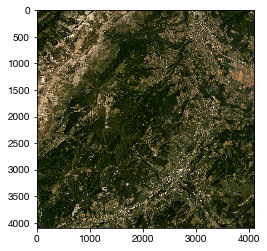

In [17]:
# after renaming
renamed = imageio.imread('../data/planet/france/sherrie10k/monthly_mosaics_renamed/09999_2019_07_L15-1061E-1318N.tif')
print(renamed.shape)
plt.imshow(np.moveaxis(renamed[:3,:,:], 0, -1))
plt.show()

(271, 271, 4)


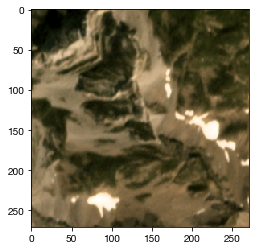

In [18]:
# after clipping
clipped = imageio.imread('../data/planet/france/sherrie10k/temp_monthly_mosaics_renamed_clipped/09999_2019_07_L15-1061E-1318N.tif')
print(clipped.shape)
plt.imshow(clipped[:,:,:3])
plt.show()

(271, 271, 4)


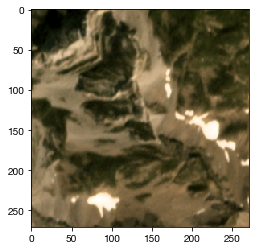

In [19]:
# after merging
final = imageio.imread('../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/2019_07/09999_2019_07.tif')
print(final.shape)
plt.imshow(final[:,:,:3])
plt.show()

(271, 271, 4)


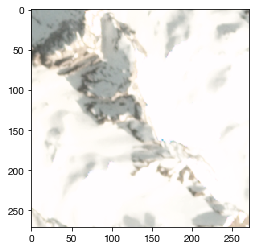

In [20]:
# after merging
final = imageio.imread('../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/2019_04/09999_2019_04.tif')
print(final.shape)
plt.imshow(final[:,:,:3])
plt.show()

(331, 331, 4)


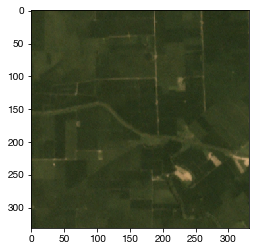

In [24]:
# after merging
final = imageio.imread('../data/planet/india/monthly_mosaics_renamed_clipped_merged/00172_2019_09.tif')
print(final.shape)
plt.imshow(final[:,:,:3])
plt.show()